# Collected Data

In [1]:
import sqlite3
import pandas as pd
import os

DATA_PATH = os.path.expanduser('~/Reddit_Virality_Data')  # Or your DATA_PATH

conn = sqlite3.connect(f'{DATA_PATH}/virality.db')

# Count the number of rows in the 'posts' table
count_query = "SELECT COUNT(*) FROM posts;"
count_df = pd.read_sql_query(count_query, conn)

conn.close()

total_memes_collected = count_df.iloc[0, 0] 

print(f"Total number of unique memes collected: {total_memes_collected}")

Total number of unique memes collected: 71040


Data Range

Visualizing full dataset from: C:\Users\sdogan\Reddit_Virality_Data\virality.db

--- Visualizing data from: C:\Users\sdogan\Reddit_Virality_Data\virality.db ---
Plot saved: C:\Users\sdogan\Reddit_Virality_Data\Data_20251201_001506.png


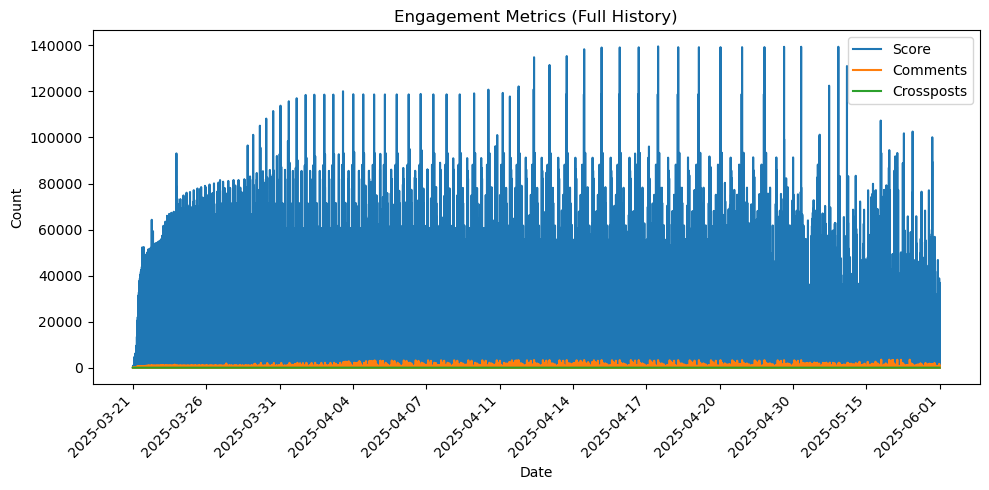


Done.


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math

# Function to Filter Database by Date Range
def filter_database_by_date_range(original_db_path, new_db_path, start_date_str, end_date_str):
    """
    Creates a new SQLite database copy containing only data within the specified date range.
    """
    print(f"\n--- Filtering Database ---")
    print(f"Source: {original_db_path}")
    print(f"Target: {new_db_path}")
    print(f"Keeping data between: {start_date_str} and {end_date_str} (Inclusive)")

    if os.path.exists(new_db_path):
        print(f"Warning: Target file '{new_db_path}' already exists. Overwriting.")
        try:
            os.remove(new_db_path)
        except OSError as e:
            print(f"Error removing existing file: {e}")
            return False

    conn_orig = None
    conn_new = None
    
    try:
        start_dt = pd.to_datetime(start_date_str, errors='raise').normalize()
        start_ts = int(start_dt.timestamp())

        end_dt_target = pd.to_datetime(end_date_str, errors='raise').normalize()
        end_dt_exclusive = end_dt_target + pd.Timedelta(days=1)
        end_ts = int(end_dt_exclusive.timestamp())

        conn_orig = sqlite3.connect(original_db_path)
        cursor_orig = conn_orig.cursor()
        
        conn_new = sqlite3.connect(new_db_path)
        cursor_new = conn_new.cursor()

        cursor_orig.execute("SELECT name, sql FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%'")
        tables_to_copy = cursor_orig.fetchall()

        for table_name, create_table_sql in tables_to_copy:
            print(f"Processing table: {table_name}...")
            cursor_new.execute(create_table_sql)
            chunk_size = 50000
            
            if table_name == 'time_series':
                print(f"  Filtering 'time_series' (Timestamp >= {start_ts} AND Timestamp < {end_ts})...")
                query = f"SELECT * FROM time_series WHERE timestamp >= ? AND timestamp < ?"
                params = (start_ts, end_ts)
                
                row_count = 0
                for chunk_df in pd.read_sql_query(query, conn_orig, params=params, chunksize=chunk_size):
                    chunk_df.to_sql(table_name, conn_new, if_exists='append', index=False)
                    row_count += len(chunk_df)
                print(f"  -> Copied {row_count} rows.")
            else:
                print(f"  Copying all data for '{table_name}'...")
                query = f"SELECT * FROM {table_name}"
                for chunk_df in pd.read_sql_query(query, conn_orig, chunksize=chunk_size):
                    chunk_df.to_sql(table_name, conn_new, if_exists='append', index=False)
            
            conn_new.commit()

        print("Copying indexes...")
        cursor_orig.execute("SELECT name, sql FROM sqlite_master WHERE type='index' AND name NOT LIKE 'sqlite_autoindex_%' AND sql IS NOT NULL")
        for index_name, create_index_sql in cursor_orig.fetchall():
            try:
                cursor_new.execute(create_index_sql)
            except sqlite3.OperationalError:
                pass 
        conn_new.commit()
        
        print(f"Success! Filtered database created at: {new_db_path}")
        return True

    except Exception as e:
        print(f"Error during filtering: {e}")
        return False
    finally:
        if conn_orig: conn_orig.close()
        if conn_new: conn_new.close()

# Function to Visualize Engagement Data
def visualize_engagement_data(db_filepath,
                                  output_plot_dir,
                                  plot_filename_base="engagement_plot",
                                  plot_title_info="",
                                  figure_size=(10, 5),
                                  dpi=100,
                                  save_the_plot=True):
    """
    Visualizes aggregated time series engagement data.
    Uses SEQUENTIAL PLOTTING (Index-based) to hide time gaps visually.
    """
    print(f"\n--- Visualizing data from: {db_filepath} ---")
    try:
        conn = sqlite3.connect(db_filepath)
        
        cursor = conn.cursor()
        cursor.execute("PRAGMA table_info(time_series)")
        columns = [col[1] for col in cursor.fetchall()]
        score_col = 'reddit_score' if 'reddit_score' in columns else 'score'
        comments_col = 'comments' if 'comments' in columns else 'num_comments'
        crossposts_col = next((c for c in ['crossposts', 'num_crossposts'] if c in columns), None)

        sel = [f"timestamp", f"{score_col} AS effective_score", f"{comments_col} AS effective_comments"]
        if crossposts_col: sel.append(f"{crossposts_col} AS effective_crossposts")
        else: sel.append("0 AS effective_crossposts")
        
        df = pd.read_sql_query(f"SELECT {', '.join(sel)} FROM time_series ORDER BY timestamp ASC", conn)
        conn.close()

        if df.empty:
            print("No data found to plot.")
            return

        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        agg_df = df.groupby('datetime').agg({
            'effective_score': 'sum',
            'effective_comments': 'sum',
            'effective_crossposts': 'sum'
        }).reset_index().sort_values('datetime')
        
        x_vals = range(len(agg_df))
        
        plt.figure(figsize=figure_size)
        
        plt.plot(x_vals, agg_df['effective_score'], label='Score')
        plt.plot(x_vals, agg_df['effective_comments'], label='Comments')
        plt.plot(x_vals, agg_df['effective_crossposts'], label='Crossposts')

        # Manual Date Ticks

        num_ticks = 12
        total_points = len(agg_df)
        if total_points > num_ticks:
            # Pick indices evenly spaced across the dataset
            tick_indices = [int(i * (total_points - 1) / (num_ticks - 1)) for i in range(num_ticks)]
            tick_labels = [agg_df['datetime'].iloc[i].strftime('%Y-%m-%d') for i in tick_indices]
            plt.xticks(tick_indices, tick_labels, rotation=45, ha='right')
        else:
            # If very few points, just show them all
            plt.xticks(x_vals, agg_df['datetime'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.title(f'Engagement Metrics {plot_title_info}')
        plt.legend()
        plt.tight_layout()

        if save_the_plot:
            fname = f"{plot_filename_base}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            path = os.path.join(output_plot_dir, fname)
            plt.savefig(path, dpi=dpi)
            print(f"Plot saved: {path}")
        
        plt.show()

    except Exception as e:
        print(f"Visualization Error: {e}")
        import traceback
        traceback.print_exc()

# Main Execution Block 
if __name__ == "__main__":
    DATA_DIR = os.path.normpath(os.path.expanduser('~/Reddit_Virality_Data'))
    os.makedirs(DATA_DIR, exist_ok=True)
    
    ORIGINAL_DB = os.path.join(DATA_DIR, 'virality.db')

    if not os.path.exists(ORIGINAL_DB):
        print(f"CRITICAL: Original database '{ORIGINAL_DB}' not found.")
    else:
        print(f"Visualizing full dataset from: {ORIGINAL_DB}")
        
        visualize_engagement_data(
            db_filepath=ORIGINAL_DB,
            output_plot_dir=DATA_DIR,
            plot_filename_base="Data",
            plot_title_info="(Full History)"
        )

    print("\nDone.")

Metadata

In [3]:
import os
import sqlite3
import pandas as pd
from datetime import datetime
import logging
from tabulate import tabulate

# Configure paths
DATA_DIR = os.path.expanduser('~/Reddit_Virality_Data')
DB_PATH = os.path.join(DATA_DIR, 'virality.db')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('db_inspector')

def inspect_database(db_path=DB_PATH):
    """
    Comprehensive inspection of all tables in the database
    """
    logger.info(f"Connecting to database: {db_path}")
    
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Get list of all tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = [row[0] for row in cursor.fetchall()]
        
        print(f"\n{'='*20} DATABASE SUMMARY {'='*20}")
        print(f"Database path: {db_path}")
        print(f"Number of tables: {len(tables)}")
        print(f"Tables: {', '.join(tables)}")
        
        # Inspect each table
        for table_name in tables:
            print(f"\n{'='*30} TABLE: {table_name} {'='*30}")
            
            # Get schema
            cursor.execute(f"PRAGMA table_info({table_name})")
            columns = cursor.fetchall()
            
            print("\n=== TABLE SCHEMA ===")
            schema_data = [(col[0], col[1], col[2], "NOT NULL" if col[3] else "", 
                           col[4] if col[4] is not None else "", "PK" if col[5] else "") 
                          for col in columns]
            print(tabulate(schema_data, 
                         headers=["ID", "Column Name", "Type", "Null", "Default", "Key"],
                         tablefmt="grid"))
            
            # Count rows
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            row_count = cursor.fetchone()[0]
            print(f"\nTotal rows: {row_count:,}")
            
            # Get sample data (first 5 rows)
            print("\n=== SAMPLE DATA ===")
            try:
                sample_df = pd.read_sql_query(
                    f"SELECT * FROM {table_name} LIMIT 5", 
                    conn
                )
                print(tabulate(sample_df, headers='keys', tablefmt='grid'))
            except Exception as e:
                print(f"Error getting sample data: {e}")
            
            # Get basic column stats for tables with reasonable row counts
            if row_count > 0 and row_count < 1000000: 
                print("\n=== COLUMN ANALYSIS ===")
                
                for col in columns:
                    col_name = col[1]
                    col_type = col[2].upper()
                    
                    # Skip binary/large object columns
                    if "BLOB" in col_type:
                        continue
                    
                    print(f"\nColumn: {col_name} ({col_type})")
                    
                    # Count NULL values
                    cursor.execute(f"SELECT COUNT(*) FROM {table_name} WHERE {col_name} IS NULL")
                    null_count = cursor.fetchone()[0]
                    print(f"NULL values: {null_count:,} ({null_count/row_count*100:.1f}% of rows)")
                    
                    # Get distinct value count
                    try:
                        cursor.execute(f"SELECT COUNT(DISTINCT {col_name}) FROM {table_name}")
                        distinct_count = cursor.fetchone()[0]
                        print(f"Distinct values: {distinct_count:,}")
                    except:
                        print("Distinct values: Unable to calculate")
                    
                    # For numeric columns, get min, max, avg
                    if col_type in ('INTEGER', 'REAL', 'FLOAT', 'NUMERIC', 'DECIMAL', 'NUMBER'):
                        try:
                            cursor.execute(f"SELECT MIN({col_name}), MAX({col_name}), AVG({col_name}) FROM {table_name}")
                            min_val, max_val, avg_val = cursor.fetchone()
                            print(f"Min: {min_val}, Max: {max_val}, Avg: {avg_val:.2f}")
                        except:
                            print("Numeric stats: Unable to calculate")
                    
                    # For timestamp columns, show date range if they appear to be unix timestamps
                    if col_type == 'INTEGER' and ('TIME' in col_name.upper() or 'DATE' in col_name.upper()):
                        try:
                            cursor.execute(f"SELECT MIN({col_name}), MAX({col_name}) FROM {table_name}")
                            min_ts, max_ts = cursor.fetchone()
                            
                            # Only process if timestamp seems valid (after 2000-01-01)
                            if min_ts and min_ts > 946684800:  # 2000-01-01 timestamp
                                min_date = datetime.fromtimestamp(min_ts)
                                max_date = datetime.fromtimestamp(max_ts) if max_ts else datetime.now()
                                print(f"Date range: {min_date} to {max_date}")
                        except:
                            pass
            
            # For time_series table, get distribution of points per entity
            if table_name == 'time_series' and 'id' in [col[1] for col in columns]:
                print("\n=== DATA POINTS PER ENTITY ===")
                try:
                    stats_query = """
                        SELECT 
                            COUNT(*) as points,
                            COUNT(*) as entities
                        FROM (
                            SELECT id, COUNT(*) as points
                            FROM time_series
                            GROUP BY id
                        )
                    """
                    cursor.execute(stats_query)
                    total_points, total_entities = cursor.fetchone()
                    
                    cursor.execute("""
                        SELECT 
                            MIN(points) as min_points,
                            MAX(points) as max_points,
                            AVG(points) as avg_points
                        FROM (
                            SELECT id, COUNT(*) as points
                            FROM time_series
                            GROUP BY id
                        )
                    """)
                    min_points, max_points, avg_points = cursor.fetchone()
                    
                    print(f"Entities tracked: {total_entities}")
                    print(f"Total data points: {total_points}")
                    print(f"Points per entity - Min: {min_points}, Max: {max_points}, Avg: {avg_points:.2f}")
                    
                    cursor.execute("""
                        SELECT 
                            CASE 
                                WHEN points <= 5 THEN '1-5'
                                WHEN points <= 10 THEN '6-10'
                                WHEN points <= 20 THEN '11-20'
                                WHEN points <= 30 THEN '21-30'
                                ELSE '30+'
                            END as bucket,
                            COUNT(*) as count
                        FROM (
                            SELECT id, COUNT(*) as points
                            FROM time_series
                            GROUP BY id
                        )
                        GROUP BY bucket
                        ORDER BY MIN(points)
                    """)
                    distribution = cursor.fetchall()
                    
                    print("\nDistribution of data points per entity:")
                    for bucket, count in distribution:
                        print(f"{bucket} points: {count} entities ({count/total_entities*100:.1f}%)")
                    
                except Exception as e:
                    print(f"Error analyzing time series data: {e}")
            
            # For posts table, analyze by subreddit
            if table_name == 'posts' and 'subreddit' in [col[1].lower() for col in columns]:
                print("\n=== POSTS BY SUBREDDIT ===")
                try:
                    cursor.execute("""
                        SELECT subreddit, COUNT(*) as count
                        FROM posts
                        GROUP BY subreddit
                        ORDER BY count DESC
                        LIMIT 40
                    """)
                    subreddits = cursor.fetchall()
                    
                    print("Top 10 subreddits:")
                    for subreddit, count in subreddits:
                        print(f"r/{subreddit}: {count} posts")
                except Exception as e:
                    print(f"Error analyzing subreddits: {e}")
        
        # Check for relationships between tables
        if len(tables) > 1:
            print(f"\n{'='*20} TABLE RELATIONSHIPS {'='*20}")
            
            for table1 in tables:
                cols1 = [col[1] for col in cursor.execute(f"PRAGMA table_info({table1})").fetchall()]
                
                for table2 in tables:
                    if table1 != table2:
                        cols2 = [col[1] for col in cursor.execute(f"PRAGMA table_info({table2})").fetchall()]
                        
                        # Find potential foreign keys (columns with same name)
                        common_cols = set(cols1).intersection(set(cols2))
                        if common_cols:
                            print(f"{table1} and {table2} have common columns: {', '.join(common_cols)}")
                            
                            # Check if they actually reference each other by sampling values
                            for col in common_cols:
                                try:
                                    cursor.execute(f"""
                                        SELECT COUNT(*) 
                                        FROM {table1} t1
                                        JOIN {table2} t2 ON t1.{col} = t2.{col}
                                        LIMIT 1
                                    """)
                                    if cursor.fetchone()[0] > 0:
                                        print(f"  ✓ Confirmed join relationship on column '{col}'")
                                except:
                                    pass
        
        # Close connection
        conn.close()
        
        logger.info("Database inspection complete")
        
    except sqlite3.Error as e:
        logger.error(f"SQLite error: {e}")
    except Exception as e:
        logger.error(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    inspect_database()



2025-12-01 00:15:07,924 - INFO - Connecting to database: C:\Users\sdogan/Reddit_Virality_Data\virality.db



==================== DATABASE SUMMARY ====================
Database path: C:\Users\sdogan/Reddit_Virality_Data\virality.db
Number of tables: 4
Tables: posts, time_series, subreddits, temp_valid_post_ids

============================== TABLE: posts ==============================

=== TABLE SCHEMA ===
+------+----------------------+---------+--------+-----------+-------+
|   ID | Column Name          | Type    | Null   | Default   | Key   |
+======+======================+=========+========+===========+=======+
|    0 | id                   | TEXT    |        |           | PK    |
+------+----------------------+---------+--------+-----------+-------+
|    1 | title                | TEXT    |        |           |       |
+------+----------------------+---------+--------+-----------+-------+
|    2 | author               | TEXT    |        |           |       |
+------+----------------------+---------+--------+-----------+-------+
|    3 | author_post_karma    | INTEGER |        |         

2025-12-01 00:15:10,071 - INFO - Database inspection complete


  ✓ Confirmed join relationship on column 'id'
time_series and temp_valid_post_ids have common columns: id
subreddits and posts have common columns: title, created_utc, last_updated
  ✓ Confirmed join relationship on column 'last_updated'
temp_valid_post_ids and posts have common columns: id
temp_valid_post_ids and time_series have common columns: id


# Defining Virality (Chapter 3)

Feature Engineering

In [4]:
import pandas as pd
import numpy as np
import sqlite3
import time
import gc
import os
from pathlib import Path
from tqdm.auto import tqdm 
import warnings
from scipy.integrate import trapezoid
from scipy.signal import find_peaks
import math
from datetime import datetime, timedelta
import pytz
import re 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

# Settings & Constants
SCRIPT_START = time.time()
HOME = Path.home()

# IMPORTANT: Update this path to your actual data directory!!
DATA_DIR = Path('.') / 'Reddit_Virality_Data' 
DB_PATH = DATA_DIR / 'virality.db'

# UPDATED: Output directory per your specific script request
RESULTS_DIR = DATA_DIR / 'Chapter_3'
CHECKPOINT_DIR = RESULTS_DIR / 'checkpoints'

# Create directories
for p in [RESULTS_DIR, CHECKPOINT_DIR]:
    try:
        p.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"Error creating directory {p}: {e}")

# Feature Engineering Settings
FE_TIME_WINDOWS = [30, 60, 120, 180, 240, 300, 360, 420]
NORM_PERCENTILE_CAP = 99
POST_MIN_OBSERVED_DURATION_HOURS = 24

# Target Determination Settings
RANDOM_STATE = 42
FIXED_PERCENTILE_THRESHOLD = 5 
WEIGHT_CALC_TARGET_PCT = 5

FINAL_FEATURES_TARGET_PATH = RESULTS_DIR / 'targets.csv'


# Utilities 
def get_conn(db_path=DB_PATH):
    try:
        db_path.parent.mkdir(parents=True, exist_ok=True)
        return sqlite3.connect(str(db_path))
    except sqlite3.Error as e:
        print(f"Error connecting to database at {db_path}: {e}")
        raise

def save_checkpoint(df, name, directory=CHECKPOINT_DIR):
    try:
        directory.mkdir(parents=True, exist_ok=True)
        path = directory / f"{name}.csv"
        df.to_csv(path, index=False)
    except Exception as e:
        print(f"Error saving checkpoint {name}: {e}")

def load_checkpoint(name, directory=CHECKPOINT_DIR):
    path = directory / f"{name}.csv"
    if path.exists():
        try:
            return pd.read_csv(path, low_memory=False)
        except Exception:
            return None
    return None

def to_seconds(series):
    try:
        median_val = series.dropna().median()
        if pd.notna(median_val) and median_val > 1e10:
            return series / 1000
    except Exception:
        pass
    return series

def _set_default_temporal_features(row):
    row['hour_of_day'] = np.nan; row['day_of_week'] = np.nan; row['month'] = np.nan; row['year'] = np.nan; row['day_of_month'] = np.nan
    row['is_weekend'] = 0; row['is_business_hours'] = 0; row['is_evening'] = 0; row['is_night'] = 0; row['is_morning'] = 0; row['is_afternoon'] = 0
    row['quarter'] = np.nan; row['part_of_month'] = np.nan; row['timestamp_missing'] = 1; row['timestamp_error'] = 0
    return row

def add_temporal_features(df, timestamp_col='created_utc'):
    if timestamp_col not in df.columns: return df
    print(f"Adding temporal features based on '{timestamp_col}'...")
    df[timestamp_col] = pd.to_numeric(df[timestamp_col], errors='coerce')
    temporal_cols = ['hour_of_day', 'day_of_week', 'month', 'year', 'day_of_month', 'is_weekend', 'is_business_hours', 'is_evening', 'is_night', 'is_morning', 'is_afternoon', 'quarter', 'part_of_month', 'timestamp_missing', 'timestamp_error']
    for col in temporal_cols:
        if col in ['is_weekend', 'is_business_hours', 'is_evening', 'is_night', 'is_morning', 'is_afternoon', 'timestamp_missing', 'timestamp_error']: df[col] = 0
        else: df[col] = np.nan
    processed_rows = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Timestamps"):
        ts_seconds = row[timestamp_col]; new_row = row.copy()
        if pd.notna(ts_seconds):
            try:
                dt = datetime.fromtimestamp(ts_seconds, tz=pytz.utc)
                new_row['hour_of_day'] = dt.hour; new_row['day_of_week'] = dt.weekday(); new_row['month'] = dt.month; new_row['year'] = dt.year; new_row['day_of_month'] = dt.day
                new_row['is_weekend'] = 1 if dt.weekday() >= 5 else 0; new_row['is_business_hours'] = 1 if 9 <= dt.hour <= 17 and dt.weekday() < 5 else 0
                new_row['is_evening'] = 1 if 18 <= dt.hour <= 23 else 0; new_row['is_night'] = 1 if 0 <= dt.hour <= 5 else 0; new_row['is_morning'] = 1 if 6 <= dt.hour <= 11 else 0; new_row['is_afternoon'] = 1 if 12 <= dt.hour <= 17 else 0
                new_row['quarter'] = (dt.month - 1) // 3 + 1; new_row['part_of_month'] = (dt.day - 1) // 10 + 1
                new_row['timestamp_missing'] = 0; new_row['timestamp_error'] = 0
            except (ValueError, OSError, TypeError): new_row = _set_default_temporal_features(new_row); new_row['timestamp_missing'] = 0; new_row['timestamp_error'] = 1
        else: new_row = _set_default_temporal_features(new_row); new_row['timestamp_missing'] = 1; new_row['timestamp_error'] = 0
        processed_rows.append(new_row)
    if processed_rows:
        return pd.DataFrame(processed_rows)
    return df


# Core Data Loading 

def load_data(conn):
    print("Loading posts and subreddits data...")
    try:
        posts = pd.read_sql("SELECT * FROM posts", conn); subs = pd.read_sql("SELECT name AS subreddit, subscribers FROM subreddits", conn)
        print(f"Loaded {len(posts)} posts and {len(subs)} subreddits.")
        posts['subreddit'] = posts['subreddit'].astype(str); subs['subreddit'] = subs['subreddit'].astype(str)
        posts_merged = posts.merge(subs, on='subreddit', how='inner')
        print(f"Posts after inner merge: {len(posts_merged)}")
        if posts_merged.empty: return posts_merged
        posts_merged['subscribers'] = pd.to_numeric(posts_merged['subscribers'], errors='coerce')
        posts_merged.dropna(subset=['subscribers'], inplace=True)
        posts_merged['subscribers'] = posts_merged['subscribers'].clip(lower=1)
        posts_merged['created_utc'] = to_seconds(posts_merged['created_utc']); posts_merged['id'] = posts_merged['id'].astype(str)
        return posts_merged
    except Exception as e:
        print(f"Data loading error: {e}")
        raise

def load_time_series_data(conn):
    print("Loading time series data...")
    try:
        ts = pd.read_sql("SELECT id, timestamp, score, num_comments, num_crossposts, upvote_ratio, category FROM time_series WHERE id IS NOT NULL AND timestamp IS NOT NULL ORDER BY id, timestamp", conn)
        ts['timestamp'] = to_seconds(ts['timestamp']); ts['id'] = ts['id'].astype(str)
        ts['category'] = ts['category'].fillna('unknown').astype(str).str.lower()
        print(f"Loaded {len(ts)} time series records.")
        return ts
    except Exception as e:
        print(f"Timeseries loading error: {e}")
        raise

#  Feature Extraction Logic

def preprocess_ts(ts_df, posts_df, train_ids):
    """
    Preprocesses TS data with strict leakage prevention using train_ids.
    """
    print("Preprocessing time series data (calculating caps from training set)...")
    posts_df['id'] = posts_df['id'].astype(str); ts_df['id'] = ts_df['id'].astype(str)
    
    required_post_cols = ['id', 'created_utc', 'subscribers']
    if not all(col in posts_df.columns for col in required_post_cols): raise ValueError(f"posts_df missing: {required_post_cols}")
    
    df = ts_df.merge(posts_df[['id', 'created_utc', 'subscribers']], on='id', how='inner')
    for col in ['timestamp', 'created_utc', 'subscribers', 'score', 'num_comments', 'num_crossposts']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    df.dropna(subset=['timestamp', 'created_utc', 'subscribers'], inplace=True)
    df['minutes'] = (df['timestamp'] - df['created_utc']) / 60
    df = df[df['minutes'].notna() & (df['minutes'] >= -1e-6)].copy()
    df['subscribers'] = df['subscribers'].replace(0, 1)

    # Learn Caps from Train
    train_ts_df = df[df['id'].isin(train_ids)]
    caps = {}
    
    for col in ['score', 'num_comments', 'num_crossposts']:
        if col in df.columns:
            raw_train = train_ts_df[col].fillna(0) * 100_000 / train_ts_df['subscribers']
            train_non_nan = raw_train.dropna()
            if len(train_non_nan) > 1:
                try: caps[col] = np.nanpercentile(train_non_nan, NORM_PERCENTILE_CAP)
                except: caps[col] = np.inf
            else: caps[col] = np.inf
            
            # Apply to All
            raw_all = df[col].fillna(0) * 100_000 / df['subscribers']
            df[f'normalized_{col}'] = np.clip(raw_all, a_min=0, a_max=caps[col])
        else: 
            df[f'normalized_{col}'] = 0
            
    cols_to_keep = ['id', 'minutes', 'timestamp', 'created_utc', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'normalized_score', 'normalized_num_comments', 'normalized_num_crossposts', 'category']
    for c in cols_to_keep:
        if c not in df.columns: df[c] = np.nan
    return df[cols_to_keep].copy()

def detect_engagement_points(post_ts_df, smooth_w=3, acc_thresh_ratio=0.1, vel_takeoff_ratio=0.1, suffix=""):
    df = post_ts_df.copy()
    if 'minutes' not in df.columns: return {'id': df['id'].iloc[0] if not df.empty else 'UNKNOWN'}
    df['minutes'] = pd.to_numeric(df['minutes'], errors='coerce'); df.dropna(subset=['minutes'], inplace=True)
    df = df.sort_values('minutes').reset_index(drop=True); post_id = df['id'].iloc[0] if not df.empty and 'id' in df.columns else 'UNKNOWN'; results = {'id': post_id}
    
    # Base result structure
    base_results = {'first_vote_min': None, 'first_comm_min': None, 'first_cross_min': None, 'time_to_peak': None, 'peak_velocity': 0.0, 'time_to_takeoff': None, 'takeoff_velocity': 0.0, 'peak_acceleration': 0.0, 'min_acceleration': 0.0, 'engagement_auc': 0.0, 'half_life_minutes': None, 'slope_5min': 0.0, 'slope_10min': 0.0, 'burst_count': 0, 'timing_entropy': 0.0, 'momentum_ratio': None}
    for k, v in base_results.items(): results[f"{k}{suffix}"] = v
    if len(df) < max(smooth_w, 2): return results
    
    # Calculations
    for col in ['normalized_score', 'normalized_num_comments', 'normalized_num_crossposts']:
        if col not in df.columns: df[col] = 0
        else: df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df['total_eng'] = df['normalized_score'] + df['normalized_num_comments'] + df['normalized_num_crossposts']
    time_diff = df['minutes'].diff().fillna(method='bfill').apply(lambda x: x if pd.notna(x) and x > 1e-9 else 1e-9)
    df['vel'] = df['total_eng'].diff().fillna(0) / time_diff; df['svel'] = df['vel'].rolling(smooth_w, center=True, min_periods=1).mean().fillna(0)
    df['acc'] = df['svel'].diff().fillna(0) / time_diff; df['sacc'] = df['acc'].rolling(smooth_w, center=True, min_periods=1).mean().fillna(0)
    
    try: first_vote_idx = df['normalized_score'].ne(0).idxmax();
    except ValueError: first_vote_idx = 0
    if first_vote_idx < len(df) and df.loc[first_vote_idx, 'normalized_score'] != 0: results[f'first_vote_min{suffix}'] = df.loc[first_vote_idx, 'minutes']
    try: first_comm_idx = df['normalized_num_comments'].ne(0).idxmax();
    except ValueError: first_comm_idx = 0
    if first_comm_idx < len(df) and df.loc[first_comm_idx, 'normalized_num_comments'] != 0: results[f'first_comm_min{suffix}'] = df.loc[first_comm_idx, 'minutes']
    try: first_cross_idx = df['normalized_num_crossposts'].ne(0).idxmax();
    except ValueError: first_cross_idx = 0
    if first_cross_idx < len(df) and df.loc[first_cross_idx, 'normalized_num_crossposts'] != 0: results[f'first_cross_min{suffix}'] = df.loc[first_cross_idx, 'minutes']
    
    peak_idx = -1
    if df['svel'].notna().any() and df['svel'].abs().max() > 1e-9: peak_idx = df['svel'].idxmax(); results[f'time_to_peak{suffix}'] = df.at[peak_idx, 'minutes']; results[f'peak_velocity{suffix}'] = df.at[peak_idx, 'svel']
    if peak_idx > 0 and results[f'peak_velocity{suffix}'] is not None and results[f'peak_velocity{suffix}'] > 1e-9:
        sacc_up_to_peak = df.loc[:peak_idx, 'sacc']
        if sacc_up_to_peak.notna().any():
            max_acc = sacc_up_to_peak.max()
            if pd.notna(max_acc) and max_acc > 1e-9:
                results[f'peak_acceleration{suffix}'] = max_acc; acc_threshold = max_acc * acc_thresh_ratio; vel_threshold = results[f'peak_velocity{suffix}'] * vel_takeoff_ratio
                takeoff_candidates = df[((df['sacc'] > acc_threshold) | (df['svel'] >= vel_threshold)) & (df.index < peak_idx)]
                if not takeoff_candidates.empty: takeoff_idx = takeoff_candidates.index[0]; results[f'time_to_takeoff{suffix}'] = df.at[takeoff_idx, 'minutes']; results[f'takeoff_velocity{suffix}'] = df.at[takeoff_idx, 'svel']
    if results[f'peak_acceleration{suffix}'] == 0.0 and df['sacc'].notna().any(): results[f'peak_acceleration{suffix}'] = df['sacc'].max()
    if df['sacc'].notna().any(): results[f'min_acceleration{suffix}'] = df['sacc'].min()
    total_duration = df['minutes'].max()
    if pd.notna(total_duration) and total_duration > 0 and df['total_eng'].notna().any():
        try:
            valid_eng = df[['minutes', 'total_eng']].dropna().drop_duplicates(subset=['minutes'])
            if len(valid_eng) >= 2:
                valid_eng = valid_eng.sort_values('minutes')
                results[f'engagement_auc{suffix}'] = trapezoid(valid_eng['total_eng'], valid_eng['minutes']) / total_duration
        except Exception: pass
    if not df.empty:
        final_total_engagement = df['total_eng'].iloc[-1]
        if pd.notna(final_total_engagement) and final_total_engagement > 1e-9:
            half_engagement_value = final_total_engagement * 0.5
            half_life_candidates = df[df['total_eng'] >= half_engagement_value]
            if not half_life_candidates.empty:
                results[f'half_life_minutes{suffix}'] = df['minutes'].iloc[half_life_candidates.index[0]]
    def calculate_slope(window_minutes):
        segment = df[df['minutes'] <= window_minutes][['minutes', 'total_eng']].dropna().drop_duplicates(subset=['minutes'])
        if len(segment) >= 2:
            try:
                return np.polyfit(segment['minutes'], segment['total_eng'], 1)[0]
            except (np.linalg.LinAlgError, ValueError):
                return 0.0
        return 0.0
    results[f'slope_5min{suffix}'] = calculate_slope(5); results[f'slope_10min{suffix}'] = calculate_slope(10)
    if pd.notna(results[f'peak_acceleration{suffix}']) and results[f'peak_acceleration{suffix}'] > 1e-9:
        burst_height_threshold = max(results[f'peak_acceleration{suffix}'] * 0.1, 0.01)
        try:
            sacc_numeric = pd.to_numeric(df['sacc'], errors='coerce').fillna(0)
            if sacc_numeric.notna().any():
                bursts, _ = find_peaks(sacc_numeric, height=burst_height_threshold)
                results[f'burst_count{suffix}'] = len(bursts)
        except Exception: pass
    if pd.notna(total_duration) and total_duration > 0:
        try:
            engagement_times = df.loc[df['vel'].abs() > 1e-6, 'minutes'].dropna()
            if len(engagement_times) > 1:
                bins = np.linspace(0, total_duration, num=11); counts, _ = np.histogram(engagement_times, bins=bins)
                if counts.sum() > 0: probs = counts / counts.sum(); results[f'timing_entropy{suffix}'] = -sum(p * np.log(p + 1e-9) for p in probs if p > 0)
        except Exception: pass
    if peak_idx is not None and 0 < peak_idx < len(df) - 1:
        vel_before_peak = df.loc[:peak_idx-1, 'svel'].mean(); vel_after_peak = df.loc[peak_idx+1:, 'svel'].mean()
        if pd.notna(vel_before_peak) and pd.notna(vel_after_peak): denominator = abs(vel_after_peak) + 1e-6; results[f'momentum_ratio{suffix}'] = vel_before_peak / denominator
    for key, value in list(results.items()):
        if key == 'id': continue; new_value = value
        if isinstance(value, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64)): new_value = int(value) if pd.notna(value) else (0 if 'count' in key else None)
        elif isinstance(value, (np.float_, np.float16, np.float32, np.float64)): new_value = float(value) if pd.notna(value) else (0.0 if key not in [f'momentum_ratio{suffix}', f'half_life_minutes{suffix}', f'time_to_peak{suffix}', f'time_to_takeoff{suffix}'] else None)
        elif pd.isna(value): new_value = None
        if new_value is None:
            if 'count' in key: new_value = 0
            elif key in [f'peak_velocity{suffix}', f'takeoff_velocity{suffix}', f'peak_acceleration{suffix}', f'min_acceleration{suffix}', f'engagement_auc{suffix}', f'slope_5min{suffix}', f'slope_10min{suffix}', f'timing_entropy{suffix}']: new_value = 0.0
        results[key] = new_value
    return results

def process_time_windows_sql(initial_features_df, windows, batch_size=5000):
    print(f"Processing features for time windows: {windows} minutes...")
    conn = None
    try:
        conn = get_conn()
    except Exception as e:
        print(f"DB Connection Error: {e}")
        return initial_features_df
    features_df = initial_features_df.copy(); features_df['id'] = features_df['id'].astype(str); all_ids = features_df['id'].unique().tolist(); n_ids = len(all_ids)
    for window_minutes in tqdm(windows, desc="Window Extraction"):
        window_seconds = window_minutes * 60; window_features = []
        for i in range(0, n_ids, batch_size):
            chunk_ids = all_ids[i : i + batch_size];
            if not chunk_ids: continue
            placeholders = ','.join('?' * len(chunk_ids))
            query = f"""WITH RelevantPosts AS (SELECT p.id, p.created_utc, COALESCE(s.subscribers, 1000) as subscribers FROM posts p LEFT JOIN subreddits s ON p.subreddit = s.name WHERE p.id IN ({placeholders})), WindowedTS AS (SELECT ts.id, ts.timestamp, ts.score, ts.num_comments, ts.num_crossposts, ts.upvote_ratio, ts.category, rp.created_utc, rp.subscribers, (ts.timestamp - rp.created_utc) AS seconds_elapsed FROM time_series ts JOIN RelevantPosts rp ON ts.id = rp.id WHERE ts.id IN ({placeholders}) AND (ts.timestamp - rp.created_utc) BETWEEN 0 AND ?), RankedTS AS ( SELECT *, ROW_NUMBER() OVER(PARTITION BY id ORDER BY timestamp DESC) as rn FROM WindowedTS ), LastValidTS AS ( SELECT * FROM RankedTS WHERE rn = 1 ) SELECT rp.id, lv.timestamp, lv.score, lv.num_comments, lv.num_crossposts, lv.upvote_ratio, lv.category, rp.created_utc, lv.seconds_elapsed, rp.subscribers FROM RelevantPosts rp LEFT JOIN LastValidTS lv ON rp.id = lv.id;"""
            params = chunk_ids + chunk_ids + [window_seconds]
            try:
                df_chunk = pd.read_sql(query, conn, params=params)
                if not df_chunk.empty:
                    df_chunk['id'] = df_chunk['id'].astype(str); df_chunk['minutes'] = pd.to_numeric(df_chunk['seconds_elapsed'], errors='coerce') / 60
                    df_chunk['subscribers'] = pd.to_numeric(df_chunk['subscribers'], errors='coerce').fillna(1000).clip(lower=1).replace(0,1); df_chunk['category'] = df_chunk['category'].fillna('unknown').astype(str).str.lower()
                    for col in ['score', 'num_comments', 'num_crossposts']:
                        if col in df_chunk.columns:
                            df_chunk[col] = pd.to_numeric(df_chunk[col], errors='coerce')
                            raw_normalized = df_chunk[col].fillna(0) * 100_000 / df_chunk['subscribers']
                            non_nan_normalized = raw_normalized.dropna()
                            cap = np.inf
                            if len(non_nan_normalized) > 1:
                                try: cap = np.nanpercentile(non_nan_normalized, NORM_PERCENTILE_CAP)
                                except Exception as e: pass
                            elif len(non_nan_normalized) == 1: cap = non_nan_normalized.iloc[0]
                            df_chunk[f'normalized_{col}'] = np.clip(raw_normalized, a_min=0, a_max=cap)
                        else: df_chunk[f'normalized_{col}'] = 0
                    expected_cols = ['id', 'minutes', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'category', 'normalized_score', 'normalized_num_comments', 'normalized_num_crossposts']
                    for exp_col in expected_cols:
                        if exp_col not in df_chunk.columns: df_chunk[exp_col] = np.nan
                    df_chunk = df_chunk[expected_cols]; window_features.append(df_chunk)
            except Exception: pass
        if window_features:
            window_df = pd.concat(window_features, ignore_index=True); window_df['id'] = window_df['id'].astype(str)
            rename_map = {col: f"category_snapshot_0to{window_minutes}min" if col == 'category' else f"{col}_0to{window_minutes}min" for col in window_df.columns if col != 'id'}
            window_df = window_df.rename(columns=rename_map); cols_before_merge = set(features_df.columns)
            features_df = features_df.merge(window_df, on='id', how='left'); new_cols = set(features_df.columns) - cols_before_merge
        else:
            cols_to_add = ['minutes', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'category_snapshot', 'normalized_score', 'normalized_num_comments', 'normalized_num_crossposts']
            for col in cols_to_add: col_name = f'{col}_0to{window_minutes}min' if col != 'category_snapshot' else f'category_snapshot_0to{window_minutes}min';
            if col_name not in features_df.columns: features_df[col_name] = np.nan
        gc.collect()
    if conn: conn.close()
    return features_df

def extract_final_window_data(features_df):
    print("Extracting final state data...")
    conn = None
    try:
        conn = get_conn()
    except Exception:
        return features_df
    if 'id' not in features_df.columns: return features_df
    features_df['id'] = features_df['id'].astype(str); all_ids = features_df['id'].unique().tolist(); batch_size = 5000; n_ids = len(all_ids)
    try:
        posts_ref = pd.read_sql("SELECT id, created_utc, subreddit FROM posts", conn)
        subs_ref = pd.read_sql("SELECT name AS subreddit, subscribers FROM subreddits", conn)
        posts_ref['id'] = posts_ref['id'].astype(str); subs_ref['subreddit'] = subs_ref['subreddit'].astype(str)
        posts_ref['subreddit'] = posts_ref['subreddit'].astype(str)
        posts_ref = posts_ref.merge(subs_ref, on='subreddit', how='left')
        posts_ref['subscribers'] = pd.to_numeric(posts_ref['subscribers'], errors='coerce').fillna(1000).clip(lower=1).replace(0, 1)
        posts_ref['created_utc'] = to_seconds(posts_ref['created_utc'])
        posts_ref = posts_ref.set_index('id')
    except Exception:
        if conn: conn.close()
        raise
    final_data_rows = []
    for i in tqdm(range(0, n_ids, batch_size), desc="Final State Extraction"):
        chunk_ids = all_ids[i : i + batch_size];
        if not chunk_ids: continue
        placeholders = ','.join('?' * len(chunk_ids))
        query = f"""WITH RankedTS AS (SELECT ts.id, ts.timestamp, ts.score, ts.num_comments, ts.num_crossposts, ts.upvote_ratio, ts.category, p.created_utc, (ts.timestamp - p.created_utc) AS seconds_elapsed, ROW_NUMBER() OVER(PARTITION BY ts.id ORDER BY ts.timestamp DESC) as rn FROM time_series ts JOIN posts p ON ts.id = p.id WHERE ts.id IN ({placeholders})), LastValidTS AS ( SELECT * FROM RankedTS WHERE rn = 1 ) SELECT p.id, lv.timestamp, lv.score, lv.num_comments, lv.num_crossposts, lv.upvote_ratio, lv.category, p.created_utc, lv.seconds_elapsed FROM posts p LEFT JOIN LastValidTS lv ON p.id = lv.id WHERE p.id IN ({placeholders});"""
        params = chunk_ids + chunk_ids
        try:
            df_chunk = pd.read_sql(query, conn, params=params)
            if not df_chunk.empty:
                df_chunk['id'] = df_chunk['id'].astype(str); df_chunk = df_chunk.merge(posts_ref[['subscribers']].reindex(df_chunk['id']), left_on='id', right_index=True, how='left'); df_chunk['subscribers'] = pd.to_numeric(df_chunk['subscribers'], errors='coerce').fillna(1000).clip(lower=1).replace(0,1); df_chunk['minutes'] = pd.to_numeric(df_chunk['seconds_elapsed'], errors='coerce') / 60; df_chunk['category'] = df_chunk['category'].fillna('unknown').astype(str).str.lower()
                for col in ['score', 'num_comments', 'num_crossposts']:
                    if col in df_chunk.columns:
                        df_chunk[col] = pd.to_numeric(df_chunk[col], errors='coerce')
                        raw_normalized = df_chunk[col].fillna(0) * 100_000 / df_chunk['subscribers']
                        non_nan_normalized = raw_normalized.dropna()
                        cap = np.inf
                        if len(non_nan_normalized) > 1:
                            try: cap = np.nanpercentile(non_nan_normalized, NORM_PERCENTILE_CAP)
                            except Exception as e: pass
                        elif len(non_nan_normalized) == 1: cap = non_nan_normalized.iloc[0]
                        df_chunk[f'normalized_{col}'] = np.clip(raw_normalized, a_min=0, a_max=cap)
                    else: df_chunk[f'normalized_{col}'] = 0
                expected_cols = ['id', 'minutes', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'category', 'normalized_score', 'normalized_num_comments', 'normalized_num_crossposts']
                for exp_col in expected_cols:
                    if exp_col not in df_chunk.columns: df_chunk[exp_col] = np.nan
                df_chunk = df_chunk[expected_cols]; final_data_rows.append(df_chunk)
        except Exception: pass
    if conn: conn.close()
    if final_data_rows:
        final_df = pd.concat(final_data_rows, ignore_index=True); final_df['id'] = final_df['id'].astype(str)
        rename_map = {col: f"final_{col}" for col in final_df.columns if col != 'id'}; final_df = final_df.rename(columns=rename_map)
        features_df['id'] = features_df['id'].astype(str); features_df = features_df.merge(final_df, on='id', how='left')
        
        if 'final_seconds_elapsed' in features_df.columns:
             features_df['final_minutes'] = pd.to_numeric(features_df['final_seconds_elapsed'], errors='coerce') / 60
             
        save_checkpoint(features_df, 'features_final_window')
    else:
        cols_to_add = ['minutes', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'category', 'normalized_score', 'normalized_num_comments', 'normalized_num_crossposts']
        for col in cols_to_add: final_col_name = f'final_{col}';
        if final_col_name not in features_df.columns: features_df[final_col_name] = np.nan
    return features_df

def calculate_windowed_dynamic_features(ts_preprocessed, windows):
    print("Calculating window-specific dynamic features...")
    all_dynamic_features = {}
    ts_preprocessed['minutes'] = pd.to_numeric(ts_preprocessed['minutes'], errors='coerce');
    grouped_ts = ts_preprocessed.groupby('id')
    for W in tqdm(windows, desc="Window Dynamics"):
        window_results = []
        for post_id, post_group in grouped_ts:
            post_ts_window = post_group[post_group['minutes'] <= W].copy()
            if len(post_ts_window) >= 2:
                try: 
                    res = detect_engagement_points(post_ts_window, suffix=f"_0to{W}min")
                    window_results.append(res)
                except Exception: pass
        if window_results:
            window_df = pd.DataFrame(window_results)
            window_df['id'] = window_df['id'].astype(str)
            all_dynamic_features[W] = window_df
            save_checkpoint(window_df, f'features_dynamic_engagement_0to{W}min')
        else:
            all_dynamic_features[W] = pd.DataFrame(columns=['id'])
        gc.collect()
    return all_dynamic_features

def calculate_final_dynamic_features(features_df, timeseries_df):
    print("Calculating final dynamic features...")
    if timeseries_df is None or timeseries_df.empty:
        return features_df

    features_df['id'] = features_df['id'].astype(str)
    timeseries_df['id'] = timeseries_df['id'].astype(str)
    
    all_post_ids = features_df['id'].unique()
    ts_filtered = timeseries_df[timeseries_df['id'].isin(all_post_ids)]
    
    if ts_filtered.empty:
        return features_df

    dynamic_results = []
    grouped_ts = ts_filtered.groupby('id')
    for post_id, post_group in tqdm(grouped_ts, desc="Final Dynamics"):
        if len(post_group) >= 2:
            try:
                res = detect_engagement_points(post_group, suffix="_final_eng")
                dynamic_results.append(res)
            except Exception: pass

    if not dynamic_results:
        return features_df

    dynamic_df = pd.DataFrame(dynamic_results)
    dynamic_df['id'] = dynamic_df['id'].astype(str)
    
    cols_to_drop = [col for col in features_df.columns if '_final_eng' in col]
    features_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    features_df = features_df.merge(dynamic_df, on='id', how='left')
    save_checkpoint(features_df, 'features_with_final_dynamics')
    return features_df


def calculate_independent_feature_weights(features_df, train_ids, windows, target_pct=WEIGHT_CALC_TARGET_PCT):
    """
    Calculates weights using THREE separate Random Forest models:
    1. Volume Only
    2. Dynamic Only
    3. Hybrid (All)
    """
    print(f"Calculating INDEPENDENT feature weights (Target: Top {target_pct}%)...")
    
    train_df = features_df[features_df['id'].isin(train_ids)].copy()

    # Define Feature Sets
    volume_metrics_base = ['score', 'num_comments', 'num_crossposts']
    volume_base_features = [f"normalized_{m}" for m in volume_metrics_base]
    
    dynamic_base_features = [
        'time_to_takeoff', 'time_to_peak', 'peak_velocity', 'takeoff_velocity',
        'peak_acceleration', 'engagement_auc', 'burst_count', 'momentum_ratio'
    ]
    
    hybrid_base_features = volume_base_features + dynamic_base_features

    # Check Target Validity
    if 'final_unweighted_sum' not in train_df.columns or train_df['final_unweighted_sum'].notna().sum() < 2:
        print("Error: Not enough target data.")
        return None

    try:
        cutoff = train_df['final_unweighted_sum'].quantile(1 - target_pct / 100.0)
        target_col = f'top_{target_pct}pct_unweighted_sum'
        train_df[target_col] = (train_df['final_unweighted_sum'] >= cutoff).astype(int)
    except Exception:
        return None

    # Helper function to train RF for a specific set of features
    def train_and_get_weights(base_feature_list, label):
        print(f"  -> Training model for {label} features...")
        all_importances = {feat: [] for feat in base_feature_list}
        
        for W in windows:
            window_suffix = f"_0to{W}min"
            window_features = [f"{feat}{window_suffix}" for feat in base_feature_list]

            # Check if all features exist for this window
            if not all(col in train_df.columns for col in window_features):
                continue

            X = train_df[window_features].copy()
            y = train_df[target_col]

            # Intelligent Imputation
            for col in X.columns:
                base_col_name = col.replace(window_suffix, "")
                if 'time_to' in base_col_name or 'half_life' in base_col_name:
                     X[col].fillna(W * 1.1, inplace=True) 
                else:
                     X[col].fillna(0, inplace=True)
            
            valid_mask = y.notna()
            if not valid_mask.any(): continue

            X_valid = X[valid_mask]
            y_valid = y[valid_mask]
            
            if len(y_valid.unique()) < 2: continue

            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))
            ])

            try:
                pipeline.fit(X_valid, y_valid)
                model = pipeline.named_steps['model']
                importances = model.feature_importances_
                
                for base_feat, imp in zip(base_feature_list, importances):
                    all_importances[base_feat].append(imp)
            except Exception: pass

        # Aggregation & Normalization
        avg_importances = {feat: np.mean(imp_list) if imp_list else 0 for feat, imp_list in all_importances.items()}
        max_imp = max(avg_importances.values()) if avg_importances else 0
        
        if max_imp > 1e-6:
            return {feat: imp / max_imp for feat, imp in avg_importances.items()}
        else:
            return None

    # Execute Training for all 3 sets
    vol_weights = train_and_get_weights(volume_base_features, "Volume")
    dyn_weights = train_and_get_weights(dynamic_base_features, "Dynamic")
    hyb_weights = train_and_get_weights(hybrid_base_features, "Hybrid")

    return {
        'volume': vol_weights,
        'dynamic': dyn_weights,
        'hybrid': hyb_weights
    }

def save_feature_weights_to_disk(weights_collection, directory=RESULTS_DIR):
    if not weights_collection:
        return

    print(f"Saving weights to {directory}...")
    try:
        directory.mkdir(parents=True, exist_ok=True)
        
        if weights_collection.get('volume'):
            pd.Series(weights_collection['volume'], name='weight').sort_values(ascending=False).to_csv(directory / 'weights_method2_volume.csv')
        
        if weights_collection.get('dynamic'):
            pd.Series(weights_collection['dynamic'], name='weight').sort_values(ascending=False).to_csv(directory / 'weights_method3_dynamic.csv')
            
        if weights_collection.get('hybrid'):
            pd.Series(weights_collection['hybrid'], name='weight').sort_values(ascending=False).to_csv(directory / 'weights_method4_hybrid.csv')
            
        print("Weights saved successfully.")

    except Exception as e:
        print(f"Error saving weights: {e}")

def calculate_final_scores(features_df, weights_collection):
    print("Calculating final virality scores...")
    
    final_norm_cols = ['final_normalized_score', 'final_normalized_num_comments', 'final_normalized_num_crossposts']
    if all(col in features_df.columns for col in final_norm_cols):
            features_df['final_unweighted_sum'] = features_df[final_norm_cols].sum(axis=1, skipna=True)
    else:
            features_df['final_unweighted_sum'] = np.nan
    
    if not weights_collection:
        features_df['final_weighted_volume_eng'] = np.nan
        features_df['final_weighted_dynamic_score'] = np.nan
        features_df['final_hybrid_score'] = np.nan
        return features_df

    volume_weights = weights_collection.get('volume')
    dynamic_weights = weights_collection.get('dynamic')
    hybrid_weights = weights_collection.get('hybrid')
    
    # Clean keys for volume weights (remove 'normalized_' prefix for cleaner dictionary lookups if needed, 
    # though here we map them manually below)
    
    # Method 2: Volume Score
    if volume_weights:
        print("Applying Independent Volume weights...")
        # We access the specific normalized keys directly
        w_score = volume_weights.get('normalized_score', 0)
        w_comm = volume_weights.get('normalized_num_comments', 0)
        w_cross = volume_weights.get('normalized_num_crossposts', 0)
        
        features_df['final_weighted_volume_eng'] = (
            features_df[final_norm_cols[0]].fillna(0) * w_score + 
            features_df[final_norm_cols[1]].fillna(0) * w_comm +
            features_df[final_norm_cols[2]].fillna(0) * w_cross
        )
    else:
        features_df['final_weighted_volume_eng'] = np.nan
        
    # Method 3: Dynamic Score
    if dynamic_weights:
        print("Applying Independent Dynamic weights...")
        df_dyn = features_df.copy()
        weighted_dynamic_score = pd.Series(0.0, index=df_dyn.index)
        for feat, weight in dynamic_weights.items():
            final_feat_col = f"{feat}_final_eng"
            if final_feat_col in df_dyn.columns:
                val = 1 / (df_dyn[final_feat_col].fillna(0) + 1) if 'time_to' in feat else df_dyn[final_feat_col].fillna(0)
                weighted_dynamic_score += val * weight
        features_df['final_weighted_dynamic_score'] = weighted_dynamic_score
    else:
        features_df['final_weighted_dynamic_score'] = np.nan
    
    # Method 4: Hybrid Score
    if hybrid_weights:
        print("Applying Independent Hybrid weights...")
        df_final = features_df.copy()
        final_hybrid_score = pd.Series(0.0, index=df_final.index)
        for base_feat, weight in hybrid_weights.items():
            if base_feat.startswith("normalized_"):
                final_feat_col = f"final_{base_feat}"
            else:
                final_feat_col = f"{base_feat}_final_eng"
            
            if final_feat_col in df_final.columns:
                val = 1 / (df_final[final_feat_col].fillna(0) + 1) if 'time_to' in base_feat else df_final[final_feat_col].fillna(0)
                final_hybrid_score += val * weight
        features_df['final_hybrid_score'] = final_hybrid_score
    else:
        features_df['final_hybrid_score'] = np.nan

    save_checkpoint(features_df[['id', 'final_unweighted_sum', 'final_weighted_volume_eng', 'final_weighted_dynamic_score', 'final_hybrid_score']], 'final_virality_scores')
    return features_df

def create_virality_targets(features_df, train_ids, percentile=5):
    print(f"Determining virality targets (Top {percentile}%)...")
    
    train_df = features_df[features_df['id'].isin(train_ids)]
    score_cols = ['final_unweighted_sum', 'final_weighted_volume_eng', 'final_weighted_dynamic_score', 'final_hybrid_score']
    
    for score_col in score_cols:
        target_col_name = f'is_viral_{score_col}_top{percentile}pct'
        
        valid_train_scores = train_df[score_col].dropna()
        if len(valid_train_scores) > 1:
            threshold = valid_train_scores.quantile(1 - percentile / 100.0)
            features_df[target_col_name] = (features_df[score_col].fillna(-np.inf) >= threshold).astype(int)
            print(f"  Threshold for {score_col}: {threshold:.4f} (Count: {features_df[target_col_name].sum()})")
        else:
            features_df[target_col_name] = 0
            
    return features_df

def create_cluster_targets(df, train_ids):
    print("Creating cluster-based targets (K-Means)...")
    
    score_cols = {
        'final_unweighted_sum': 'Simple Sum',
        'final_weighted_volume_eng': 'Weighted Volume',
        'final_weighted_dynamic_score': 'Weighted Dynamic',
        'final_hybrid_score': 'Hybrid'
    }
    
    for score_col, name in score_cols.items():
        if score_col not in df.columns: continue
        target_col = f'is_viral_{score_col}_cluster'
        df[target_col] = 0 
        
        # Filter train scores
        train_scores = df.loc[df['id'].isin(train_ids), [score_col]].dropna()
        
        # Ensure sufficient data points for clustering
        if len(train_scores) < 20:
            print(f"  [!] Skipping clustering for {name} (Insufficient training samples: {len(train_scores)})")
            continue

        try:
            # 1. Normalize
            pt = PowerTransformer()
            train_transformed = pt.fit_transform(train_scores)
            
            # 2. Fit K-Means (k=2) on Training Data
            kmeans = KMeans(n_clusters=2, n_init=10, random_state=RANDOM_STATE)
            kmeans.fit(train_transformed)
            
            # 3. Identify Viral Cluster (Higher Mean Score)
            train_labels = kmeans.predict(train_transformed)
            train_scores['cluster'] = train_labels
            cluster_means = train_scores.groupby('cluster')[score_col].mean()
            viral_cluster_label = cluster_means.idxmax()
            
            # 4. Apply to Full Dataset
            all_indices = df[score_col].dropna().index
            all_scores = df.loc[all_indices, [score_col]]
            all_transformed = pt.transform(all_scores)
            all_labels = kmeans.predict(all_transformed)
            
            # 5. Create Target Variable
            is_viral = (all_labels == viral_cluster_label).astype(int)
            df.loc[all_indices, target_col] = is_viral
            
            print(f"  -> Clustering successful for {name}. Viral count: {is_viral.sum()}")
            
        except Exception as e:
            print(f"  [!] Clustering failed for {name}: {str(e)}")
            
    return df

def create_virality_archetypes(df, percentile=5):
    print(f"Classifying Virality Archetypes (based on Top {percentile}% targets)...")
    
    vol_col = f'is_viral_final_weighted_volume_eng_top{percentile}pct'
    dyn_col = f'is_viral_final_weighted_dynamic_score_top{percentile}pct'
    
    if vol_col not in df.columns or dyn_col not in df.columns:
        print("  [!] Missing target columns for archetype creation.")
        return df
        
    # Default to Non-Viral
    df['virality_archetype'] = 'Non-Viral'
    
    # Slow Burn: High Volume, Low Dynamics
    df.loc[(df[vol_col] == 1) & (df[dyn_col] == 0), 'virality_archetype'] = 'Slow Burn'
    
    # Flash in the Pan: Low Volume, High Dynamics
    df.loc[(df[vol_col] == 0) & (df[dyn_col] == 1), 'virality_archetype'] = 'Flash in the Pan'
    
    # Consensus: Both High
    df.loc[(df[vol_col] == 1) & (df[dyn_col] == 1), 'virality_archetype'] = 'Consensus'
    
    # Print stats
    counts = df['virality_archetype'].value_counts()
    print("\n--- Archetype Counts ---")
    print(counts)
    print("-" * 30)
    
    return df

# Main Pipeline 
def run_feature_engineering(force_rerun=False, sample_size=None):
    print("Starting feature engineering pipeline...")
    t_start_fe = time.time()
    
    final_features_target_checkpoint = CHECKPOINT_DIR / 'features_final_with_targets.csv'
    if not force_rerun and final_features_target_checkpoint.exists():
        print(f"Loading existing checkpoint: {final_features_target_checkpoint}")
        try:
            features = load_checkpoint('features_final_with_targets')
            if features is not None: 
                return features, None
        except Exception: pass

    conn = None
    try:
        conn = get_conn() 
        posts_df = load_data(conn)
        if posts_df is None or posts_df.empty: 
            print("Error: No data found.")
            return None, None
        
        if sample_size:
            print(f"Using sample size: {sample_size}")
            posts_df = posts_df.sample(n=sample_size, random_state=RANDOM_STATE)

        posts_df = add_temporal_features(posts_df, timestamp_col='created_utc')
        save_checkpoint(posts_df, 'posts_with_temporal')
        
        ts_df = load_time_series_data(conn)
        if conn: conn.close(); conn = None
        
        if ts_df is None: ts_df = pd.DataFrame()
        
        # 1. Extract base features
        initial_feature_cols = ['id', 'title', 'author', 'subreddit', 'created_utc']
        features = posts_df[initial_feature_cols].copy()
        features = extract_final_window_data(features)

        # 2. Filter
        print("\n[Step 2] Applying Filters...")
        initial_count = len(features)
        min_duration_minutes = POST_MIN_OBSERVED_DURATION_HOURS * 60
        if 'final_minutes' in features.columns:
            features.dropna(subset=['final_minutes'], inplace=True)
            features = features[features['final_minutes'] >= min_duration_minutes].copy()
            filtered_count = len(features)
            print(f"  - Dropped {initial_count - filtered_count} posts (duration < {POST_MIN_OBSERVED_DURATION_HOURS}h)")
        else:
            print("  - Warning: 'final_minutes' not found, skipping duration filter.")
            
        # Stats after Filter
        print(f"\n--- Data Statistics (Post-Filter) ---")
        print(f"  Total Posts: {len(features)}")
        print(f"  Unique Subreddits: {features['subreddit'].nunique()}")
        if not features.empty:
            print(f"  Date Range: {pd.to_datetime(features['created_utc'].min(), unit='s')} to {pd.to_datetime(features['created_utc'].max(), unit='s')}")
        print("-" * 40)

        # 3. Chronological Split
        print("\n[Step 3] Chronological Split (80/20)...")
        features = features.sort_values('created_utc').reset_index(drop=True)
        
        split_index = int(len(features) * 0.8)
        train_df = features.iloc[:split_index]
        test_df = features.iloc[split_index:]
        train_ids = train_df['id'].tolist()
        test_ids = test_df['id'].tolist() 
        
        # Stats after Split
        print(f"\n--- Split Statistics ---")
        if not train_df.empty:
            print(f"  Train Set: {len(train_df)} posts ({len(train_df)/len(features):.1%})")
            print(f"    Start: {pd.to_datetime(train_df['created_utc'].min(), unit='s')}")
            print(f"    End:   {pd.to_datetime(train_df['created_utc'].max(), unit='s')}")
        if not test_df.empty:
            print(f"  Test Set:  {len(test_df)} posts ({len(test_df)/len(features):.1%})")
            print(f"    Start: {pd.to_datetime(test_df['created_utc'].min(), unit='s')}")
            print(f"    End:   {pd.to_datetime(test_df['created_utc'].max(), unit='s')}")
        print("-" * 40)

        # 4. Preprocess TS using train_ids for caps
        if not ts_df.empty:
            if sample_size:
                ts_df = ts_df[ts_df['id'].isin(posts_df['id'])]
            # Filter TS to only include posts that survived filtering
            ts_df = ts_df[ts_df['id'].isin(features['id'])]
            ts_preprocessed = preprocess_ts(ts_df, posts_df, train_ids)
            save_checkpoint(ts_preprocessed, 'timeseries_preprocessed')
        else: 
            ts_preprocessed = pd.DataFrame()

        # 5. Windowed Features
        features = process_time_windows_sql(features, FE_TIME_WINDOWS)
        
        windowed_dyn_features = calculate_windowed_dynamic_features(ts_preprocessed, FE_TIME_WINDOWS)
        for W in FE_TIME_WINDOWS:
            if W in windowed_dyn_features and not windowed_dyn_features[W].empty:
                features = features.merge(windowed_dyn_features[W], on='id', how='left')
                
        features = calculate_final_dynamic_features(features, ts_preprocessed)

        # 6. Prerequisite Sum
        final_norm_cols = ['final_normalized_score', 'final_normalized_num_comments', 'final_normalized_num_crossposts']
        if all(col in features.columns for col in final_norm_cols):
            features['final_unweighted_sum'] = features[final_norm_cols].sum(axis=1, skipna=True)

        # 7. Weights
        all_weights = calculate_independent_feature_weights(features, train_ids, windows=FE_TIME_WINDOWS, target_pct=WEIGHT_CALC_TARGET_PCT)
        save_feature_weights_to_disk(all_weights, RESULTS_DIR)
        
        # 8. Scores & Targets
        features = calculate_final_scores(features, all_weights)
        features = create_virality_targets(features, train_ids, percentile=FIXED_PERCENTILE_THRESHOLD)
        features = create_cluster_targets(features, train_ids)
        features = create_virality_archetypes(features, percentile=FIXED_PERCENTILE_THRESHOLD)
        
        del ts_preprocessed, posts_df; gc.collect()

        save_checkpoint(features, 'features_final_with_targets')
        print(f"Pipeline complete. Shape: {features.shape}")
        
        try:
            if 'id' in features.columns: features['id'] = features['id'].astype(str)
            features.to_csv(FINAL_FEATURES_TARGET_PATH, index=False)
            print(f"Saved result to: {FINAL_FEATURES_TARGET_PATH}")
        except Exception as e: 
            print(f"Save error: {e}")
            
        print(f"Execution time: {(time.time() - t_start_fe) / 60:.2f} minutes")
        return features, all_weights

    except Exception as e:
        print(f"Pipeline Error: {e}")
        if conn: conn.close()
        return None, None

# Execution 
if __name__ == '__main__':
    print(f"Data Directory: {DATA_DIR.resolve()}")
    print(f"Database: {DB_PATH.resolve()}")
    
    if not DB_PATH.exists():
        print(f"Error: Database not found at {DB_PATH.resolve()}.")
    else:
        final_features_df, final_weights = run_feature_engineering(force_rerun=True, sample_size=None)
        
        if final_features_df is not None and not final_features_df.empty:
            print("Completed successfully.")
            if final_weights:
                print("Weights calculated.")
        else:
            print("Process failed or returned empty.")

    print(f"Total time: {(time.time() - SCRIPT_START) / 60:.2f} minutes.")

Data Directory: C:\Users\sdogan\Reddit_Virality_Data
Database: C:\Users\sdogan\Reddit_Virality_Data\virality.db
Starting feature engineering pipeline...
Loading posts and subreddits data...
Loaded 71040 posts and 36 subreddits.
Posts after inner merge: 65033
Adding temporal features based on 'created_utc'...


Processing Timestamps:   0%|          | 0/65033 [00:00<?, ?it/s]

Loading time series data...
Loaded 1465327 time series records.
Extracting final state data...


Final State Extraction:   0%|          | 0/14 [00:00<?, ?it/s]


[Step 2] Applying Filters...
  - Dropped 2090 posts (duration < 24h)

--- Data Statistics (Post-Filter) ---
  Total Posts: 62943
  Unique Subreddits: 25
  Date Range: 2025-03-21 00:48:24 to 2025-05-31 17:13:54
----------------------------------------

[Step 3] Chronological Split (80/20)...

--- Split Statistics ---
  Train Set: 50354 posts (80.0%)
    Start: 2025-03-21 00:48:24
    End:   2025-05-16 15:39:22
  Test Set:  12589 posts (20.0%)
    Start: 2025-05-16 15:39:27
    End:   2025-05-31 17:13:54
----------------------------------------
Preprocessing time series data (calculating caps from training set)...
Processing features for time windows: [30, 60, 120, 180, 240, 300, 360, 420] minutes...


Window Extraction:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating window-specific dynamic features...


Window Dynamics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating final dynamic features...


Final Dynamics:   0%|          | 0/62943 [00:00<?, ?it/s]

Calculating INDEPENDENT feature weights (Target: Top 5%)...
  -> Training model for Volume features...
  -> Training model for Dynamic features...
  -> Training model for Hybrid features...
Saving weights to Reddit_Virality_Data\Chapter_3...
Weights saved successfully.
Calculating final virality scores...
Applying Independent Volume weights...
Applying Independent Dynamic weights...
Applying Independent Hybrid weights...
Determining virality targets (Top 5%)...
  Threshold for final_unweighted_sum: 226.1744 (Count: 3100)
  Threshold for final_weighted_volume_eng: 222.2951 (Count: 3105)
  Threshold for final_weighted_dynamic_score: 591.6449 (Count: 4294)
  Threshold for final_hybrid_score: 314.7688 (Count: 3023)
Creating cluster-based targets (K-Means)...
  -> Clustering successful for Simple Sum. Viral count: 28558
  -> Clustering successful for Weighted Volume. Viral count: 28408
  -> Clustering successful for Weighted Dynamic. Viral count: 372
  -> Clustering successful for Hybrid. V

Data Analysis

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import itertools
import time

#  Optional plotting libraries 
try:
    from joypy import joyplot
    JOYPY_AVAILABLE = True
except ImportError:
    print("Warning: joypy not found. Ridge plots will be skipped.")
    JOYPY_AVAILABLE = False

try:
    from matplotlib_venn import venn3, venn2
    VENN_AVAILABLE = True
except ImportError:
    print("Warning: matplotlib-venn not found. Venn diagrams will be skipped.")
    VENN_AVAILABLE = False

try:
    from upsetplot import from_contents, UpSet
    UPSET_AVAILABLE = True
except ImportError:
    print("Warning: upsetpalot not found. Upset plots will be skipped.")
    UPSET_AVAILABLE = False

#  Machine Learning Imports
try:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
    from sklearn.preprocessing import PowerTransformer, StandardScaler
    from sklearn.cluster import KMeans
    SKLEARN_METRICS_AVAILABLE = True
except ImportError:
    print("Warning: scikit-learn not found. Clustering metrics will be skipped.")
    SKLEARN_METRICS_AVAILABLE = False

warnings.filterwarnings('ignore')

#  Configuration 
DATA_DIR = Path('.') / 'Reddit_Virality_Data'
RESULTS_DIR = DATA_DIR / 'Chapter_3' 
INPUT_DATA_FILE = RESULTS_DIR / 'targets.csv'
ANALYSIS_PLOTS_DIR = RESULTS_DIR / 'thesis_analysis_plots'

try:
    ANALYSIS_PLOTS_DIR.mkdir(parents=True, exist_ok=True)
except Exception as e:
    print(f"Warning: Could not create plot directory: {e}")

FIXED_PERCENTILE_THRESHOLD = 5

# Styling
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('default')

sns.set_palette("viridis")
CHAPTER_FONT_SIZE = 14
TITLE_FONT_SIZE = 18

#  Helper Functions 

def load_data(file_path):
    if not file_path.exists():
        print(f"FATAL: Input file not found at '{file_path}'")
        # Fallback check
        alt_path = Path('.') / 'Reddit_Virality_Data' / 'results_feature_target_extraction' / 'targets.csv'
        if alt_path.exists():
            print(f"Found file in alternate location: '{alt_path}'. Loading from there.")
            file_path = alt_path
        else:
            return None
            
    print(f"Loading data from '{file_path}'...")
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def get_existing_threshold(df, score_col, cluster_col):
    """
    Derives the effective threshold from the pre-calculated cluster column.
    Assumes cluster '1' is the viral (high score) cluster.
    """
    if cluster_col not in df.columns or score_col not in df.columns:
        return None
    
    # Filter for viral posts
    viral_posts = df[df[cluster_col] == 1]
    
    if viral_posts.empty:
        return None
        
    return viral_posts[score_col].min()

# Analysis Functions 

def analyze_and_plot_all_weights():
    """
    Displays and plots the final feature weights for all three data-driven
    virality methods using the CSV files generated by the main script.
    """
    print("\n" + "="*80)
    print("--- 1. Learned Feature Weights Analysis (Methods 2, 3, & 4) ---")
    print("="*80)
    
    def load_and_prep_weights(filename):
        """Loads weight CSV and formats it for plotting."""
        path = RESULTS_DIR / filename
        if not path.exists():
            # Fallback for the other directory if Chapter_3 isn't populated yet
            alt_path = DATA_DIR / 'results_feature_target_extraction' / filename
            if alt_path.exists():
                path = alt_path
            else:
                print(f"  [!] Warning: Could not find weight file {filename}")
                return None
                
        try:
            df = pd.read_csv(path, index_col=0)
            # Ensure column is named 'Weight'
            col_name = df.columns[0]
            df.rename(columns={col_name: 'Weight'}, inplace=True)
            
            # Clean up Feature Names for "Thesis Quality" (e.g., normalized_score -> Score)
            df.index = df.index.str.replace('normalized_', '').str.replace('_', ' ').str.title()
            df.index = df.index.str.replace('Num ', '') # Remove 'Num' (e.g. Num Comments -> Comments)
            
            return df.sort_values(by='Weight', ascending=True)
        except Exception as e:
            print(f"  [!] Error processing {filename}: {e}")
            return None

    # Load Data
    volume_df = load_and_prep_weights('weights_method2_volume.csv')
    dynamic_df = load_and_prep_weights('weights_method3_dynamic.csv')
    hybrid_df = load_and_prep_weights('weights_method4_hybrid.csv')

    if volume_df is None or dynamic_df is None or hybrid_df is None:
        print("  Skipping weight plot due to missing data.")
        return

    # Print Tables
    print("\n--- Method 2: Weighted Volume Feature Weights ---")
    print(volume_df.round(4))
    
    print("\n--- Method 3: Weighted Dynamic Feature Weights ---")
    print(dynamic_df.round(4))
    
    print("\n--- Method 4: Final Hybrid Feature Weights ---")
    print(hybrid_df.round(4))

    # Visualization
    fig, axes = plt.subplots(3, 1, figsize=(12, 20), sharex=False)
    fig.suptitle('Comparison of Learned Feature Weights Across Models', fontsize=TITLE_FONT_SIZE, y=0.95)

    # Helper to plot on axes
    def plot_on_ax(ax, df, title, palette):
        ax.barh(df.index, df['Weight'], color=sns.color_palette(palette, len(df)))
        ax.set_title(title, fontsize=CHAPTER_FONT_SIZE)
        ax.set_xlabel('Normalized Importance', fontsize=12)
        for i, (index, row) in enumerate(df.iterrows()):
            ax.text(row['Weight'], i, f' {row["Weight"]:.3f}', va='center', fontsize=10)
        ax.set_xlim(0, 1.25)
        ax.tick_params(axis='y', labelsize=12)

    plot_on_ax(axes[0], volume_df, 'Method 2: Weighted Volume Weights', "magma")
    plot_on_ax(axes[1], dynamic_df, 'Method 3: Weighted Dynamic Weights', "plasma")
    plot_on_ax(axes[2], hybrid_df, 'Method 4: Final Hybrid Weights', "viridis")

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plot_path = ANALYSIS_PLOTS_DIR / 'all_methods_feature_weights.png'
    plt.savefig(plot_path, dpi=150)
    print(f"\nSaved combined feature weights plot to: {plot_path}")
    plt.close()


def analyze_score_distributions(df):
    """Violin plots for score distributions."""
    print("\n" + "="*80)
    print("--- 2. Analysis of Final Score Distributions ---")
    print("="*80)

    cols = {
        'final_unweighted_sum': 'Simple Sum Score',
        'final_weighted_volume_eng': 'Weighted Volume Score',
        'final_weighted_dynamic_score': 'Weighted Dynamic Score',
        'final_hybrid_score': 'Final Hybrid Score'
    }
    
    available = {k: v for k, v in cols.items() if k in df.columns}
    if not available: return

    # Print Stats
    stats = df[list(available.keys())].describe().T
    print(stats.round(2))

    # Plot
    plot_df = df[list(available.keys())].copy().melt(var_name='Type', value_name='Score')
    plot_df['Type'] = plot_df['Type'].map(available)
    plot_df = plot_df.dropna()

    plt.figure(figsize=(15, 10))
    sns.violinplot(data=plot_df, x='Score', y='Type', palette='plasma', inner='quartile')
    plt.xscale('log')
    plt.title('Distribution of Final Virality Scores', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Score (Log Scale)', fontsize=CHAPTER_FONT_SIZE)
    plt.ylabel('')
    plt.savefig(ANALYSIS_PLOTS_DIR / 'final_score_distributions_all_methods.png', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved score distributions plot.")

def analyze_trajectory_distributions(df, percentile=5):
    """Ridge plots for trajectory features."""
    print("\n" + "="*80)
    print(f"--- 3. Trajectory Analysis for Top {percentile}% Viral Posts ---")
    print("="*80)
    
    targets = [f'is_viral_final_unweighted_sum_top{percentile}pct', 
               f'is_viral_final_weighted_volume_eng_top{percentile}pct', 
               f'is_viral_final_weighted_dynamic_score_top{percentile}pct',
               f'is_viral_final_hybrid_score_top{percentile}pct']
    
    names = ['Simple Sum', 'Weighted Volume', 'Weighted Dynamic', 'Hybrid Score']
    features = {'peak_velocity_final_eng': 'Peak Velocity', 'peak_acceleration_final_eng': 'Peak Acceleration'}

    plot_data = []
    stats_data = []

    for t, name in zip(targets, names):
        if t in df.columns:
            subset = df[df[t] == 1].copy()
            subset['Definition'] = name
            plot_data.append(subset)
            
            for f_col, f_name in features.items():
                if f_col in subset.columns:
                    stats_data.append({
                        'Definition': name, 'Feature': f_name, 
                        'Mean': subset[f_col].mean(), 'Median': subset[f_col].median()
                    })

    if not plot_data: return

    if stats_data:
        print("\nTrajectory Statistics:")
        print(pd.DataFrame(stats_data).round(2))

    combined = pd.concat(plot_data, ignore_index=True)

    if JOYPY_AVAILABLE and 'peak_velocity_final_eng' in combined.columns:
        print("\nGenerating Ridge Plot...")
        try:
            plt.figure(figsize=(14, 8))
            joyplot(data=combined[['peak_velocity_final_eng', 'Definition']].dropna(), 
                    by='Definition', figsize=(12, 8), alpha=0.8, linewidth=1, legend=False,
                    colormap=sns.color_palette("plasma", as_cmap=True),
                    title=f"Peak Velocity Distribution by Definition")
            plt.xlabel('Peak Velocity', fontsize=CHAPTER_FONT_SIZE)
            plt.savefig(ANALYSIS_PLOTS_DIR / 'behavioral_signal.png', dpi=150)
            plt.close()
            print("Saved trajectory ridge plot.")
        except Exception as e:
            print(f"Error generating ridge plot: {e}")

def analyze_definition_overlaps(df, percentile=5):
    """Upset plot and ARI/NMI scores."""
    print("\n" + "="*80)
    print(f"--- 4. Analysis of Overlap Between Top {percentile}% Definitions ---")
    print("="*80)

    targets = [f'is_viral_final_unweighted_sum_top{percentile}pct', 
               f'is_viral_final_weighted_volume_eng_top{percentile}pct', 
               f'is_viral_final_weighted_dynamic_score_top{percentile}pct',
               f'is_viral_final_hybrid_score_top{percentile}pct']
    
    existing = [t for t in targets if t in df.columns]
    if len(existing) < 2: return

    # ARI/NMI
    if SKLEARN_METRICS_AVAILABLE:
        print("\nCalculating Agreement Scores...")
        labels = [t.replace(f'_top{percentile}pct', '').replace('is_viral_final_', '') for t in existing]
        ari_res = []
        for i in range(len(existing)):
            row = {}
            for j in range(len(existing)):
                row[labels[j]] = adjusted_rand_score(df[existing[i]], df[existing[j]])
            ari_res.append(row)
        print("\nAdjusted Rand Index (ARI):")
        print(pd.DataFrame(ari_res, index=labels).round(3))

    # Upset Plot
    if UPSET_AVAILABLE:
        print("\nGenerating Upset Plot...")
        try:
            df_upset = df.set_index('id')[existing]
            mapping = {t: t.replace(f'_top{percentile}pct', '').replace('is_viral_final_', '').replace('_', ' ').title() for t in existing}
            contents = from_contents({mapping[t]: df_upset.index[df_upset[t] == 1] for t in existing})
            
            plt.figure(figsize=(14, 8))
            UpSet(contents, subset_size='count', show_counts=True, sort_by='cardinality').plot()
            plt.suptitle(f"Overlap of Definitions (Top {percentile}%)", fontsize=TITLE_FONT_SIZE)
            plt.savefig(ANALYSIS_PLOTS_DIR / 'virality_definitions_overlap_upset_all_methods.png', dpi=150)
            plt.close()
            print("Saved Upset plot.")
        except Exception as e:
            print(f"Error generating Upset plot: {e}")

def analyze_unique_identifications(df, percentile=5):
    """Analyzes posts uniquely identified by single methods."""
    print("\n" + "="*80)
    print(f"--- 5. Analysis of Uniquely Identified Viral Posts ---")
    print("="*80)

    t_vol = f'is_viral_final_weighted_volume_eng_top{percentile}pct'
    t_dyn = f'is_viral_final_weighted_dynamic_score_top{percentile}pct'
    
    if not all(c in df.columns for c in [t_vol, t_dyn]): return

    df['Unique_Group'] = 'None'
    df.loc[(df[t_vol] == 1) & (df[t_dyn] == 0), 'Unique_Group'] = 'Volume Only'
    df.loc[(df[t_vol] == 0) & (df[t_dyn] == 1), 'Unique_Group'] = 'Dynamic Only'
    df.loc[(df[t_vol] == 1) & (df[t_dyn] == 1), 'Unique_Group'] = 'Consensus'
    
    groups = ['Volume Only', 'Dynamic Only', 'Consensus']
    subset = df[df['Unique_Group'].isin(groups)]
    
    if subset.empty: return

    stats = subset.groupby('Unique_Group')[['final_hybrid_score', 'peak_velocity_final_eng']].mean()
    print("\nUnique Group Characteristics:")
    print(stats.round(2))

    plt.figure(figsize=(12, 7))
    sns.barplot(data=subset, x='Unique_Group', y='final_hybrid_score', palette='cubehelix', order=groups)
    plt.title("Hybrid Score by Unique Identification Group", fontsize=TITLE_FONT_SIZE)
    plt.ylabel("Avg Hybrid Score", fontsize=CHAPTER_FONT_SIZE)
    plt.savefig(ANALYSIS_PLOTS_DIR / 'unique_identifications_barchart.png', dpi=150)
    plt.close()
    print("Saved unique identifications plot.")

def analyze_quadrant_archetypes(df):
    """Scatter plot of Volume vs Dynamics."""
    print("\n" + "="*80)
    print("--- 6. Quadrant Analysis (Archetypes) ---")
    print("="*80)
    
    v_col = 'final_weighted_volume_eng'
    d_col = 'final_weighted_dynamic_score'
    if v_col not in df.columns or d_col not in df.columns: return

    v_med, d_med = df[v_col].median(), df[d_col].median()
    
    df['Archetype'] = 'Non-Viral'
    df.loc[(df[v_col] > v_med) & (df[d_col] <= d_med), 'Archetype'] = 'Slow Burn'
    df.loc[(df[v_col] <= v_med) & (df[d_col] > d_med), 'Archetype'] = 'Flash in the Pan'
    df.loc[(df[v_col] > v_med) & (df[d_col] > d_med), 'Archetype'] = 'Consensus Viral'

    # Silhouette Score
    if SKLEARN_METRICS_AVAILABLE:
        data = df[[v_col, d_col]].dropna()
        if len(data) > 50:
            scaled = PowerTransformer().fit_transform(data)
            labels = df.loc[data.index, 'Archetype']
            if len(labels.unique()) > 1:
                score = silhouette_score(scaled, labels, metric='euclidean', sample_size=5000)
                print(f"Archetype Silhouette Score: {score:.4f}")

    # Plot
    plot_df = df[df['Archetype'] != 'Non-Viral'].sample(n=min(5000, len(df)), random_state=42)
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=plot_df, x=v_col, y=d_col, hue='Archetype', palette='viridis', alpha=0.7)
    plt.axhline(d_med, color='grey', linestyle='--')
    plt.axvline(v_med, color='grey', linestyle='--')
    plt.xscale('log'); plt.yscale('log')
    plt.title('Virality Archetypes', fontsize=TITLE_FONT_SIZE)
    plt.savefig(ANALYSIS_PLOTS_DIR / 'quadrant_analysis_plot.png', dpi=150)
    plt.close()
    print("Saved quadrant analysis plot.")

def visualize_cluster_thresholds(df):
    """
    Generates segregated histogram plots showing K-Means cluster distributions 
    and the calculated data-driven threshold for all four score methods. (Replaces 7-9)
    """
    print("\n" + "="*80)
    print("--- 7. K-Means Cluster Visualization (Segregated Histograms) ---")
    print("="*80)

    score_map = {
        'final_unweighted_sum': ('Simple Sum', 'is_viral_final_unweighted_sum_cluster'),
        'final_weighted_volume_eng': ('Weighted Volume', 'is_viral_final_weighted_volume_eng_cluster'),
        'final_weighted_dynamic_score': ('Weighted Dynamic', 'is_viral_final_weighted_dynamic_score_cluster'),
        'final_hybrid_score': ('Final Hybrid Score', 'is_viral_final_hybrid_score_cluster')
    }
    
    for score_col, (name, cluster_col) in score_map.items():
        if score_col not in df.columns or cluster_col not in df.columns:
            print(f"  [!] Skipping {name}: Missing score or cluster column.")
            continue
            
        data = df[[score_col, cluster_col]].dropna()
        if data.empty or data[cluster_col].nunique() < 2:
            print(f"  [!] Skipping {name}: Insufficient data or only one cluster found.")
            continue
            
        # Determine labels and counts based on the pre-calculated cluster column
        viral_cluster_label = 1 
        non_viral_cluster_label = 0
        
        viral_count = (data[cluster_col] == viral_cluster_label).sum()
        non_viral_count = (data[cluster_col] == non_viral_cluster_label).sum()
        
        # Calculate the threshold (min score of the viral cluster)
        threshold = get_existing_threshold(df, score_col, cluster_col)
        
        if threshold is None:
             print(f"  [!] Cannot determine threshold for {name}.")
             continue
        
        print(f"\nProcessing {name}: Threshold = {threshold:.4f}")

        #  Plotting 
        plt.figure(figsize=(12, 7))
        
        # Plot the two distributions (viral cluster and non-viral cluster)
        sns.histplot(data[data[cluster_col] == non_viral_cluster_label][score_col], 
                     color='blue', alpha=0.6, 
                     label=f'Non-Viral Cluster (n={non_viral_count})', 
                     log_scale=True, 
                     bins=50)
        
        sns.histplot(data[data[cluster_col] == viral_cluster_label][score_col], 
                     color='red', alpha=0.6, 
                     label=f'Viral Cluster (n={viral_count})', 
                     log_scale=True, 
                     bins=50)
        
        # Plot the threshold line
        plt.axvline(threshold, color='black', linestyle='--', lw=3, label=f'Data-Driven Threshold = {threshold:.2f}')
        
        plt.title(f'K-Means Cluster Distribution for {name}', fontsize=TITLE_FONT_SIZE)
        plt.xlabel('Score (Log Scale)', fontsize=CHAPTER_FONT_SIZE)
        plt.ylabel('Count (Log Scale)', fontsize=CHAPTER_FONT_SIZE)
        plt.legend()
        
        safe_name = name.replace(' ', '_').lower()
        plot_path = ANALYSIS_PLOTS_DIR / f'{safe_name}_kmeans_cluster_plot.png'
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"  -> Saved K-Means cluster plot to: {plot_path}")


def profile_viral_clusters(df):
    """
    Profiles the 'Viral' cluster for each method.
    What makes a post viral according to Method 2 vs Method 3?
    """
    print("\n" + "="*80)
    print("--- 8. Cluster Profiling: What defines the 'Viral' group? ---")
    print("="*80)
    
    methods = {
        'Volume': 'is_viral_final_weighted_volume_eng_cluster',
        'Dynamic': 'is_viral_final_weighted_dynamic_score_cluster',
        'Hybrid': 'is_viral_final_hybrid_score_cluster'
    }
    
    # Features to profile
    profile_feats = {
        'Score': 'final_normalized_score',
        'Peak Vel': 'peak_velocity_final_eng',
        'Peak Acc': 'peak_acceleration_final_eng',
        'AUC': 'engagement_auc_final_eng',
        'Comments': 'final_normalized_num_comments'
    }
    
    results = []
    
    for method_name, cluster_col in methods.items():
        if cluster_col not in df.columns: continue
        
        # Filter for the viral cluster (1)
        viral_subset = df[df[cluster_col] == 1]
        
        if viral_subset.empty: continue
        
        row = {'Method': method_name, 'Count': len(viral_subset)}
        
        for label, col in profile_feats.items():
            if col in df.columns:
                row[label] = viral_subset[col].median() # Use median for robustness
        
        results.append(row)
        
    if results:
        res_df = pd.DataFrame(results).set_index('Method')
        print("\nMedian Feature Values for Viral Clusters (Cluster=1):")
        print(res_df.round(2))
        
        # Plot Heatmap of profile
        plt.figure(figsize=(10, 5))
        # Normalize columns for heatmap visualization so they are comparable
        heatmap_data = res_df.drop('Count', axis=1)
        heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
        
        sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0)
        plt.title("Feature Profile of Viral Clusters (Z-Scores)", fontsize=TITLE_FONT_SIZE)
        plt.savefig(ANALYSIS_PLOTS_DIR / 'cluster_profiles_heatmap.png', dpi=150)
        plt.close()
        print("\nSaved Cluster Profile Heatmap.")


def generate_quadrant_stats_table(df):
    """
    Generates a clean text table (Pandas DataFrame) for Virality Quadrants
    (Archetypes) and saves it to a CSV file.
    """
    print("\n" + "="*80)
    print("--- 9. Average Characteristics of Virality Quadrants ---")
    print("="*80)

    # 1. Ensure Archetypes exist
    if 'virality_archetype' not in df.columns:
        print("  [!] 'virality_archetype' column missing. Attempting fallback creation (Median Splits)...")
        v_col = 'final_weighted_volume_eng'
        d_col = 'final_weighted_dynamic_score'
        
        if v_col in df.columns and d_col in df.columns:
             v_med = df[v_col].median()
             d_med = df[d_col].median()
             
             df['virality_archetype'] = 'Non-Viral'
             df.loc[(df[v_col] > v_med) & (df[d_col] <= d_med), 'virality_archetype'] = 'Slow Burn'
             df.loc[(df[v_col] <= v_med) & (df[d_col] > d_med), 'virality_archetype'] = 'Flash in the Pan'
             df.loc[(df[v_col] > v_med) & (df[d_col] > d_med), 'virality_archetype'] = 'Consensus'
             print("  -> Fallback archetypes created.")
        else:
            print("  [!] Cannot create archetypes. Missing score columns.")
            return

    # 2. Define Metrics Mapping
    metrics_map = {
        'time_to_takeoff_final_eng': 'Time to Takeoff',
        'peak_velocity_final_eng': 'Peak Velocity',
        'engagement_auc_final_eng': 'Engagement AUC',
        'final_unweighted_sum': 'Final Engagement Sum'
    }
    
    # 3. Filter and Group
    target_types = ['Consensus', 'Slow Burn', 'Flash in the Pan']
    subset = df[df['virality_archetype'].isin(target_types)].copy()
    
    if subset.empty:
        print("  [!] No data found for viral archetypes.")
        return

    # Calculate Means
    stats = subset.groupby('virality_archetype')[list(metrics_map.keys())].mean()
    
    # Rename Columns
    stats.rename(columns=metrics_map, inplace=True)
    
    # Rename Index (Rows) for friendly display
    display_names = {
        'Consensus': 'High Vol, High Dyn (Consensus)',
        'Slow Burn': 'High Vol, Low Dyn (Slow Burn)',
        'Flash in the Pan': 'Low Vol, High Dyn (Flash in the Pan)'
    }
    stats.rename(index=display_names, inplace=True)
    
    # Print
    print(stats.round(2))
    
    # Save
    csv_path = ANALYSIS_PLOTS_DIR / 'quadrant_stats_table.csv'
    stats.round(2).to_csv(csv_path)
    print(f"\nSaved table to: {csv_path}")


def generate_clustering_results_table(df):
    """
    Generates a summary table of K-Means clustering results for all methods.
    Returns a DataFrame with Method, Threshold, Viral Count, and Percentage.
    """
    print("\n" + "="*80)
    print("--- Clustering Results Summary Table ---")
    print("="*80)
    
    score_map = {
        'final_unweighted_sum': ('Simple Sum Score', 'is_viral_final_unweighted_sum_cluster'),
        'final_weighted_volume_eng': ('Weighted Volume Score', 'is_viral_final_weighted_volume_eng_cluster'),
        'final_weighted_dynamic_score': ('Weighted Dynamic Score', 'is_viral_final_weighted_dynamic_score_cluster'),
        'final_hybrid_score': ('Final Hybrid Score', 'is_viral_final_hybrid_score_cluster')
    }
    
    results = []
    
    for score_col, (method_name, cluster_col) in score_map.items():
        if score_col not in df.columns or cluster_col not in df.columns:
            print(f"  [!] Skipping {method_name}: Missing columns")
            continue
        
        # Get threshold (minimum score of viral cluster)
        threshold = get_existing_threshold(df, score_col, cluster_col)
        
        if threshold is None:
            print(f"  [!] Cannot determine threshold for {method_name}")
            continue
        
        # Count viral posts (cluster = 1)
        total_posts = len(df[df[cluster_col].notna()])
        viral_count = (df[cluster_col] == 1).sum()
        viral_percentage = (viral_count / total_posts * 100) if total_posts > 0 else 0
        
        results.append({
            'Method': method_name,
            'Data-Driven Threshold': threshold,
            'Viral Count': viral_count,
            'Percentage Viral': viral_percentage
        })
    
    if not results:
        print("  [!] No clustering results found.")
        return None
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Print formatted table
    print("\n" + "="*80)
    print("CLUSTERING RESULTS TABLE")
    print("="*80)
    print(results_df.to_string(index=False))
    
    # Save to CSV
    csv_path = ANALYSIS_PLOTS_DIR / 'clustering_results_summary.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"\n-> Saved clustering results table to: {csv_path}")
    
    return results_df

#  Main Execution 

if __name__ == '__main__':
    print("=== REDDIT VIRALITY ANALYSIS SUITE ===")

    main_df = load_data(INPUT_DATA_FILE)
    
    if main_df is not None:
        # 1. Weights
        analyze_and_plot_all_weights()
        
        # 2. Distributions
        analyze_score_distributions(main_df)
        analyze_trajectory_distributions(main_df, percentile=FIXED_PERCENTILE_THRESHOLD)
        
        # 3. Overlaps & Uniques
        analyze_definition_overlaps(main_df, percentile=FIXED_PERCENTILE_THRESHOLD)
        analyze_unique_identifications(main_df, percentile=FIXED_PERCENTILE_THRESHOLD)
        
        # 4. Archetypes (Plots)
        analyze_quadrant_archetypes(main_df)
        
        # 5. Archetypes (Table)
        generate_quadrant_stats_table(main_df)
        
        # 6. Clustering Deep Dives (New Segregated Histograms)
        visualize_cluster_thresholds(main_df)
        
        # 7. Cluster Profiling
        profile_viral_clusters(main_df)
        generate_clustering_results_table(main_df)
        
        print("\n\nAnalysis script finished successfully!")
    else:
        print("\nAnalysis script could not run due to data loading failure.")

=== REDDIT VIRALITY ANALYSIS SUITE ===
Loading data from 'Reddit_Virality_Data\Chapter_3\targets.csv'...
Data loaded successfully. Shape: (62943, 243)

--- 1. Learned Feature Weights Analysis (Methods 2, 3, & 4) ---

--- Method 2: Weighted Volume Feature Weights ---
            Weight
Crossposts  0.0089
Comments    0.5487
Score       1.0000

--- Method 3: Weighted Dynamic Feature Weights ---
                   Weight
Momentum Ratio     0.0471
Time To Peak       0.1983
Time To Takeoff    0.2002
Burst Count        0.2103
Takeoff Velocity   0.3991
Peak Acceleration  0.4460
Engagement Auc     0.7019
Peak Velocity      1.0000

--- Method 4: Final Hybrid Feature Weights ---
                   Weight
Crossposts         0.0033
Momentum Ratio     0.0094
Time To Peak       0.0230
Time To Takeoff    0.0279
Burst Count        0.0313
Takeoff Velocity   0.0762
Peak Acceleration  0.0764
Engagement Auc     0.1123
Peak Velocity      0.1379
Comments           0.4542
Score              1.0000

Saved comb

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

Case Studies

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sqlite3
from pathlib import Path
import re
import sys

#  Configuration 
# Adjust these paths if your folder structure is different
DATA_DIR = Path('.') / 'Reddit_Virality_Data'
DB_PATH = DATA_DIR / 'virality.db'
RESULTS_DIR = DATA_DIR / 'Chapter_3'
INPUT_FILE = RESULTS_DIR / 'targets.csv'
# IMPORTANT: Images must be here, named like "123abc.jpg"
MEDIA_DIR = DATA_DIR / 'media_files'

# New Output Directory for individual files
OUTPUT_DIR = RESULTS_DIR / 'thesis_analysis_plots' / 'individual_case_studies'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

#  Constants 
EXAMPLES_PER_TYPE = 5
MAX_DURATION_MINUTES = 500

# Helper Functions 

def get_conn():
    if not DB_PATH.exists():
        print(f"Error: Database not found at {DB_PATH}")
        sys.exit(1)
    return sqlite3.connect(str(DB_PATH))

def clean_filename(text):
    """Ensures archetype names are safe for filenames."""
    return re.sub(r'[^a-zA-Z0-9]', '', text)

def fetch_single_trajectory(post_id):
    """Fetches time-series data for a single post ID."""
    query = """
        SELECT t.timestamp, t.score, p.created_utc, s.subscribers
        FROM time_series t
        JOIN posts p ON t.id = p.id
        JOIN subreddits s ON p.subreddit = s.name
        WHERE t.id = ?
        ORDER BY t.timestamp
    """
    try:
        with get_conn() as conn:
            df = pd.read_sql(query, conn, params=(post_id,))

        if df.empty: return df

        # Calculate minutes and normalize
        df['timestamp'] = pd.to_numeric(df['timestamp'])
        df['created_utc'] = pd.to_numeric(df['created_utc'])
        df['minutes_elapsed'] = (df['timestamp'] - df['created_utc']) / 60
        
        df['subscribers'] = pd.to_numeric(df['subscribers']).clip(lower=1)
        # Normalize score per 100k subscribers for fair comparison
        df['normalized_score'] = (df['score'] * 100000) / df['subscribers']
        
        # Filter to limit duration for cleaner plots
        df = df[df['minutes_elapsed'] <= MAX_DURATION_MINUTES]
        return df
    except Exception as e:
        print(f"Error fetching trajectory for {post_id}: {e}")
        return pd.DataFrame()

def find_image_path(post_id):
    """Checks if an image exists for the ID in the MEDIA_DIR."""
    if not MEDIA_DIR.exists():
        return None
    # Checks common image extensions
    for ext in ['.jpg', '.png', '.jpeg', '.gif', '.webp']:
        path = MEDIA_DIR / f"{post_id}{ext}"
        if path.exists():
            return path
    return None

# Core Plotting Function 

def plot_single_case_study(data):
    """
    Generates a single 1x2 figure (Image | Graph) for one post.
    Save it with a unique filename based on its archetype and ID.
    """
    # Unpack data
    archetype = data['archetype']
    post_id = data['post_id']
    desc = data['desc']
    img_path = data['img_path']
    ts_data = data['ts_data']

    # Create 1 row, 2 columns figure (Image on left, Graph on right)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.15})
    ax_img, ax_plot = axes[0], axes[1]
    
    # --- Left Panel: Image ---
    try:
        if img_path and img_path.exists():
            img = mpimg.imread(img_path)
            ax_img.imshow(img)
            ax_img.axis('off')
        else:
            raise FileNotFoundError
    except Exception:
        # Placeholder if image is missing or corrupt
        ax_img.text(0.5, 0.5, "Image Not Found\nin media_files/", ha='center', va='center', fontsize=12)
        ax_img.axis('off')
        # Add a subtle border to show the empty space
        for spine in ax_img.spines.values(): spine.set_visible(True); spine.set_color('#dddddd')

    #  Right Panel: Trajectory 
    if not ts_data.empty:
        sns.lineplot(data=ts_data, x='minutes_elapsed', y='normalized_score', ax=ax_plot, linewidth=3, color='#2b7bba')
        
        # Styling the graph
        ax_plot.set_title(desc, fontsize=12, style='italic', pad=10)
        ax_plot.set_xlabel("Minutes since Posting", fontsize=11, fontweight='bold')
        ax_plot.set_ylabel("Norm. Score (per 100k subs)", fontsize=11, fontweight='bold')
        ax_plot.set_xlim(0, MAX_DURATION_MINUTES)
        ax_plot.grid(True, linestyle='--', alpha=0.7)
        sns.despine(ax=ax_plot) # Cleaner look
    else:
        ax_plot.text(0.5, 0.5, "No Time-Series Data Available", ha='center', fontsize=12)
        ax_plot.axis('off')

    # Main Title for the single image
    fig.suptitle(f"{archetype}", fontsize=18, fontweight='bold', y=0.98)
    
    # Create a unique, safe filename
    safe_arch = clean_filename(archetype)
    filename = f"{safe_arch}_post_{post_id}.png"
    out_path = OUTPUT_DIR / filename
    
    # Save and close
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.close(fig) # Clear memory
    print(f"  -> Saved: {filename}")


#  Main Loop 

def generate_all_case_studies():
    print("="*60)
    print(f"=== GENERATING INDIVIDUAL ARCHETYPE CASE STUDIES ===")
    print(f"Target: {EXAMPLES_PER_TYPE} examples per archetype")
    print(f"Output: {OUTPUT_DIR.resolve()}")
    print("="*60)

    if not INPUT_FILE.exists():
        print(f"FATAL: Input file missing at {INPUT_FILE}")
        return
    
    print("Loading data...")
    df = pd.read_csv(INPUT_FILE, low_memory=False)
    
    # Ensure Archetypes exist
    if 'virality_archetype' not in df.columns:
        print("Calculating archetypes on the fly...")
        # Using medians to split the data into 4 quadrants
        v_med = df['final_weighted_volume_eng'].median()
        d_med = df['final_weighted_dynamic_score'].median()
        
        df['virality_archetype'] = 'Non-Viral' # Default quadrant (low vol, low dyn)
        # High Vol, Low Dyn
        df.loc[(df['final_weighted_volume_eng'] > v_med) & (df['final_weighted_dynamic_score'] <= d_med), 'virality_archetype'] = 'Slow Burn'
        # Low Vol, High Dyn
        df.loc[(df['final_weighted_volume_eng'] <= v_med) & (df['final_weighted_dynamic_score'] > d_med), 'virality_archetype'] = 'Flash in the Pan'
        # High Vol, High Dyn
        df.loc[(df['final_weighted_volume_eng'] > v_med) & (df['final_weighted_dynamic_score'] > d_med), 'virality_archetype'] = 'Consensus'

    # Configuration for the types we want to plot
    archetypes_config = [
        { 'key': 'Consensus', 'desc': 'High Volume / High Dynamics' },
        { 'key': 'Slow Burn', 'desc': 'High Volume / Low Dynamics' },
        { 'key': 'Flash in the Pan', 'desc': 'Low Volume / High Dynamics' },
        # For 'Non-Viral', we'll pick from the middle of the pack to get "average" failed posts
        { 'key': 'Non-Viral', 'desc': 'Low Volume / Low Dynamics', 'pick_middle': True }
    ]

    #  Step 1: Collect data for valid candidates 
    print("\n--- Step 1: Collecting Data Candidates ---")
    collected_examples = []

    for config in archetypes_config:
        key = config['key']
        print(f"Finding candidates for: {key}...")
        
        subset = df[df['virality_archetype'] == key].copy()
        if subset.empty:
            print("  No posts found for this archetype.")
            continue
        
        # Sorting Logic
        if config.get('pick_middle'):
            # Sort by a general score and pick from the middle
            subset = subset.sort_values('final_unweighted_sum', ascending=True)
            mid_idx = len(subset) // 2
            # Define a window around the middle
            start = max(0, mid_idx - (EXAMPLES_PER_TYPE * 5))
            end = min(len(subset), mid_idx + (EXAMPLES_PER_TYPE * 5))
            candidates = subset.iloc[start:end]
        else:
            # Pick the top scoring ones based on our hybrid score
            sort_col = 'final_hybrid_score' if 'final_hybrid_score' in subset.columns else 'final_unweighted_sum'
            # Take top 50 to iterate through and find ones with images
            candidates = subset.sort_values(sort_col, ascending=False).head(50)
        
        # Iterate through candidates to find ones with valid data/images
        count_for_this_type = 0
        for _, row in candidates.iterrows():
            post_id = str(row['id'])
            img_path = find_image_path(post_id)
            
            # We prefer posts with images. 
            # If you want to allow posts WITHOUT images, remove "if img_path:"
            if img_path: 
                ts_data = fetch_single_trajectory(post_id)
                if not ts_data.empty:
                    collected_examples.append({
                        'archetype': key,
                        'desc': config['desc'],
                        'post_id': post_id,
                        'img_path': img_path,
                        'ts_data': ts_data
                    })
                    count_for_this_type += 1
                    if count_for_this_type >= EXAMPLES_PER_TYPE:
                        break
        print(f"  Selected {count_for_this_type} examples.")

    #  Step 2: Generate an Image for Each Collected Example 
    print(f"\n--- Step 2: Generating {len(collected_examples)} Images ---")
    if not collected_examples:
        print("No valid examples collected. Check data and image paths.")
        return

    for i, example_data in enumerate(collected_examples):
        print(f"Processing {i+1}/{len(collected_examples)}...")
        plot_single_case_study(example_data)

    print("\n" + "="*60)
    print(f"Done! All individual images saved to:\n{OUTPUT_DIR.resolve()}")

if __name__ == "__main__":
    # Ensure media directory exists to avoid errors
    MEDIA_DIR.mkdir(parents=True, exist_ok=True)
    generate_all_case_studies()

=== GENERATING INDIVIDUAL ARCHETYPE CASE STUDIES ===
Target: 5 examples per archetype
Output: C:\Users\sdogan\Reddit_Virality_Data\Chapter_3\thesis_analysis_plots\individual_case_studies
Loading data...

--- Step 1: Collecting Data Candidates ---
Finding candidates for: Consensus...
  Selected 5 examples.
Finding candidates for: Slow Burn...
  Selected 5 examples.
Finding candidates for: Flash in the Pan...
  Selected 5 examples.
Finding candidates for: Non-Viral...
  Selected 5 examples.

--- Step 2: Generating 20 Images ---
Processing 1/20...
  -> Saved: Consensus_post_1k59h99.png
Processing 2/20...
  -> Saved: Consensus_post_1k598zv.png
Processing 3/20...
  -> Saved: Consensus_post_1k52s9u.png
Processing 4/20...
  -> Saved: Consensus_post_1k47gtr.png
Processing 5/20...
  -> Saved: Consensus_post_1jybyvk.png
Processing 6/20...
  -> Saved: SlowBurn_post_1jr2bsu.png
Processing 7/20...
  -> Saved: SlowBurn_post_1k55dzm.png
Processing 8/20...
  -> Saved: SlowBurn_post_1jsnshu.png
Process

# A Multimodal Feature Framework (Chapter 4)

Feature Engineering (Textual)

In [6]:
import pandas as pd
import json
from pathlib import Path
import warnings

#  Configuration & Setup 
warnings.filterwarnings('ignore')

# Define paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
JSON_FEATURES_FILE = DATA_DIR / 'contextual_features.json'

# Analysis Settings
MIN_FREQUENCY = 2  
TOP_N_TO_SHOW = 1000 

# Mapping specific Textual columns to their JSON paths
FEATURE_PATHS = {
    # 1. Overall Sentiment (e.g., "Positive", "Ironic")
    'textual_content_sentiment_overall': ['features', 'textual_content', 'sentiment_overall'],
    
    # 2. Language (e.g., "en", "English", "de")
    'textual_content_language': ['features', 'textual_content', 'language'],
    
    # 3. Tone (e.g., "Sarcastic", "Humorous")
    'textual_content_tone': ['features', 'textual_content', 'tone'],
    
    # 4. Title Presence (Boolean - often extracted as string "true"/"false")
    'title_is_title_present': ['features', 'title', 'is_title_present'],
    
    # 5. Title Sentiment
    'title_title_sentiment': ['features', 'title', 'title_sentiment']
}

def get_nested_value(data, path):
    """
    Safely navigates the JSON dictionary using the path list.
    """
    current_data = data
    try:
        for key in path:
            if isinstance(current_data, dict) and key in current_data:
                current_data = current_data[key]
            else:
                return 'unknown'
    except Exception:
        return 'unknown'
    
    if current_data is None:
        return 'unknown'
    
    # Normalize to string
    return str(current_data).lower().strip()

def main():
    print("--- Starting Textual Feature Frequency Analysis ---")
    print(f"Loading: {JSON_FEATURES_FILE.resolve()}")
    
    if not JSON_FEATURES_FILE.exists():
        print("ERROR: JSON file not found. Please check paths.")
        return

    # 1. Load Data
    with open(JSON_FEATURES_FILE, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    print(f"Loaded {len(json_data)} records. Extracting textual features...")

    # 2. Extract specific features into a DataFrame
    extracted_rows = []
    for post_id, content in json_data.items():
        row = {}
        for col_name, path in FEATURE_PATHS.items():
            row[col_name] = get_nested_value(content, path)
        extracted_rows.append(row)
        
    df = pd.DataFrame(extracted_rows)

    # 3. Analyze and Print
    for col in FEATURE_PATHS.keys():
        print("\n" + "="*60)
        print(f"COLUMN: {col}")
        print("="*60)
        
        # Normalize
        series = df[col].astype(str).str.lower().str.strip()
        
        # Count frequencies
        counts = series.value_counts()
        
        # Filter for MIN_FREQUENCY
        filtered_counts = counts[counts >= MIN_FREQUENCY]
        
        # Print Summary
        total_unique = len(counts)
        showing = len(filtered_counts)
        print(f"Total Unique Entities: {total_unique}")
        print(f"Showing Top {min(showing, TOP_N_TO_SHOW)} (Frequency >= {MIN_FREQUENCY})")
        print("-" * 60)
        
        if showing == 0:
            print("(No values met the frequency threshold)")
        else:
            # Print list
            for val, count in filtered_counts.head(TOP_N_TO_SHOW).items():
                print(f"[{count}] {val}")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")

if __name__ == '__main__':
    main()

--- Starting Textual Feature Frequency Analysis ---
Loading: C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json
Loaded 52740 records. Extracting textual features...

COLUMN: textual_content_sentiment_overall
Total Unique Entities: 23
Showing Top 13 (Frequency >= 2)
------------------------------------------------------------
[26021] neutral
[12231] mixed
[9946] negative
[3713] positive
[623] unknown
[83] none
[53] humorous
[46] ironic
[4] sad
[3] irony_sarcasm
[3] amused
[2] surprise_shock_intrigue
[2] sarcastic

COLUMN: textual_content_language
Total Unique Entities: 207
Showing Top 79 (Frequency >= 2)
------------------------------------------------------------
[42804] en
[3484] de
[908] none
[800] unknown
[725] es
[646] fr
[597] tr
[586] sv
[537] pt
[511] german
[192] mixed
[93] it
[91] da
[70] turkish
[61] french
[52] swedish
[47] multi
[37] portuguese
[31] ja
[28] ru
[26] danish
[25] mixed (en, de)
[23] spanish
[20] italian
[19] zh
[18] english
[11] mixed (de, en)
[8] a

In [9]:
import pandas as pd
import json
import re
from pathlib import Path
import warnings

# Configuration 
DATA_DIR = Path('.') / 'Reddit_Virality_Data' / 'Chapter_4'
JSON_FILE = Path('.') / 'Reddit_Virality_Data' / 'contextual_features.json'
OUTPUT_FILE = DATA_DIR / 'preprocessed_textual_features.csv'

warnings.filterwarnings('ignore')

#  1. MAPPING DICTIONARIES 
LANGUAGE_MAP = {
    'english': ['en', 'english', 'eng', 'us', 'uk'],
    'german': ['de', 'german', 'deutsch', 'ge'],
    'french': ['fr', 'french', 'francais'],
    'spanish': ['es', 'spanish', 'espanol'],
    'turkish': ['tr', 'turkish', 'turk'],
    'portuguese': ['pt', 'portuguese', 'br'],
    'italian': ['it', 'italian'],
    'nordic': ['sv', 'swedish', 'da', 'danish', 'no', 'norwegian', 'fi', 'finnish'],
    'asian': ['ja', 'japanese', 'zh', 'chinese', 'ko', 'korean'],
    'russian': ['ru', 'russian'],
    'mixed': ['multi', 'mixed', 'multiple']
}

TONE_MAP = {
    'ironic_sarcastic': ['ironic', 'sarcastic', 'satire', 'satirical', 'cynical', 'mocking', 'deadpan', 'tongue in cheek'],
    'humorous_funny': ['humor', 'funny', 'joke', 'witty', 'playful', 'amused', 'comedy', 'punny', 'hilarious'],
    'dark_edgy': ['dark', 'edgy', 'morbid', 'gallows', 'black humor', 'offensive', 'shocking'],
    'wholesome_positive': ['wholesome', 'positive', 'happy', 'heartwarming', 'cute', 'uplifting', 'supportive', 'optimistic'],
    'confrontational': ['aggressive', 'angry', 'critical', 'frustrated', 'hostile', 'threatening', 'argumentative'],
    'sad_depressed': ['sad', 'depressed', 'melancholic', 'gloomy', 'lonely', 'hopeless', 'grief', 'upset'],
    'self_deprecating': ['self-deprecating', 'self deprecating', 'self loathing', 'insecure'],
    'informative': ['informative', 'educational', 'factual', 'news', 'report', 'guide', 'instructional', 'objective'],
    'absurdist': ['absurd', 'surreal', 'weird', 'nonsense', 'chaos', 'random', 'bizarre'],
    'relatable': ['relatable', 'me_irl', 'mood', 'too real']
}

SENTIMENT_MAP = {
    'positive': ['positive', 'joy', 'love', 'happy', 'enthusiastic'],
    'negative': ['negative', 'anger', 'hate', 'sad', 'fear', 'disgust', 'annoyed'],
    'neutral': ['neutral', 'none', 'objective'],
    'mixed': ['mixed', 'complex', 'conflicted', 'ambivalent']
}

# Helper Functions 

def clean_text_basic(text):
    if pd.isna(text) or str(text).lower() in ['unknown', 'none', 'nan', '']:
        return 'unknown'
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def map_category_hybrid(text, mapping_dict):
    if text == 'unknown': return 'unknown'
    for category, keywords in mapping_dict.items():
        if any(k in text for k in keywords):
            return category
    return text 

def map_language_strict(text, mapping_dict):
    if text == 'unknown': return 'unknown'
    for category, keywords in mapping_dict.items():
        if any(k in text for k in keywords):
            return category
    return 'mixed'

def prune_rare_values(series, min_freq=5):
    counts = series.value_counts()
    valid_values = set(counts[counts >= min_freq].index)
    valid_values.add('unknown')
    return series.apply(lambda x: x if x in valid_values else 'other')

def categorize_brevity(series):
    # Force numeric, errors become NaN, then fill with 0
    numeric_series = pd.to_numeric(series, errors='coerce').fillna(0)
    
    # Define quartiles based on non-zero values
    positives = numeric_series[numeric_series > 0]
    
    if positives.empty:
        return pd.Series('none', index=series.index)

    q1 = positives.quantile(0.25)
    q2 = positives.quantile(0.50)
    q3 = positives.quantile(0.75)
    
    # Define bins
    bins = [-1, 0, q1, q2, q3, 99999]
    labels = ['none', 'short', 'medium', 'long', 'very_long']
    
    # Return as categorical strings
    return pd.cut(numeric_series, bins=bins, labels=labels).astype(str)

def main():
    print(f"--- Processing {JSON_FILE.resolve()} ---")
    print("Loading JSON...")
    
    if not JSON_FILE.exists():
        print(f"Error: {JSON_FILE} not found")
        return
        
    with open(JSON_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # 2. Extract Fields (With Robust Safety Checks)
    rows = []
    for pid, content in data.items():
        
        # Safe extraction of Features
        feats = content.get('features', {})
        if not isinstance(feats, dict): feats = {}
            
        # Safe extraction of Textual Content
        textual = feats.get('textual_content', {})
        if not isinstance(textual, dict): textual = {}
            
        # Safe extraction of Title
        title = feats.get('title', {})
        if not isinstance(title, dict): title = {}
        
        # Safe extraction of Brevity Dictionaries
        text_brevity = textual.get('text_brevity', {})
        if not isinstance(text_brevity, dict): text_brevity = {}
            
        title_brevity = title.get('title_brevity', {})
        if not isinstance(title_brevity, dict): title_brevity = {}
        
        rows.append({
            'id': pid,
            # Base Features
            'textual_content_language': textual.get('language', 'unknown'),
            'textual_content_tone': textual.get('tone', 'unknown'),
            'textual_content_sentiment_overall': textual.get('sentiment_overall', 'unknown'),
            
            # Title Features
            'title_is_title_present': title.get('is_title_present', 'false'),
            'title_title_sentiment': title.get('title_sentiment', 'unknown'),
            
            # Raw Word Counts (Safe .get() now guaranteed)
            'raw_text_count': text_brevity.get('word_count', 0),
            'raw_title_count': title_brevity.get('word_count', 0)
        })
        
    df = pd.DataFrame(rows)
    print(f"Extracted {len(df)} records. Starting cleaning...")

    # 3. CLEANING & LOGGING 

    # Language
    start_unique = df['textual_content_language'].nunique()
    df['textual_content_language'] = df['textual_content_language'].apply(clean_text_basic)
    df['textual_content_language'] = df['textual_content_language'].apply(lambda x: map_language_strict(x, LANGUAGE_MAP))
    end_unique = df['textual_content_language'].nunique()
    print(f"  -> Cleaning: textual_content_language")
    print(f"      Reduced cardinality: {start_unique} -> {end_unique}")

    # Tone 
    start_unique = df['textual_content_tone'].nunique()
    df['textual_content_tone'] = df['textual_content_tone'].apply(clean_text_basic)
    df['textual_content_tone'] = df['textual_content_tone'].apply(lambda x: map_category_hybrid(x, TONE_MAP))
    df['textual_content_tone'] = prune_rare_values(df['textual_content_tone'], min_freq=5)
    end_unique = df['textual_content_tone'].nunique()
    print(f"  -> Cleaning: textual_content_tone")
    print(f"      Reduced cardinality: {start_unique} -> {end_unique}")

    # Sentiment 
    start_unique = df['textual_content_sentiment_overall'].nunique()
    df['textual_content_sentiment_overall'] = df['textual_content_sentiment_overall'].apply(clean_text_basic)
    df['textual_content_sentiment_overall'] = df['textual_content_sentiment_overall'].apply(lambda x: map_category_hybrid(x, SENTIMENT_MAP))
    df['textual_content_sentiment_overall'] = prune_rare_values(df['textual_content_sentiment_overall'], min_freq=5)
    end_unique = df['textual_content_sentiment_overall'].nunique()
    print(f"  -> Cleaning: textual_content_sentiment_overall")
    print(f"      Reduced cardinality: {start_unique} -> {end_unique}")

    # Title Presence 
    df['title_is_title_present'] = df['title_is_title_present'].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0).astype(int)

    # Title Sentiment 
    start_unique = df['title_title_sentiment'].nunique()
    df['title_title_sentiment'] = df['title_title_sentiment'].apply(clean_text_basic)
    df['title_title_sentiment'] = df['title_title_sentiment'].apply(lambda x: map_category_hybrid(x, SENTIMENT_MAP))
    df['title_title_sentiment'] = prune_rare_values(df['title_title_sentiment'], min_freq=5)
    end_unique = df['title_title_sentiment'].nunique()
    print(f"  -> Cleaning: title_title_sentiment")
    print(f"      Reduced cardinality: {start_unique} -> {end_unique}")

    # Brevity Categories
    print("  -> Creating Brevity Categories (Binning Word Counts)...")
    df['textual_content_text_brevity_category'] = categorize_brevity(df['raw_text_count'])
    df['title_title_brevity_category'] = categorize_brevity(df['raw_title_count'])

    # 4. Final Save
    final_df = df[[
        'id', 
        'textual_content_sentiment_overall',
        'textual_content_language',
        'textual_content_tone',
        'textual_content_text_brevity_category',
        'title_is_title_present',
        'title_title_brevity_category',
        'title_title_sentiment'
    ]]
    
    # Check if directory exists, if not, create it
    if not DATA_DIR.exists():
        print(f"Creating directory: {DATA_DIR}")
        DATA_DIR.mkdir(parents=True, exist_ok=True)
    
    print(f"Saving to {OUTPUT_FILE.resolve()}...")
    final_df.to_csv(OUTPUT_FILE, index=False)
    print("--- Done ---")

if __name__ == '__main__':
    main()

--- Processing C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json ---
Loading JSON...
Extracted 52740 records. Starting cleaning...
  -> Cleaning: textual_content_language
      Reduced cardinality: 211 -> 12
  -> Cleaning: textual_content_tone
      Reduced cardinality: 3211 -> 104
  -> Cleaning: textual_content_sentiment_overall
      Reduced cardinality: 23 -> 8
  -> Cleaning: title_title_sentiment
      Reduced cardinality: 24 -> 10
  -> Creating Brevity Categories (Binning Word Counts)...
Creating directory: Reddit_Virality_Data\Chapter_4
Saving to C:\Users\sdogan\Reddit_Virality_Data\Chapter_4\preprocessed_textual_features.csv...
--- Done ---


Feature Engineering (Network)

In [10]:
import pandas as pd
import sqlite3
from pathlib import Path
import warnings
from tqdm import tqdm
import textwrap

#  Configuration & Setup 
warnings.filterwarnings('ignore')
tqdm.pandas()

# --- Define Paths ---
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
DB_PATH = DATA_DIR / 'virality.db'
OUTPUT_DIR = DATA_DIR / 'Chapter_4'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#  Database Utility Functions 

def get_conn(db_path):
    """Establishes a connection to the SQLite database."""
    if not db_path.exists():
        print(f"--- FATAL ERROR: Database not found at {db_path.resolve()} ---")
        return None
    try:
        return sqlite3.connect(str(db_path))
    except sqlite3.Error as e:
        print(f"Database connection error: {e}")
        return None

def run_query(conn, query, params=()):
    """Executes a SQL query and returns the result as a pandas DataFrame."""
    try:
        return pd.read_sql_query(query, conn, params=params)
    except Exception as e:
        print(f"Query failed: {e}")
        return pd.DataFrame()

#  Feature Engineering & Analysis Functions 

def load_base_features(conn):
    """Loads the base set of features from the database, excluding author name."""
    print("Querying database for base network features...")
    query = """
    SELECT
        p.id,
        p.created_utc,
        p.author_premium,
        p.author_post_karma,
        p.author_comment_karma,
        p.author_account_age,
        p.initial_category,
        s.subscribers
    FROM
        posts p
    LEFT JOIN
        subreddits s ON p.subreddit = s.name;
    """
    df = run_query(conn, query)
    print(f"Successfully loaded base features for {len(df)} records.")
    return df

def analyze_raw_network_features(df):
    """Performs and prints a descriptive analysis of the raw network features."""
    if df is None or df.empty:
        print("DataFrame is empty, skipping analysis.")
        return

    print("\n" + "="*80)
    print("### Raw Network Feature Analysis (Before Preprocessing) ###")
    print("="*80)
    
    continuous_cols = [
        'author_post_karma', 'author_comment_karma', 
        'author_account_age', 'subscribers'
    ]
    print("\n--- Descriptive Statistics for Continuous Features ---")
    print(df[continuous_cols].describe().to_string())

    print("\n--- Value Counts for Categorical Features ---")
    if 'initial_category' in df.columns:
        print("\n**Frequencies for `initial_category`:**")
        print(df['initial_category'].value_counts(dropna=False).to_string())

def explore_category_data(conn, sample_post_ids):
    """Queries and prints unique categories and transition examples."""
    print("\n" + "="*80)
    print("### Time-Series Category Exploration ###")
    print("="*80)
    
    print("\n--- Unique Categories Found in `time_series` Table ---")
    unique_categories_df = run_query(conn, "SELECT DISTINCT category FROM time_series;")
    if not unique_categories_df.empty:
        print(unique_categories_df['category'].tolist())
    else:
        print("Could not retrieve unique categories.")
        
    print("\n--- Sample Post Category Transition Timelines ---")
    for post_id in sample_post_ids:
        print(f"\n* Transitions for Post ID: {post_id}")
        query = "SELECT category, timestamp FROM time_series WHERE id = ? ORDER BY timestamp ASC"
        ts_df = run_query(conn, query, params=(post_id,))
        if not ts_df.empty:
            ts_df['datetime_utc'] = pd.to_datetime(ts_df['timestamp'], unit='s', utc=True)
            print(ts_df[['datetime_utc', 'category']].to_string())
        else:
            print("No time-series data found for this post.")

def create_subreddit_size_feature(df):
    """Creates a categorical subreddit_size feature based on subscriber quantiles."""
    print("\nEngineering 'subreddit_size' feature...")
    if 'subscribers' not in df.columns or df['subscribers'].isnull().all():
        print("'subscribers' column not found or is all null. Skipping size feature creation.")
        return df

    quantiles = df['subscribers'].dropna().quantile([0.25, 0.5, 0.75]).to_dict()
    q1, q2, q3 = quantiles.get(0.25, 0), quantiles.get(0.5, 0), quantiles.get(0.75, 0)
    
    bins = [df['subscribers'].min() - 1, q1, q2, q3, df['subscribers'].max() + 1]
    labels = ['Small', 'Medium', 'Large', 'Very Large']
    
    df['subreddit_size'] = pd.cut(df['subscribers'], bins=bins, labels=labels, right=True)
    print("Subreddit size feature created.")
    return df

def get_category_dynamics(post_id, conn):
    """
    REVISED to be NON-LEAKY.
    This function computes category dynamics without using features that leak future information.
    """
    query = "SELECT category, timestamp FROM time_series WHERE id = ? ORDER BY timestamp ASC"
    ts_df = run_query(conn, query, params=(post_id,))
    
    defaults = {
        'category_changes': 0, 'time_in_new_minutes': 0, 'fallback_count': 0
    }
    if len(ts_df) < 2:
        return defaults

    # Creating a 'true_category' column by replacing 'update' with NaN, then forward-filling.
    ts_df['true_category'] = ts_df['category'].replace('update', pd.NA).ffill()
    ts_df.dropna(subset=['true_category'], inplace=True)

    if len(ts_df) < 2:
        return defaults

    # Calculate time difference between each valid snapshot
    ts_df['time_diff_minutes'] = ts_df['timestamp'].diff() / 60
    
    # Calculate dwell time in each category
    dwell_times = ts_df.groupby('true_category')['time_diff_minutes'].sum()
    
    # Calculate true category changes
    ts_df['prev_category'] = ts_df['true_category'].shift(1)
    category_changes = ts_df[ts_df['true_category'] != ts_df['prev_category']].shape[0]

    # Calculate comprehensive fallback count
    category_ranks = {'new': 1, 'rising': 2, 'hot': 3, 'top': 4}
    ts_df['rank'] = ts_df['true_category'].map(category_ranks)
    ts_df['prev_rank'] = ts_df['rank'].shift(1)
    fallback_count = (ts_df['rank'] < ts_df['prev_rank']).sum()
    return {
        'category_changes': category_changes,
        'time_in_new_minutes': dwell_times.get('new', 0),
        'fallback_count': fallback_count,
    }

def create_category_transition_features(df):
    """
    Processes the time_series data for all posts to create advanced dynamic category features.
    """
    print("\nEngineering advanced category transition features...")
    print("This is computationally intensive and may take several minutes.")
    
    conn = get_conn(DB_PATH)
    if conn is None: return df

    # Use tqdm for a progress bar
    dynamics_data = df['id'].progress_apply(lambda post_id: get_category_dynamics(post_id, conn))
    
    conn.close()

    dynamics_df = pd.DataFrame(dynamics_data.tolist(), index=df.index)
    
    return pd.concat([df, dynamics_df], axis=1)

# Main Execution Block

def main():
    """Main function to load and engineer network features."""
    print("--- Starting Advanced Network Feature Engineering (NON-LEAKY) ---")
    
    conn = get_conn(DB_PATH)
    if conn is None: return

    # 1. Load base data
    df_network = load_base_features(conn)
    
    if df_network is None or df_network.empty:
        conn.close()
        return

    # 2. Analyze the raw features before engineering
    analyze_raw_network_features(df_network)

    # 3. Explore category data from time_series table
    sample_ids = df_network['id'].head(1).tolist()
    explore_category_data(conn, sample_ids)
    
    conn.close() # Close connection after initial exploration
    
    # 4. Engineer subreddit size feature
    df_network = create_subreddit_size_feature(df_network)
    
    # 5. Engineer advanced category dynamics features (using the revised non-leaky function)
    df_network = create_category_transition_features(df_network)

    # 6. Clean up final dataframe
    df_network.drop(columns=['subscribers', 'initial_category'], inplace=True, errors='ignore')

    # 7. Display results and save
    print("\n" + "="*80)
    print("### Engineered Network Features - Data Sample ###")
    print(df_network.head().to_string())
    print("\n--- Data Info ---")
    df_network.info()
    print("="*80)

    # The output file is intentionally kept the same to overwrite the leaky version.
    output_path = OUTPUT_DIR / 'engineered_network_features.csv'
    df_network.to_csv(output_path, index=False)
    print(f"\n[FILE SAVED] engineered network features saved to: {output_path.resolve()}")

if __name__ == '__main__':
    main()


--- Starting Advanced Network Feature Engineering (NON-LEAKY) ---
Querying database for base network features...
Successfully loaded base features for 71040 records.

### Raw Network Feature Analysis (Before Preprocessing) ###

--- Descriptive Statistics for Continuous Features ---
       author_post_karma  author_comment_karma  author_account_age   subscribers
count       7.104000e+04          7.104000e+04        7.104000e+04  6.503300e+04
mean        7.205546e+04          2.388218e+04        9.486047e+07  1.067196e+07
std         2.611012e+05          8.362456e+04        1.011236e+08  1.410120e+07
min         0.000000e+00         -1.000000e+02        0.000000e+00  2.321200e+04
25%         1.180000e+02          4.100000e+01        4.763285e+06  1.004277e+06
50%         5.772000e+03          2.335000e+03        6.376369e+07  2.623506e+06
75%         3.293975e+04          1.471750e+04        1.493639e+08  1.253377e+07
max         6.284631e+06          3.478715e+06        6.139995e+08  3

100%|███████████████████████████████████████████████████████████████████████████| 71040/71040 [02:43<00:00, 435.09it/s]



### Engineered Network Features - Data Sample ###
        id  created_utc  author_premium  author_post_karma  author_comment_karma  author_account_age subreddit_size  category_changes  time_in_new_minutes  fallback_count
0  1jg4vxj   1742518911               0               1016                   797            93817815            NaN                 7         35275.233333               2
1  1jg4wdy   1742518950               0               2924                  1117           148156279            NaN                 5           909.000000               1
2  1jg4m25   1742518104               0                  0                     0                   0          Small                 6         41679.150000               2
3  1jg4w0m   1742518917               0               8751                 35220           174365697         Medium                 1         43145.050000               0
4  1jg4t53   1742518685               0                  0                     0              

Feature Engineering(Visual)

In [11]:
import pandas as pd
import json
from pathlib import Path
import warnings

# Configuration & Setup
warnings.filterwarnings('ignore')

# Define paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
JSON_FEATURES_FILE = DATA_DIR / 'contextual_features.json'

# Analysis Settings
MIN_FREQUENCY = 2  
TOP_N_TO_SHOW = 200 

# CORRECTED MAPPING based on your JSON snippet 
FEATURE_PATHS = {
    # 1. Media Type
    'media_type': ['features', 'media_type'],
    
    # 2. Duration
    'temporal_features_duration_seconds': ['features', 'temporal_features', 'duration_seconds'],
    
    # 3. Composition
    'visual_analysis_composition': ['features', 'visual_analysis', 'composition'],
    
    # 4. Face Detection
    'visual_analysis_facial_expression_is_face': ['features', 'visual_analysis', 'facial_expression', 'is_face'],
    
    # 5. Key Objects 
    'visual_analysis_key_objects_primary': ['features', 'visual_analysis', 'key_objects_primary'],
    
    # 6. Panel Count
    'visual_analysis_panels': ['features', 'visual_analysis', 'panels'] 
}

def get_nested_value(data, path):
    """
    Safely navigates the JSON dictionary using the path list.
    Handles lists by joining them with a pipe '|'.
    Returns 'unknown' if path doesn't exist or value is None.
    """
    current_data = data
    
    # Navigate the path
    try:
        for key in path:
            if isinstance(current_data, dict) and key in current_data:
                current_data = current_data[key]
            else:
                return 'unknown'
    except Exception:
        return 'unknown'
    
    # Handle Data Types
    if current_data is None:
        return 'unknown'
    
    if isinstance(current_data, list):
        # Convert list to string "object1|object2"
        # We sort them so "cat|dog" and "dog|cat" are treated consistently
        return '|'.join(sorted(map(str, current_data))).lower().strip()
    
    return str(current_data).lower().strip()

def main():
    print("--- Starting Visual Feature Frequency Analysis ---")
    print(f"Loading: {JSON_FEATURES_FILE.resolve()}")
    
    if not JSON_FEATURES_FILE.exists():
        print("ERROR: JSON file not found. Please check paths.")
        return

    # 1. Load Data
    with open(JSON_FEATURES_FILE, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    print(f"Loaded {len(json_data)} records. Extracting visual features...")

    # 2. Extract specific features into a DataFrame
    extracted_rows = []
    for post_id, content in json_data.items():
        row = {}
        for col_name, path in FEATURE_PATHS.items():
            row[col_name] = get_nested_value(content, path)
        extracted_rows.append(row)
        
    df = pd.DataFrame(extracted_rows)

    # 3. Analyze and Print
    for col in FEATURE_PATHS.keys():
        print("\n" + "="*60)
        print(f"COLUMN: {col}")
        print("="*60)
        
        # Special handling: "Explode" the objects column to count individual items
        if col == 'visual_analysis_key_objects_primary':
            # Split strings "cat|dog" into separate rows to count "cat" and "dog" individually
            series = df[col].str.split('|').explode()
        else:
            series = df[col]

        # Normalize
        series = series.astype(str).str.lower().str.strip()
        
        # Count frequencies
        counts = series.value_counts()
        
        # Filter for MIN_FREQUENCY
        filtered_counts = counts[counts >= MIN_FREQUENCY]
        
        # Print Summary
        total_unique = len(counts)
        showing = len(filtered_counts)
        print(f"Total Unique Entities: {total_unique}")
        print(f"Showing Top {min(showing, TOP_N_TO_SHOW)} (Frequency >= {MIN_FREQUENCY})")
        print("-" * 60)
        
        if showing == 0:
            print("(No values met the frequency threshold)")
        else:
            # Print list
            for val, count in filtered_counts.head(TOP_N_TO_SHOW).items():
                print(f"[{count}] {val}")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")

if __name__ == '__main__':
    main()

--- Starting Visual Feature Frequency Analysis ---
Loading: C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json
Loaded 52740 records. Extracting visual features...

COLUMN: media_type
Total Unique Entities: 5
Showing Top 5 (Frequency >= 2)
------------------------------------------------------------
[48333] image
[3417] video
[979] gif
[7] unknown
[4] audio

COLUMN: temporal_features_duration_seconds
Total Unique Entities: 161
Showing Top 104 (Frequency >= 2)
------------------------------------------------------------
[48861] unknown
[246] 9
[237] 7
[161] 11
[160] 14
[159] 8
[157] 6
[157] 12
[151] 13
[149] 5
[147] 15
[145] 10
[104] 18
[96] 16
[95] 4
[86] 17
[86] 19
[83] 3
[79] 20
[62] 24
[61] 2
[59] 27
[57] 21
[54] 22
[54] 23
[43] 29
[43] 26
[41] 30
[41] 25
[40] 60
[37] 32
[34] 33
[32] 28
[31] 0
[29] 35
[27] 59
[26] 31
[25] 39
[24] 34
[24] 37
[23] 38
[20] 36
[19] 58
[18] 41
[18] 46
[17] 49
[17] 45
[16] 42
[16] 50
[16] 61
[13] 40
[13] 54
[13] 57
[13] 43
[13] 44
[12] 48
[12] 6

In [35]:
import pandas as pd
import json
import re
from pathlib import Path
import warnings
import nltk

# --- Configuration ---
DATA_DIR = Path('.') / 'Reddit_Virality_Data' / 'Chapter_4'
JSON_FILE = Path('.') / 'Reddit_Virality_Data' / 'contextual_features.json'
OUTPUT_FILE = DATA_DIR / 'preprocessed_visual_features.csv'

warnings.filterwarnings('ignore')

# Download NLTK data (silently)
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

# 1. MAPPING DICTIONARIES (Consolidation Logic)
OBJECT_MAP = {
    # Text Variations
    'text_content': ['text', 'headline', 'caption', 'overlay', 'subtitle', 'label', 'words', 'font', 'paragraph', 'quote', 'statement', 'list', 'bottom text', 'top text', 'greentext'],
    'social_media_ui': ['tweet', 'twitter', 'reddit', '4chan', 'facebook', 'post', 'comment', 'discord', 'chat', 'message', 'screenshot', 'interface', 'profile picture', 'ui', 'menu', 'screen ui'],
    'speech_bubble': ['speech bubble', 'thought bubble', 'chat bubble', 'dialogue box'],

    # People
    'person': ['person', 'people', 'human', 'man', 'men', 'woman', 'women', 'child', 'boy', 'girl', 'baby', 'guy', 'someone', 'kid', 'adult', 'crowd', 'audience'],
    'face_body': ['face', 'head', 'expression', 'smile', 'frowning', 'crying', 'eyes', 'mouth', 'hand', 'fist', 'finger', 'arm', 'leg', 'hair', 'beard'],
    'clothing': ['shirt', 'pants', 'suit', 'tie', 'hat', 'helmet', 'glasses', 'sunglasses', 'tuxedo', 'lab coat', 'armor', 'shoe'],

    # Specific Entities
    'racing_content': ['formula 1', 'f1', 'race', 'racing', 'ferrari', 'red bull', 'mercedes', 'mclaren', 'driver', 'track', 'podium', 'trophy', 'pit stop', 'verstappen', 'hamilton', 'leclerc', 'norris', 'tsunoda', 'steering wheel', 'sponsor', 'car interior'],
    'vehicle': ['car', 'truck', 'bus', 'train', 'plane', 'boat', 'ship', 'bicycle', 'bike', 'vehicle'],
    'meme_character': ['wojak', 'pepe', 'chad', 'gigachad', 'doge', 'cheems', 'shiba', 'spongebob', 'squidward', 'patrick', 'mr krabs', 'plankton', 'shrek', 'donkey', 'minion', 'kermit', 'thanos', 'joker', 'batman', 'spiderman', 'anakin', 'obi wan', 'gandalf', 'homer', 'peter griffin', 'walter white', 'breaking bad'],
    'cartoon_anime': ['anime', 'cartoon', 'drawing', 'illustration', 'sketch', 'stick figure', 'animated'],
    
    # Settings
    'nature': ['tree', 'grass', 'sky', 'cloud', 'sun', 'water', 'sea', 'ocean', 'mountain', 'flower', 'plant', 'snow', 'desert', 'forest', 'beach'],
    'indoor': ['table', 'chair', 'desk', 'bed', 'couch', 'sofa', 'lamp', 'shelf', 'door', 'window', 'wall', 'floor', 'room', 'office', 'classroom', 'kitchen'],
    'building_city': ['house', 'building', 'city', 'skyline', 'street', 'road', 'bridge', 'structure'],
    'animal': ['dog', 'cat', 'kitten', 'puppy', 'bird', 'fish', 'horse', 'bear', 'wolf', 'lion', 'animal', 'pet', 'monkey', 'ape', 'gorilla']
}

COMPOSITION_MAP = {
    'single_focus': ['central', 'single', 'simple', 'portrait', 'landscape', 'close up', 'medium shot', 'wide shot', 'focus', 'centered', 'standard'],
    'multi_panel': ['multi', 'double', 'quad', 'split', 'grid', 'diptych', 'triptych', 'collage', 'strip', 'two panel', 'three panel', 'four panel', 'comparison'],
    'text_heavy': ['text', 'screenshot', 'document', 'article', 'post', 'headline'],
    'chaotic': ['chaotic', 'cluttered', 'complex', 'busy', 'crowded', 'messy']
}

# Map specific numeric variations to text labels
PANEL_MAP_TEXT = {
    '1': 'single', 'single': 'single',
    '2': 'double', 'double': 'double',
    '3': 'triple', 'triple': 'triple',
    '4': 'quad', 'quad': 'quad',
    '5': 'multi', 'multi': 'multi', '6': 'multi', 'strip': 'multi'
}

# Helper Functions 
def clean_text_basic(text):
    if pd.isna(text) or str(text).lower() in ['unknown', 'none', 'nan', '']:
        return 'unknown'
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s|]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def map_category(text, mapping_dict):
    if text == 'unknown': return 'unknown'
    for category, keywords in mapping_dict.items():
        if any(k in text for k in keywords):
            return category
    return 'other'

def clean_objects_list_hybrid(obj_list):
    """Map synonyms, but keep raw text if no map found."""
    if not isinstance(obj_list, list): return 'unknown'
    clean_objs = set()
    for obj in obj_list:
        obj_clean = clean_text_basic(obj)
        if obj_clean == 'unknown': continue
        
        # Try Mapping
        mapped = map_category(obj_clean, OBJECT_MAP)
        
        if mapped != 'other':
            clean_objs.add(mapped)
        else:
            # Keep raw cleaned word if no map found (e.g. 'fire', 'pizza')
            clean_objs.add(obj_clean)
            
    if not clean_objs: return 'unknown'
    return '|'.join(sorted(list(clean_objs)))

def filter_rare_tokens(df, column, min_freq=5):
    """Keeps individual tags appearing >= min_freq times."""
    all_tokens = df[column].str.split('|').explode()
    token_counts = all_tokens.value_counts()
    valid_tokens = set(token_counts[token_counts >= min_freq].index)
    
    def filter_row(val):
        if val == 'unknown': return val
        parts = val.split('|')
        kept = [p for p in parts if p in valid_tokens]
        return '|'.join(kept) if kept else 'other'

    return df[column].apply(filter_row)

def main():
    print(f"--- Processing {JSON_FILE.resolve()} ---")
    print("Loading JSON...")
    
    if not JSON_FILE.exists():
        print(f"Error: {JSON_FILE} not found")
        return
        
    with open(JSON_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    rows = []
    for pid, content in data.items():
        feats = content.get('features', {})
        if not isinstance(feats, dict): feats = {}
        vis = feats.get('visual_analysis', {})
        if not isinstance(vis, dict): vis = {}
        temp = feats.get('temporal_features', {})
        if not isinstance(temp, dict): temp = {}
        
        # Robust Facial Expression
        facial_data = vis.get('facial_expression', {})
        is_face_val = 'false'
        if isinstance(facial_data, dict):
            is_face_val = facial_data.get('is_face', 'false')
        elif isinstance(facial_data, list) and len(facial_data) > 0:
            if isinstance(facial_data[0], dict):
                is_face_val = facial_data[0].get('is_face', 'false')

        rows.append({
            'id': pid,
            'media_type': feats.get('media_type', 'unknown'),
            'duration': temp.get('duration_seconds', 0),
            'composition': vis.get('composition', 'unknown'),
            'is_face': is_face_val,
            'objects': vis.get('key_objects_primary', []),
            'panels': vis.get('panels', 'unknown')
        })
        
    df = pd.DataFrame(rows)
    print(f"Extracted {len(df)} records. Starting cleaning...")

    # CLEANING & LOGGING 

    # 1. Media Type
    start_unique = df['media_type'].nunique()
    df['media_type'] = df['media_type'].apply(clean_text_basic)
    end_unique = df['media_type'].nunique()
    print(f"  -> Cleaning: media_type")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 2. Duration (Binning)
    start_unique = df['duration'].nunique()
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce').fillna(0)
    bins = [-1, 0, 5, 15, 60, 9999]
    labels = ['static', 'short', 'medium', 'long', 'very long']
    df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels)
    end_unique = df['duration_bin'].nunique()
    print(f"  -> Cleaning: temporal_features_duration_seconds")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 3. Composition
    start_unique = df['composition'].nunique()
    df['composition'] = df['composition'].apply(clean_text_basic)
    # Standardize map first
    df['composition'] = df['composition'].replace({'multi panel': 'multi_panel', 'two panel': 'multi_panel'})
    
    # Prune rare items 
    counts = df['composition'].value_counts()
    valid_comp = set(counts[counts >= 5].index)
    df['composition_group'] = df['composition'].apply(lambda x: x if x in valid_comp else 'other')
    
    end_unique = df['composition_group'].nunique()
    print(f"  -> Cleaning: visual_analysis_composition")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 4. Facial Expression
    start_unique = df['is_face'].nunique()
    df['is_face'] = df['is_face'].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0).astype(int)
    end_unique = df['is_face'].nunique()
    print(f"  -> Cleaning: visual_analysis_facial_expression_is_face")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 5. Objects 
    all_raw_objects = [str(item).lower() for sublist in df['objects'] if isinstance(sublist, list) for item in sublist]
    start_unique = len(set(all_raw_objects))
    
    # Clean & Map
    df['visual_objects_clean'] = df['objects'].apply(clean_objects_list_hybrid)
    
    # Prune: Keep any tag appearing 
    df['visual_objects_clean'] = filter_rare_tokens(df, 'visual_objects_clean', min_freq=5)
    
    end_unique = df['visual_objects_clean'].str.split('|').explode().nunique()
    print(f"  -> Cleaning: visual_analysis_key_objects_primary")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 6. Panels
    start_unique = df['panels'].nunique()
    df['panels'] = df['panels'].apply(clean_text_basic)
    
    # Map raw inputs to standard text labels first
    def standardize_panels(val):
        for k, v in PANEL_MAP_TEXT.items():
            if val == k: return v
        return val # Keep original if not in simple map (e.g. 'multi_panel')

    df['panels'] = df['panels'].apply(standardize_panels)
    
    # Prune rare labels
    counts = df['panels'].value_counts()
    valid_panels = set(counts[counts >= 5].index)
    df['panels_group'] = df['panels'].apply(lambda x: x if x in valid_panels else 'other')
    
    end_unique = df['panels_group'].nunique()
    print(f"  -> Cleaning: visual_analysis_panels")
    print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # Final Save
    print(f"Saving to {OUTPUT_FILE.resolve()}...")
    final_df = df[[
        'id', 'media_type', 'duration_bin', 'composition_group', 
        'is_face', 'visual_objects_clean', 'panels_group'
    ]]
    final_df.to_csv(OUTPUT_FILE, index=False)
    print("--- Done ---")

if __name__ == '__main__':
    main()

--- Processing C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json ---
Loading JSON...
Extracted 52740 records. Starting cleaning...
  -> Cleaning: media_type
     Reduced cardinality: 5 -> 5
  -> Cleaning: temporal_features_duration_seconds
     Reduced cardinality: 186 -> 5
  -> Cleaning: visual_analysis_composition
     Reduced cardinality: 62 -> 17
  -> Cleaning: visual_analysis_facial_expression_is_face
     Reduced cardinality: 4 -> 2
  -> Cleaning: visual_analysis_key_objects_primary
     Reduced cardinality: 46276 -> 2735
  -> Cleaning: visual_analysis_panels
     Reduced cardinality: 16 -> 9
Saving to C:\Users\sdogan\Reddit_Virality_Data\Chapter_4\preprocessed_visual_features.csv...
--- Done ---


Feature Engineering (Contextual)

In [13]:
import pandas as pd
import json
from pathlib import Path
import warnings

# --- Configuration & Setup ---------------------------------------------
warnings.filterwarnings('ignore')

# Define paths (Based on your reference)
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
JSON_FEATURES_FILE = DATA_DIR / 'contextual_features.json'

# Analysis Settings
MIN_FREQUENCY = 5 

# Mapping specific columns to their location in the JSON structure

FEATURE_PATHS = {
    'template_name': ['features', 'visual_analysis', 'template', 'name'],
    'contextual_features_cultural_reference_type': ['features', 'contextual_features', 'cultural_reference_type'],
    'contextual_features_target_audience': ['features', 'contextual_features', 'target_audience'],
    'contextual_features_primary_topic': ['features', 'contextual_features', 'primary_topic'],
    'content_offensiveness_offense_type': ['features', 'content_offensiveness', 'offense_type'],
    'content_offensiveness_severity': ['features', 'content_offensiveness', 'severity']
}

def get_nested_value(data, path):
    """
    Safely navigates the JSON dictionary using the path list.
    Handles lists by joining them with a pipe '|'.
    Returns 'unknown' if path doesn't exist or value is None.
    """
    current_data = data
    for key in path:
        if isinstance(current_data, dict) and key in current_data:
            current_data = current_data[key]
        else:
            return 'unknown'
    
    # Handle Data Types
    if current_data is None:
        return 'unknown'
    
    # Check if the result is a list (common in tags/topics)
    if isinstance(current_data, list):
        # Convert list to string "tag1|tag2"
        return '|'.join(map(str, current_data)).lower().strip()
    
    return str(current_data).lower().strip()

def main():
    print("--- Starting JSON Feature Frequency Analysis ---")
    print(f"Loading: {JSON_FEATURES_FILE.resolve()}")
    
    if not JSON_FEATURES_FILE.exists():
        print("ERROR: JSON file not found. Please check paths.")
        return

    # 1. Load Data
    with open(JSON_FEATURES_FILE, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    print(f"Loaded {len(json_data)} records. extracting features...")

    # 2. Extract specific features into a DataFrame
    extracted_rows = []
    for post_id, content in json_data.items():
        row = {}
        for col_name, path in FEATURE_PATHS.items():
            row[col_name] = get_nested_value(content, path)
        extracted_rows.append(row)
        
    df = pd.DataFrame(extracted_rows)

    # 3. Analyze and Print
    for col in FEATURE_PATHS.keys():
        print("\n" + "="*60)
        print(f"COLUMN: {col}")
        print("="*60)
        
        # Count frequencies
        counts = df[col].value_counts()
        
        # Filter for MIN_FREQUENCY
        filtered_counts = counts[counts >= MIN_FREQUENCY]
        
        # Print Summary
        total_unique = len(counts)
        showing = len(filtered_counts)
        print(f"Total Unique: {total_unique} | Showing: {showing} (Frequency >= {MIN_FREQUENCY})")
        print("-" * 60)
        
        if showing == 0:
            print("(No values met the frequency threshold)")
        else:
            # Print in easy copy-paste format
            for val, count in filtered_counts.items():
                print(f"[{count}] {val}")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")

if __name__ == '__main__':
    main()

--- Starting JSON Feature Frequency Analysis ---
Loading: C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json
Loaded 52740 records. extracting features...

COLUMN: template_name
Total Unique: 16921 | Showing: 452 (Frequency >= 5)
------------------------------------------------------------
[26494] unknown
[286] distracted boyfriend
[281] drake posting
[260] image macro
[238] drake hotline bling
[211] reaction image
[160] wojak
[130] mr. incredible becoming uncanny
[124] expanding brain
[121] two panel comparison
[116] gru's plan
[102] epic handshake
[98] drakeposting
[86] two buttons
[82] drake yes/no
[81] is this a pigeon?
[79] none
[77] side-by-side comparison
[76] twitter screenshot
[73] they're the same picture
[62] change my mind
[58] spongebob reaction
[54] this is fine
[54] vince mcmahon reaction
[52] drake dabbing
[52] we are not the same
[51] drake reaction
[49] lord of the rings scene
[49] object labeling
[48] drake yes no
[48] two-panel comparison
[47] virgin vs ch

In [14]:
import pandas as pd
import json
import re
from pathlib import Path
import warnings

# --- Configuration & Paths ---------------------------------------------
warnings.filterwarnings('ignore')

BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
INPUT_FILE = DATA_DIR / 'contextual_features.json'
OUTPUT_DIR = DATA_DIR / 'Chapter_4'
OUTPUT_FILE = OUTPUT_DIR / 'preprocessed_contextual_features.csv'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1. JSON Extraction Map 
JSON_PATHS = {
    'id': ['id'], # Will extract from key, but placeholder here
    'template_name': ['features', 'visual_analysis', 'template', 'name'],
    'contextual_features_cultural_reference_type': ['features', 'contextual_features', 'cultural_reference_type'],
    'contextual_features_target_audience': ['features', 'contextual_features', 'target_audience'],
    'contextual_features_primary_topic': ['features', 'contextual_features', 'primary_topic'],
    'content_offensiveness_offense_type': ['features', 'content_offensiveness', 'offense_type'],
    'content_offensiveness_severity': ['features', 'content_offensiveness', 'severity']
}

# --- 2. The Enriched Master Dictionary (Cleaning Logic) ---
SYNONYM_MAPS = {
    'template_name': {
        'drake': [r'drake', r'hotline bling'],
        'distracted_bf': [r'distracted boyfriend', r'looking back', r'man looking at other woman'],
        'mr_incredible': [r'mr\.? incredible', r'uncanny'],
        'wojak_chad': [r'wojak', r'chad', r'soyjak', r'doomer', r'tradwife', r'yes chad', r'gigachad', r'nordic gamer', r'virgin', r'trade offer'],
        'brain_expansion': [r'expanding brain', r'galaxy brain', r'big brain', r'intellect'],
        'two_buttons': [r'two buttons', r'daily struggle', r'sweating man', r'press the button'],
        'spongebob': [r'spongebob', r'squidward', r'patrick', r'krabs', r'bikini bottom', r'plankton', r'imma head out'],
        'gru_plan': [r'gru\'?s? plan', r'gru presentation'],
        'star_wars': [r'star wars', r'anakin', r'padme', r'obi-?wan', r'yoda', r'baby yoda', r'grogu', r'mandalorian', r'prequel', r'clone wars', r'palpatine', r'darth', r'grievous', r'high ground'],
        'batman': [r'batman', r'slapping robin', r'dark knight', r'joker', r'bruce wayne'],
        'spiderman': [r'spider-?man', r'peter parker', r'bully maguire', r'tobey maguire', r'pointing at spider'],
        'office': [r'the office', r'michael scott', r'jim halpert', r'dwight', r'pam', r'same picture'],
        'doge': [r'doge', r'cheems', r'shiba', r'buff doge'],
        'cat_meme': [r'woman yelling', r'crying cat', r'smudge', r'staring cat', r'confused cat', r'vibing cat'],
        'change_mind': [r'change my mind', r'crowder'],
        'pigeon': [r'is this a pigeon', r'butterfly'],
        'disaster_girl': [r'disaster girl', r'house fire'],
        'uno': [r'uno draw', r'wild card'],
        'shrek': [r'shrek', r'donkey', r'fiona'],
        'breaking_bad': [r'breaking bad', r'walter white', r'jesse', r'heisenberg', r'better call saul', r'gus fring', r'hank'],
        'simpsons': [r'simpson', r'homer', r'lisa', r'bart', r'skinner', r'steamed hams', r'ralph'],
        'lotr': [r'lord of the rings', r'lotr', r'hobbit', r'gandalf', r'frodo', r'one does not simply', r'saruman', r'gollum', r'boromir'],
        'marvel': [r'marvel', r'avengers', r'thanos', r'iron man', r'captain america', r'hulk', r'thor', r'tony stark', r'homelander', r'invincible', r'omni-?man'],
        'matrix': [r'matrix', r'neo', r'morpheus', r'red pill'],
        'leonardo_dicaprio': [r'leonardo dicaprio', r'django', r'wolf of wall street', r'great gatsby', r'toast'],
        'generic_comparison': [r'comparison', r'side by side', r'expectations? vs', r'then vs now', r'before and after'],
        'generic_reaction': [r'reaction image', r'reaction gif', r'image macro', r'stock photo', r'reaction face', r'reaction video', r'my reaction'],
        'f1_meme': [r'formula 1', r'f1', r'verstappen', r'hamilton', r'leclerc', r'binotto', r'ferrari', r'red bull', r'toto wolff'],
        'error_message': [r'content not viewable', r'error message', r'404', r'deleted'],
    },
    'contextual_features_cultural_reference_type': {
        'internet_culture': [r'internet', r'meme', r'viral', r'reddit', r'social media', r'youtube', r'twitch', r'discord', r'4chan'],
        'movie': [r'movie', r'film', r'cinema', r'hollywood', r'disney', r'pixar', r'shrek'],
        'tv_show': [r'tv show', r'series', r'netflix', r'anime', r'cartoon', r'breaking bad', r'office', r'spongebob', r'simpsons'],
        'politics': [r'politic', r'trump', r'biden', r'election', r'democrat', r'republican', r'government'],
        'gaming': [r'game', r'gaming', r'nintendo', r'playstation', r'xbox', r'steam', r'esports', r'minecraft', r'pokemon'],
        'sports': [r'sport', r'f1', r'formula', r'racing', r'football', r'soccer', r'nba', r'nfl', r'athlete'],
        'history': [r'histor', r'ww2', r'war', r'ancient', r'roman'],
        'music': [r'music', r'song', r'lyrics', r'album', r'artist', r'rapper', r'band']
    },
    'contextual_features_target_audience': {
        'gamers': [r'gamer', r'player', r'rpg', r'fps', r'nintendo', r'minecraft'],
        'gen_z': [r'gen z', r'gen_z', r'zoomer', r'teen', r'student', r'school'],
        'millennials': [r'millennial', r'90s kid', r'adulting'],
        'reddit_users': [r'reddit', r'redditor'],
        'f1_fans': [r'formula 1', r'f1', r'racing fan', r'motorsport', r'ferrari'],
        'general': [r'everyone', r'general', r'universal', r'broad'],
        'political': [r'political', r'activist', r'voter', r'liberal', r'conservative'],
        'sports_fans': [r'sports', r'fan', r'supporter', r'athlete'],
        'students': [r'student', r'school', r'college', r'university', r'exam']
    },
    'contextual_features_primary_topic': {
        'f1_racing': [r'formula 1', r'formula_1', r'f1', r'racing', r'motorsport', r'driver', r'grand prix', r'verstappen', r'hamilton', r'leclerc', r'scuderia', r'red bull'],
        'politics': [r'politic', r'election', r'government', r'law', r'policy', r'economy', r'inflation', r'war', r'ukraine', r'russia'],
        'gaming': [r'gaming', r'game', r'console', r'pc', r'minecraft', r'pokemon', r'nintendo', r'steam', r'playstation'],
        'humor_satire': [r'humor', r'joke', r'funny', r'comedy', r'satire', r'sarcasm', r'parody', r'irony', r'absurdist', r'shitposting'],
        'daily_life': [r'relatable', r'life', r'school', r'work', r'job', r'relationship', r'dating', r'family', r'parenting', r'sleep', r'food', r'coffee', r'gym'],
        'internet_meta': [r'reddit', r'karma', r'upvote', r'repost', r'moderator', r'sub', r'discord', r'twitch'],
        'technology': [r'tech', r'programming', r'coding', r'software', r'computer', r'ai', r'chatgpt', r'linux'],
        'entertainment': [r'movie', r'show', r'music', r'celebrity', r'fandom', r'star wars', r'marvel', r'anime']
    },
    'content_offensiveness_offense_type': {
        'none': [r'none', r'safe', r'clean', r'harmless'],
        'hate_speech': [r'hate', r'slur', r'racis', r'sexist', r'bigot', r'discriminat'],
        'violence': [r'violen', r'gore', r'blood', r'death', r'kill', r'fight'],
        'sexual': [r'sexual', r'adult', r'nude', r'nsfw', r'porn'],
        'profanity': [r'swear', r'curse', r'profan', r'vulgar', r'offensive_language'],
        'political_controversy': [r'political', r'controversial']
    },
    'content_offensiveness_severity': {
        'safe': [r'none', r'safe', r'n/a'],
        'low': [r'low', r'mild', r'slight'],
        'medium': [r'moderate', r'medium'],
        'high': [r'high', r'severe', r'extreme', r'explicit']
    }
}

# Helper Functions
def clean_text_basic(text):
    if pd.isna(text) or str(text).lower() in ['unknown', 'none', 'nan', '']:
        return 'unknown'
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s|]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def map_category_hybrid(text, mapping_dict):
    if text == 'unknown': return 'unknown'
    if '|' in text: # Handle lists
        parts = text.split('|')
        mapped = set()
        for p in parts:
            found = False
            for cat, keys in mapping_dict.items():
                if any(k in p for k in keys):
                    mapped.add(cat)
                    found = True
                    break
            if not found: mapped.add(p)
        return '|'.join(sorted(list(mapped)))

    for category, keywords in mapping_dict.items():
        if any(k in text for k in keywords):
            return category
    return text # Keep raw if no map

def prune_rare_values(series, min_freq=5):
    counts = series.value_counts()
    valid_values = set(counts[counts >= min_freq].index)
    valid_values.add('unknown')
    
    def prune(val):
        if val == 'unknown': return val
        if '|' in val:
            parts = val.split('|')
            kept = [p for p in parts if p in valid_values]
            return '|'.join(kept) if kept else 'other'
        return val if val in valid_values else 'other'
        
    return series.apply(prune)

def main():
    print(f"--- Processing {JSON_FILE.resolve()} ---")
    print("Loading JSON...")
    
    if not JSON_FILE.exists():
        print(f"Error: {JSON_FILE} not found")
        return
        
    with open(JSON_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
    # 2. Extract Fields (Including Booleans)
    rows = []
    for pid, content in data.items():
        feats = content.get('features', {})
        vis = feats.get('visual_analysis', {})
        tmpl = vis.get('template', {}) # template is nested in visual_analysis
        ctx = feats.get('contextual_features', {})
        off = feats.get('content_offensiveness', {})
        
        rows.append({
            'id': pid,
            # Template Features
            'template_is_template': tmpl.get('is_template', 'false'),
            'template_name': tmpl.get('name', 'unknown'),
            'template_is_variant': tmpl.get('is_variant', 'false'),
            
            # Contextual Features
            'cultural_reference_type': ctx.get('cultural_reference_type', 'unknown'),
            'target_audience': ctx.get('target_audience', 'unknown'),
            'primary_topic': ctx.get('primary_topic', 'unknown'),
            
            # Offensiveness Features
            'is_offensive': off.get('is_offensive', 'false'),
            'offense_type': off.get('offense_type', 'unknown'),
            'severity': off.get('severity', 'unknown')
        })
        
    df = pd.DataFrame(rows)
    print(f"Extracted {len(df)} records. Starting cleaning...")

    # 3. CLEANING

    # A. Booleans (True/False -> 1/0)
    bool_cols = ['template_is_template', 'template_is_variant', 'is_offensive']
    for col in bool_cols:
        df[col] = df[col].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0).astype(int)

    # B. Categorical Columns (Clean -> Map -> Prune)
    cat_cols = {
        'template_name': 'template_name',
        'cultural_reference_type': 'cultural_reference_type',
        'target_audience': 'target_audience',
        'primary_topic': 'primary_topic',
        'offense_type': 'content_offensiveness_offense_type', # Map to your dictionary key
        'severity': 'content_offensiveness_severity'
    }

    for col, dict_key in cat_cols.items():
        start_unique = df[col].nunique()
        
        # 1. Clean
        df[col] = df[col].apply(clean_text_basic)
        
        # 2. Map (Using the dictionary matching the key)
        mapping = SYNONYM_MAPS.get(dict_key, {})
        df[col] = df[col].apply(lambda x: map_category_hybrid(x, mapping))
        
        # 3. Prune (Threshold = 5)
        df[col] = prune_rare_values(df[col], min_freq=5)
        
        end_unique = df[col].nunique()
        print(f"  -> Cleaning: {col}")
        print(f"     Reduced cardinality: {start_unique} -> {end_unique}")

    # 4. Rename Columns to match your request
    final_df = df.rename(columns={
        'template_is_template': 'template_is_template',
        'template_name': 'template_name',
        'template_is_variant': 'template_is_variant',
        'cultural_reference_type': 'contextual_features_cultural_reference_type',
        'target_audience': 'contextual_features_target_audience',
        'primary_topic': 'contextual_features_primary_topic',
        'is_offensive': 'content_offensiveness_is_offensive',
        'offense_type': 'content_offensiveness_offense_type',
        'severity': 'content_offensiveness_severity'
    })

    # Select final columns
    final_df = final_df[[
        'id',
        'template_is_template', 'template_name', 'template_is_variant',
        'contextual_features_cultural_reference_type',
        'contextual_features_target_audience',
        'contextual_features_primary_topic',
        'content_offensiveness_is_offensive',
        'content_offensiveness_offense_type',
        'content_offensiveness_severity'
    ]]
    
    print(f"Saving to {OUTPUT_FILE.resolve()}...")
    final_df.to_csv(OUTPUT_FILE, index=False)
    print("--- Done ---")

if __name__ == '__main__':
    main()

--- Processing C:\Users\sdogan\Reddit_Virality_Data\contextual_features.json ---
Loading JSON...
Extracted 52740 records. Starting cleaning...
  -> Cleaning: template_name
     Reduced cardinality: 17608 -> 323
  -> Cleaning: cultural_reference_type
     Reduced cardinality: 289 -> 71
  -> Cleaning: target_audience
     Reduced cardinality: 1006 -> 108
  -> Cleaning: primary_topic
     Reduced cardinality: 17838 -> 803
  -> Cleaning: offense_type
     Reduced cardinality: 62 -> 19
  -> Cleaning: severity
     Reduced cardinality: 6 -> 4
Saving to C:\Users\sdogan\Reddit_Virality_Data\Chapter_4\preprocessed_contextual_features.csv...
--- Done ---


Feature Engineering (Temporal)

In [15]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import warnings
from tqdm import tqdm
from scipy.integrate import trapezoid
from scipy.signal import find_peaks

# --- Configuration & Setup ---------------------------------------------
warnings.filterwarnings('ignore')
tqdm.pandas()

# --- Define Paths ---
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
DB_PATH = DATA_DIR / 'virality.db'
OUTPUT_DIR = DATA_DIR / 'Chapter_4'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Feature Engineering Settings ---
TIME_WINDOW_MINUTES = 120 
NORM_PERCENTILE_CAP = 99
SMOOTHING_WINDOW = 2 
MIN_TRACKING_DURATION_HOURS = 24 

# Database Utility Functions 

def get_conn(db_path):
    """Establishes a connection to the SQLite database."""
    if not db_path.exists():
        print(f"--- FATAL ERROR: Database not found at {db_path.resolve()} ---")
        return None
    try:
        return sqlite3.connect(str(db_path))
    except sqlite3.Error as e:
        print(f"Database connection error: {e}")
        return None

def run_query(conn, query, params=()):
    """Executes a SQL query and returns the result as a pandas DataFrame."""
    try:
        return pd.read_sql_query(query, conn, params=params)
    except Exception as e:
        print(f"Query failed: {e}")
        return pd.DataFrame()

# Feature Engineering Functions

def load_and_preprocess_data(conn):
    """Loads and merges posts, subreddits, and time-series data, and normalizes engagement."""
    print("Loading posts, subreddits, and time-series data...")
    
    posts_query = "SELECT id, created_utc, subreddit FROM posts"
    posts_df = run_query(conn, posts_query)
    subs_query = "SELECT name AS subreddit, subscribers FROM subreddits"
    subs_df = run_query(conn, subs_query)
    
    posts_df = pd.merge(posts_df, subs_df, on='subreddit', how='left')
    
    # Filter by subscriber count first 
    initial_post_count = len(posts_df)
    posts_df.dropna(subset=['subscribers'], inplace=True)
    posts_df['subscribers'] = pd.to_numeric(posts_df['subscribers'], errors='coerce')
    posts_df = posts_df[posts_df['subscribers'] > 0]
    print(f"Dropped {initial_post_count - len(posts_df)} posts with invalid or zero subscriber counts.")

    ts_query = "SELECT id, timestamp, score, upvote_ratio, num_comments, num_crossposts FROM time_series"
    ts_df = run_query(conn, ts_query)
    
    # Filter posts by tracking duration
    print(f"Filtering posts with less than {MIN_TRACKING_DURATION_HOURS} hours of tracking time...")
    post_durations = ts_df.groupby('id')['timestamp'].agg(['min', 'max'])
    post_durations['duration_hours'] = (post_durations['max'] - post_durations['min']) / 3600
    valid_post_ids = post_durations[post_durations['duration_hours'] >= MIN_TRACKING_DURATION_HOURS].index
    
    original_id_count = posts_df['id'].nunique()
    posts_df = posts_df[posts_df['id'].isin(valid_post_ids)]
    ts_df = ts_df[ts_df['id'].isin(valid_post_ids)]
    print(f"Dropped {original_id_count - posts_df['id'].nunique()} posts with insufficient tracking time.")

    # UPDATED: Merge and calculate time since first tracking point
    merged_df = pd.merge(ts_df, posts_df[['id', 'created_utc', 'subscribers']], on='id', how='inner')
    
    print("Calculating time relative to the first tracking point for each post...")
    merged_df['first_tracked_ts'] = merged_df.groupby('id')['timestamp'].transform('min')
    merged_df['minutes_since_first_track'] = (merged_df['timestamp'] - merged_df['first_tracked_ts']) / 60
    merged_df = merged_df[merged_df['minutes_since_first_track'] >= 0].copy()

    # Normalization Step
    print("Normalizing engagement metrics by subreddit size...")
    for col in ['score', 'num_comments', 'num_crossposts']:
        norm_col_name = f'normalized_{col}'
        raw_normalized = merged_df[col].fillna(0) * 100000 / merged_df['subscribers']
        cap = np.percentile(raw_normalized.dropna(), NORM_PERCENTILE_CAP)
        merged_df[norm_col_name] = np.clip(raw_normalized, a_min=0, a_max=cap)

    print(f"Loaded and preprocessed data for {merged_df['id'].nunique()} posts.")
    return merged_df

def calculate_features_for_window(group, window_minutes):
    """
    Calculates dynamic and snapshot features for a single post's data within a fixed time window.
    """
    df_window = group[group['minutes_since_first_track'] <= window_minutes].copy()
    
    if df_window.empty:
        return None
        
    df = df_window.sort_values('minutes_since_first_track').copy()
    suffix = f"_{window_minutes}min"
    
    last_row = df.iloc[-1]
    features = {
        'id': df['id'].iloc[0],
        f'normalized_score{suffix}': last_row['normalized_score'],
        f'normalized_comments{suffix}': last_row['normalized_num_comments'],
        f'normalized_crossposts{suffix}': last_row['normalized_num_crossposts'],
        f'upvote_ratio_mean{suffix}': df['upvote_ratio'].mean(),
        f'upvote_ratio_std{suffix}': df['upvote_ratio'].std(),
        f'upvote_ratio_min{suffix}': df['upvote_ratio'].min(),
    }

    if len(df['upvote_ratio']) >= 2:
        features[f'upvote_ratio_trend{suffix}'] = np.polyfit(df['minutes_since_first_track'], df['upvote_ratio'], 1)[0]
    else:
        features[f'upvote_ratio_trend{suffix}'] = 0
        
    df['total_engagement'] = df['normalized_score'] + df['normalized_num_comments'] + df['normalized_num_crossposts']
    df['time_diff'] = df['minutes_since_first_track'].diff().fillna(1e-6).clip(lower=1e-6)
    
    df['velocity'] = df['total_engagement'].diff().fillna(0) / df['time_diff']
    df['smooth_velocity'] = df['velocity'].rolling(window=SMOOTHING_WINDOW, center=True, min_periods=1).mean()
    
    df['acceleration'] = df['smooth_velocity'].diff().fillna(0) / df['time_diff']
    df['smooth_acceleration'] = df['acceleration'].rolling(window=SMOOTHING_WINDOW, center=True, min_periods=1).mean()

    peak_velocity = df['smooth_velocity'].max()
    peak_idx = df['smooth_velocity'].idxmax() if peak_velocity > 0 else -1
    
    features.update({
        f'peak_velocity{suffix}': 0, f'time_to_peak_velocity{suffix}': None,
        f'peak_acceleration{suffix}': 0, f'time_to_takeoff{suffix}': None,
        f'momentum_ratio{suffix}': 0, f'burst_count{suffix}': 0
    })

    if peak_idx != -1:
        features.update({
            f'peak_velocity{suffix}': peak_velocity,
            f'time_to_peak_velocity{suffix}': df.loc[peak_idx, 'minutes_since_first_track'],
            f'peak_acceleration{suffix}': df.loc[:peak_idx, 'smooth_acceleration'].max(),
        })
        takeoff_candidates = df.loc[:peak_idx][df.loc[:peak_idx, 'smooth_velocity'] >= peak_velocity * 0.1]
        features[f'time_to_takeoff{suffix}'] = takeoff_candidates['minutes_since_first_track'].min() if not takeoff_candidates.empty else None
        
        vel_after_peak = df.loc[peak_idx + 1:, 'smooth_velocity'].mean() if peak_idx < len(df) - 1 else 0
        features[f'momentum_ratio{suffix}'] = df.loc[:peak_idx, 'smooth_velocity'].mean() / (abs(vel_after_peak) + 1e-6)

        if features.get(f'peak_acceleration{suffix}', 0) > 0:
            peaks, _ = find_peaks(df['smooth_acceleration'], height=features[f'peak_acceleration{suffix}'] * 0.1)
            features[f'burst_count{suffix}'] = len(peaks)

    auc_df = df.drop_duplicates(subset=['minutes_since_first_track'])
    features[f'engagement_auc{suffix}'] = trapezoid(auc_df['total_engagement'], auc_df['minutes_since_first_track']) if len(auc_df) >= 2 else 0

    def get_slope(mins):
        segment = df[df['minutes_since_first_track'] <= mins]
        if len(segment) < 2: return 0.0
        try: return np.polyfit(segment['minutes_since_first_track'], segment['total_engagement'], 1)[0]
        except (np.linalg.LinAlgError, ValueError): return 0.0
    features[f'slope_5min'] = get_slope(5)
    features[f'slope_10min'] = get_slope(10)
    
    return pd.Series(features)

def add_posting_time_features(df, conn):
    """Adds features based on the post creation time."""
    print("Adding posting time features (hour, day of week, etc.)...")
    post_times_df = run_query(conn, "SELECT id, created_utc FROM posts")
    if post_times_df.empty:
        return df

    post_times_df['datetime_utc'] = pd.to_datetime(post_times_df['created_utc'], unit='s', utc=True)
    post_times_df['post_hour'] = post_times_df['datetime_utc'].dt.hour
    post_times_df['post_day_of_week'] = post_times_df['datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
    post_times_df['post_is_weekend'] = post_times_df['post_day_of_week'].isin([5, 6])
    
    hour_bins = [-1, 5, 11, 17, 23]
    hour_labels = ['night', 'morning', 'afternoon', 'evening']
    post_times_df['part_of_day'] = pd.cut(post_times_df['post_hour'], bins=hour_bins, labels=hour_labels, right=True)
    
    # Merge new features into the main dataframe
    df = pd.merge(df, post_times_df[['id', 'post_hour', 'post_day_of_week', 'post_is_weekend', 'part_of_day']], on='id', how='left')
    return df

def main():
    """Main function to load, engineer, and save temporal features based on a fixed window."""
    print("--- Starting Fixed-Window Temporal Feature Engineering ---")
    
    conn = get_conn(DB_PATH)
    if conn is None: return

    # Load and preprocess all data first
    all_ts_data = load_and_preprocess_data(conn)
    
    if all_ts_data.empty:
        conn.close()
        return

    # Filter data once for the specified window before grouping
    ts_window_df = all_ts_data[all_ts_data['minutes_since_first_track'] <= TIME_WINDOW_MINUTES]
    
    print(f"\nEngineering features for each post within the first {TIME_WINDOW_MINUTES} minutes...")
    engineered_features_df = ts_window_df.groupby('id').progress_apply(
        lambda group: calculate_features_for_window(group, TIME_WINDOW_MINUTES)
    )
    
    # Reset index and drop posts that didn't have enough data for calculation
    engineered_features_df = engineered_features_df.dropna(subset=['id']).reset_index(drop=True)

    # Print the number of posts that meet the criteria
    print(f"\nFound {len(engineered_features_df)} posts with at least 1 tracking point within the first {TIME_WINDOW_MINUTES} minutes.")

    # Add static posting time features
    engineered_features_df = add_posting_time_features(engineered_features_df, conn)
    conn.close()

    # Display results and save
    print("\n" + "="*80)
    print(f"### Engineered Temporal Features ({TIME_WINDOW_MINUTES} min window) - Data Sample ###")
    print(engineered_features_df.head().to_string())
    print("\n--- Data Info ---")
    engineered_features_df.info()
    print("="*80)

    output_path = OUTPUT_DIR / f'engineered_temporal_features_{TIME_WINDOW_MINUTES}min.csv'
    engineered_features_df.to_csv(output_path, index=False)
    print(f"\n[FILE SAVED] Engineered temporal features saved to: {output_path.resolve()}")

    print("\n--- Analysis Complete ---")

if __name__ == '__main__':
    main()


--- Starting Fixed-Window Temporal Feature Engineering ---
Loading posts, subreddits, and time-series data...
Dropped 6007 posts with invalid or zero subscriber counts.
Filtering posts with less than 24 hours of tracking time...
Dropped 2104 posts with insufficient tracking time.
Calculating time relative to the first tracking point for each post...
Normalizing engagement metrics by subreddit size...
Loaded and preprocessed data for 62929 posts.

Engineering features for each post within the first 120 minutes...


100%|███████████████████████████████████████████████████████████████████████████| 62929/62929 [02:58<00:00, 352.17it/s]



Found 62929 posts with at least 1 tracking point within the first 120 minutes.
Adding posting time features (hour, day of week, etc.)...

### Engineered Temporal Features (120 min window) - Data Sample ###
        id  normalized_score_120min  normalized_comments_120min  normalized_crossposts_120min  upvote_ratio_mean_120min  upvote_ratio_std_120min  upvote_ratio_min_120min  upvote_ratio_trend_120min  peak_velocity_120min  time_to_peak_velocity_120min  peak_acceleration_120min  time_to_takeoff_120min  momentum_ratio_120min  burst_count_120min  engagement_auc_120min  slope_5min  slope_10min  post_hour  post_day_of_week  post_is_weekend part_of_day
0  1jg4m25                 6.817695                    0.000000                           0.0                  0.829375                 0.036050                     0.75                   0.000829              0.163233                      2.983333                  0.027357                2.983333               2.341940                   3    

In [16]:
import os

# The path to your directory
# We use r'' (raw string) so backslashes are treated literally
target_directory = r'C:\Users\sdogan\Reddit_Virality_Data\Chapter_4'

print(f"Scanning directory: {target_directory}")
print("-" * 40)

try:
    # Check if the directory exists
    if os.path.exists(target_directory):
        # Get the list of files and directories
        items = os.listdir(target_directory)
        
        if items:
            for item in items:
                print(item)
            
            print("-" * 40)
            print(f"Total items found: {len(items)}")
        else:
            print("The directory is empty.")
            
    else:
        print(f"Error: The directory does not exist.\nPlease check the path: {target_directory}")

except Exception as e:
    print(f"An error occurred: {e}")

Scanning directory: C:\Users\sdogan\Reddit_Virality_Data\Chapter_4
----------------------------------------
engineered_network_features.csv
engineered_temporal_features_120min.csv
preprocessed_contextual_features.csv
preprocessed_textual_features.csv
preprocessed_visual_features.csv
----------------------------------------
Total items found: 5


In [17]:
import pandas as pd
from pathlib import Path
import warnings
import sys

# --- Configuration ---------------------------------------------------
warnings.filterwarnings('ignore')

# --- Define Paths ---
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data' / 'Chapter_4'
TARGET_DIR = BASE_DIR / 'Reddit_Virality_Data' / 'Chapter_3'

# Output path for the final merged file
OUTPUT_FILE_PATH = DATA_DIR / 'merged_dataset_for_modeling.csv'

# Target file path
TARGET_FILE_PATH = TARGET_DIR / 'targets.csv' 

# --- Settings ---
TIME_WINDOW_MINUTES = 120 
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'

def clean_id(id_val):
    """Removes file extensions like .png, .jpeg from IDs."""
    return str(id_val).split('.')[0]

def add_prefixes_and_save(feature_files):
    """
    Loads each feature set, cleans IDs, adds prefixes if missing, and saves it back.
    """
    print("--- Part 1: Cleaning IDs & Adding Prefixes ---")
    all_successful = True
    
    for modality, file_path in feature_files.items():
        print(f"\nProcessing Modality: {modality.capitalize()}")

        try:
            if not file_path.exists():
                print(f"  [ERROR] File not found: {file_path}")
                all_successful = False
                continue

            df = pd.read_csv(file_path)
            
            if 'id' not in df.columns:
                print(f"  [ERROR] 'id' column missing in {file_path.name}")
                continue
            
            # Strip extensions
            df['id'] = df['id'].apply(clean_id)
            
            # Create rename map
            rename_map = {}
            for col in df.columns:
                if col == 'id': continue
                # Check if already prefixed
                if not col.startswith(f"{modality}_"):
                    rename_map[col] = f"{modality}_{col}"
            
            if rename_map:
                df.rename(columns=rename_map, inplace=True)
                print(f"  -> Renamed {len(rename_map)} columns.")
            
            # Save the fixed file back to disk
            df.to_csv(file_path, index=False)
            print(f"  -> Saved clean file (IDs fixed).")

        except Exception as e:
            print(f"  [ERROR] Processing {file_path.name}: {e}")
            all_successful = False
            
    print("-" * 60)
    return all_successful

def merge_prefixed_files(feature_files):
    """
    Merges all feature files with the target variable.
    """
    print("\n--- Part 2: Merging with Target Variable ---")

    # 1. Load Target
    print(f"Loading Target: {TARGET_FILE_PATH}")
    if not TARGET_FILE_PATH.exists():
        print("  [FATAL] Target file not found.")
        return

    df_target = pd.read_csv(TARGET_FILE_PATH)
    
    if PRIMARY_TARGET_COLUMN not in df_target.columns:
        print(f"  [FATAL] Target column '{PRIMARY_TARGET_COLUMN}' not found.")
        return

    # Keep only ID and Target
    df_merged = df_target[['id', PRIMARY_TARGET_COLUMN]].copy()
    df_merged['id'] = df_merged['id'].apply(clean_id)
    
    print(f"  -> Initial Target Rows: {len(df_merged)}")

    # 2. Merge Modalities
    for modality, file_path in feature_files.items():
        if not file_path.exists(): continue
        
        print(f"\nMerging {modality} features...")
        df_feat = pd.read_csv(file_path)
        df_feat['id'] = df_feat['id'].astype(str)
        
        # NEW: Print Column Info
        feature_cols = [c for c in df_feat.columns if c != 'id']
        print(f"  -> Feature Count: {len(feature_cols)}")
        print(f"  -> Column Names: {feature_cols}")
        # -----------------------------
        
        # Inner Join
        df_merged = pd.merge(df_merged, df_feat, on='id', how='inner')
        print(f"  -> Rows remaining: {len(df_merged)}")

    # 3. Final Save
    print("\n" + "="*60)
    print("FINAL DATASET STATISTICS")
    print(f"Rows: {df_merged.shape[0]}")
    print(f"Cols: {df_merged.shape[1]}")
    
    if len(df_merged) > 0:
        df_merged.to_csv(OUTPUT_FILE_PATH, index=False)
        print(f"\n[SUCCESS] Dataset saved to: {OUTPUT_FILE_PATH.resolve()}")
    else:
        print("\n[FAILURE] Final dataset is empty. Check IDs manually.")
    print("="*60)

def main():
    # Define your specific files
    feature_files = {
        "visual": DATA_DIR / 'preprocessed_visual_features.csv',
        "textual": DATA_DIR / 'preprocessed_textual_features.csv',
        "contextual": DATA_DIR / 'preprocessed_contextual_features.csv',
        "network": DATA_DIR / 'engineered_network_features.csv',
        "temporal": DATA_DIR / 'engineered_temporal_features_120min.csv'
    }

    # Execute Pipeline
    if add_prefixes_and_save(feature_files):
        merge_prefixed_files(feature_files)
    else:
        print("\n[ABORTED] Fix prefixing errors before merging.")

if __name__ == '__main__':
    main()

--- Part 1: Cleaning IDs & Adding Prefixes ---

Processing Modality: Visual
  -> Renamed 5 columns.
  -> Saved clean file (IDs fixed).

Processing Modality: Textual
  -> Renamed 3 columns.
  -> Saved clean file (IDs fixed).

Processing Modality: Contextual
  -> Renamed 6 columns.
  -> Saved clean file (IDs fixed).

Processing Modality: Network
  -> Renamed 9 columns.
  -> Saved clean file (IDs fixed).

Processing Modality: Temporal
  -> Renamed 20 columns.
  -> Saved clean file (IDs fixed).
------------------------------------------------------------

--- Part 2: Merging with Target Variable ---
Loading Target: Reddit_Virality_Data\Chapter_3\targets.csv
  -> Initial Target Rows: 62943

Merging visual features...
  -> Feature Count: 6
  -> Column Names: ['visual_media_type', 'visual_duration_bin', 'visual_composition_group', 'visual_is_face', 'visual_objects_clean', 'visual_panels_group']
  -> Rows remaining: 46589

Merging textual features...
  -> Feature Count: 7
  -> Column Names: ['

EXPLORATORY DATA ANALYSIS(EDA)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from pathlib import Path
import warnings
import numpy as np
from typing import List, Optional, Union, Dict

# Configuration & Setup 
warnings.filterwarnings('ignore')

# Plotting Aesthetics
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
DPI = 300

# Path Definitions
DATA_DIR = Path('.') / 'Reddit_Virality_Data' / 'Chapter_4'
MERGED_DATA_PATH = DATA_DIR / 'merged_dataset_for_modeling.csv'
ANALYSIS_OUTPUT_DIR = DATA_DIR / 'analysis_output_dual_axis'

# Constants 
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'
CARDINALITY_THRESHOLD = 25
TOP_N_CATEGORIES = 10

# Feature Grouping Configuration 
FEATURE_GROUPS = {
    'temporal': {
        'posting_time_patterns': [
            'temporal_post_hour',
            'temporal_post_day_of_week',
            'temporal_post_is_weekend',
            'temporal_part_of_day'
        ],
        'early_engagement_dynamics': [
            'temporal_normalized_score_120min',
            'temporal_normalized_comments_120min',
            'temporal_normalized_crossposts_120min',
            'temporal_engagement_auc_120min'
        ],
        'growth_velocity_metrics': [
            'temporal_peak_velocity_120min',
            'temporal_time_to_peak_velocity_120min',
            'temporal_peak_acceleration_120min',
            'temporal_time_to_takeoff_120min'
        ],
        'engagement_variability': [
            'temporal_upvote_ratio_mean_120min',
            'temporal_upvote_ratio_std_120min',
            'temporal_upvote_ratio_min_120min',
            'temporal_upvote_ratio_trend_120min'
        ],
        'momentum_and_slopes': [
            'temporal_momentum_ratio_120min',
            'temporal_burst_count_120min',
            'temporal_slope_5min',
            'temporal_slope_10min'
        ]
    },
    'network': {
        'author_credentials': [
            'network_author_premium',
            'network_author_post_karma',
            'network_author_comment_karma',
            'network_author_account_age'
        ],
        'subreddit_dynamics': [
            'network_subreddit_size',
            'network_category_changes',
            'network_time_in_new_minutes',
            'network_fallback_count'
        ]
    },
    'visual': {
        'visual_composition': [
            'visual_media_type',
            'visual_composition_group',
            'visual_panels_group',
            'visual_is_face'
        ],
        'visual_content_details': [
            'visual_duration_bin',
            'visual_objects_clean'
        ]
    },
    'textual': {
        'text_sentiment_and_tone': [
            'textual_content_sentiment_overall',
            'textual_content_tone',
            'textual_title_title_sentiment'
        ],
        'text_structure': [
            'textual_content_language',
            'textual_content_text_brevity_category',
            'textual_title_is_title_present',
            'textual_title_title_brevity_category'
        ]
    },
    'contextual': {
        'meme_template_features': [
            'contextual_template_is_template',
            'contextual_template_name',
            'contextual_features_cultural_reference_type',
            'contextual_template_is_variant'
        ],
        'cultural_and_audience': [
            'contextual_features_target_audience',
            'contextual_content_offensiveness_is_offensive',
            'contextual_content_offensiveness_offense_type',
            'contextual_features_primary_topic'
        ],
        'content_sensitivity': [
            'contextual_content_offensiveness_is_offensive',
            'contextual_content_offensiveness_offense_type',
            'contextual_content_offensiveness_severity'
        ]
    }
}

# Helper Functions 

def format_time_label(value: Union[int, float, str], feature_name: str) -> str:
    """Converts numerical time values to human-readable strings."""
    feature_lower = feature_name.lower()
    val_str = str(value)

    try:
        # Hour of day (0-23)
        if 'hour' in feature_lower:
            hour = int(float(value))
            if hour == 0: return '12 AM'
            if hour < 12: return f'{hour} AM'
            if hour == 12: return '12 PM'
            return f'{hour-12} PM'
        
        # Day of week
        if 'day' in feature_lower and 'week' in feature_lower:
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            return days[int(float(value)) % 7]
        
        # Weekend
        if 'weekend' in feature_lower:
            return 'Weekend' if val_str.lower() in ['true', '1', '1.0'] else 'Weekday'

    except ValueError:
        return val_str

    return val_str

def format_time_axis_labels(categories: pd.Index, feature_name: str) -> List[str]:
    """Applies time formatting to a list of categories if the feature is temporal."""
    feature_lower = feature_name.lower()
    temporal_keywords = ['hour', 'day', 'week', 'month', 'quarter', 'time', 'date', 'weekend']
    is_temporal = any(keyword in feature_lower for keyword in temporal_keywords)

    if not is_temporal:
        return [str(cat) for cat in categories]

    formatted_labels = []
    for cat in categories:
        if hasattr(cat, 'left'): # Interval
            formatted_labels.append(format_time_label(cat.left, feature_name))
        else:
            formatted_labels.append(format_time_label(cat, feature_name))
    
    return formatted_labels

# Analysis Functions

def analyze_language_media_crosstab(df: pd.DataFrame):
    """
    Performs the Language vs. Media Type analysis and prints a LaTeX table.
    """
    print("\n--- Starting Language vs. Media Type Analysis ---")

    if 'textual_content_language' not in df.columns or 'visual_media_type' not in df.columns:
        print("Skipping Language Analysis: Required columns not found.")
        return

    local_df = df[['textual_content_language', 'visual_media_type']].copy()

    # 1. Consolidate Media Types
    # Map 'other', 'unknown', or anything not standard to 'text'
    valid_media = ['image', 'video', 'gif', 'audio']
    local_df['visual_media_type'] = local_df['visual_media_type'].apply(
        lambda x: x if str(x).lower() in valid_media else 'text'
    )

    # 2. Consolidate Languages
    # Map 'unknown' to 'mixed'
    local_df['textual_content_language'] = local_df['textual_content_language'].apply(
        lambda x: 'mixed' if str(x).lower() == 'unknown' else x
    )

    # 3. Create Cross-Tabulation
    dist_table = pd.crosstab(
        index=local_df['textual_content_language'], 
        columns=local_df['visual_media_type']
    )

    # 4. Enforce Specific Columns (Image, Video, GIF, Text, Audio)
    target_columns = ['image', 'video', 'gif', 'text', 'audio']
    
    dist_table = dist_table.reindex(columns=target_columns, fill_value=0)

    # 5. Add Total Column and Sort
    dist_table['Total'] = dist_table.sum(axis=1)
    dist_table = dist_table.sort_values('Total', ascending=False)

    # 6. Add Total Row
    total_row = dist_table.sum()
    total_row.name = 'Total'
    final_table = pd.concat([dist_table, pd.DataFrame(total_row).T])

    # 7. Rename Columns for Display (Capitalization)
    column_display_map = {
        'image': 'Image',
        'video': 'Video',
        'gif': 'GIF',
        'text': 'Text',
        'audio': 'Audio',
        'Total': 'Total'
    }
    final_table.rename(columns=column_display_map, inplace=True)

    # 8. Generate Pandas Table Output
    print("\n" + "="*80)
    print("LANGUAGE VS MEDIA TYPE TABLE")
    print("="*80)
    print(final_table)
    print("="*80)

# Plotting Functions

def create_single_panel(ax: plt.Axes, df: pd.DataFrame, feature_name: str, 
                        target_name: str, position_text: str) -> tuple:
    """Creates a single dual-axis plot (Bar: Counts, Line: Virality Rate)."""
    
    # 1. Handle Cardinality
    feature_series = df[feature_name].copy()
    if feature_series.nunique() > CARDINALITY_THRESHOLD:
        top_categories = feature_series.value_counts().nlargest(TOP_N_CATEGORIES).index
        feature_series = feature_series.where(feature_series.isin(top_categories), 'Other')
        df_temp = df.copy()
        df_temp[feature_name] = feature_series
    else:
        df_temp = df

    # 2. Compute Aggregates
    category_counts = df_temp[feature_name].value_counts().sort_index()
    virality_rates = df_temp.groupby(feature_name)[target_name].apply(
        lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0
    ).sort_index()

    categories = category_counts.index
    counts = category_counts.values
    rates = virality_rates.values
    n_categories = len(categories)

    # 3. Plot Primary Axis (Bar Chart)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, n_categories))
    x_pos = np.arange(n_categories)
    
    ax.bar(x_pos, counts, color=colors, alpha=0.7, 
           edgecolor='white', linewidth=1.5, width=0.8)

    # 4. Format Axis Labels
    formatted_labels = format_time_axis_labels(categories, feature_name)
    
    # Clean up display name (remove repetitive prefixes)
    display_name = feature_name
    for prefix in ['visual_', 'textual_', 'contextual_', 'network_', 'temporal_']:
        display_name = display_name.replace(prefix, '')
    display_name = display_name.replace('_', ' ').title()

    ax.set_xlabel(display_name, fontsize=11, fontweight='500')
    ax.set_ylabel('Post Count', fontsize=11, fontweight='500', color='#2C3E50')
    ax.tick_params(axis='y', labelcolor='#2C3E50', labelsize=9)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(formatted_labels, rotation=45 if n_categories > 8 else 0, 
                       ha='right' if n_categories > 8 else 'center', fontsize=9)
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, linewidth=0.8, zorder=0)
    ax.set_axisbelow(True)

    # 5. Plot Secondary Axis (Line Chart)
    ax2 = ax.twinx()
    ax2.plot(x_pos, rates, color='#E74C3C', marker='o', 
             linewidth=2, markersize=6, markeredgewidth=1.5, 
             markeredgecolor='white', zorder=10)

    ax2.set_ylabel('Virality Rate', fontsize=11, fontweight='500', color='#E74C3C')
    ax2.tick_params(axis='y', labelcolor='#E74C3C', labelsize=9)

    # 6. Annotations & Styling
    label_interval = max(1, n_categories // 6)
    for i, (x, y) in enumerate(zip(x_pos, rates)):
        if i % label_interval == 0:
            ax2.annotate(f'{y*100:.1f}%', 
                         xy=(x, y), xytext=(0, 6), textcoords='offset points',
                         ha='center', fontsize=8, fontweight='600', color='#E74C3C',
                         bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                   edgecolor='#E74C3C', alpha=0.8, linewidth=1))

    y_max = max(rates) * 1.15 if len(rates) > 0 else 0.1
    ax2.set_ylim(0, y_max)

    # Panel Label
    ax.text(0.02, 0.98, position_text, transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='gray', alpha=0.8))

    # Despine
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    return ax, ax2

def create_multi_panel_figure(df: pd.DataFrame, feature_list: List[str], 
                              group_name: str, modality: str, output_dir: Path) -> bool:
    """Generates and saves a multi-panel figure."""
    
    modality_dir = output_dir / modality
    modality_dir.mkdir(parents=True, exist_ok=True)

    # Filter to only features that exist in DF
    available_features = [f for f in feature_list if f in df.columns]
    
    if not available_features:
        print(f"  [SKIP] No matching columns found for group '{group_name}'")
        return False

    num_features = len(available_features)
    
    # Layout Configuration
    if num_features == 1:
        fig = plt.figure(figsize=(10, 6), dpi=DPI)
        gs = fig.add_gridspec(1, 1, left=0.1, right=0.9, top=0.88, bottom=0.15)
        panel_config = [('A', available_features[0], 0, 0)]
        layout_type = 'single'
    elif num_features == 2:
        fig = plt.figure(figsize=(18, 6), dpi=DPI)
        gs = fig.add_gridspec(1, 2, wspace=0.35, left=0.06, right=0.94, top=0.88, bottom=0.15)
        panel_config = [('A', available_features[0], 0, 0), 
                        ('B', available_features[1], 0, 1)]
        layout_type = 'horizontal'
    elif num_features >= 3:
        fig = plt.figure(figsize=(16, 12), dpi=DPI)
        gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.35, left=0.08, right=0.92, top=0.93, bottom=0.07)
        panel_config = []
        labels = ['A', 'B', 'C', 'D']
        for i in range(min(num_features, 4)):
            panel_config.append((labels[i], available_features[i], i // 2, i % 2))
        layout_type = 'grid'

    # Plot Panels
    for label, feature, row, col in panel_config:
        if num_features == 1:
            ax = fig.add_subplot(gs[0, 0])
        else:
            ax = fig.add_subplot(gs[row, col])

        # Bin numeric features for visualization
        is_numeric = pd.api.types.is_numeric_dtype(df[feature])
        if is_numeric and df[feature].nunique() >= 15:
            binned_col = f'{feature}_binned'
            df_viz = df.copy()
            df_viz[binned_col] = pd.cut(df_viz[feature], bins=15, duplicates='drop')
            df_viz = df_viz.dropna(subset=[binned_col])
            viz_feature = binned_col
        else:
            df_viz = df
            viz_feature = feature

        create_single_panel(ax, df_viz, viz_feature, PRIMARY_TARGET_COLUMN, label)

    # Title & Legend
    title_text = group_name.replace('_', ' ').title()
    fig.suptitle(f'{title_text}\nPost Count and Virality Rate Analysis', 
                 fontsize=18, fontweight='700', y=0.96 if layout_type == 'horizontal' else 0.98)

    legend_elements = [
        Patch(facecolor='#7E57C2', alpha=0.7, edgecolor='white', label='Post Count'),
        plt.Line2D([0], [0], color='#E74C3C', marker='o', linewidth=2.5, markersize=8, label='Virality Rate')
    ]
    
    legend_loc = (0.97, 0.94) if layout_type == 'horizontal' else (0.98, 0.98)
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=legend_loc,
               frameon=True, fancybox=True, shadow=True, fontsize=12)

    # Save
    try:
        save_path = modality_dir / f"{group_name}.png"
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight', facecolor='white')
        plt.close()
        return True
    except Exception as e:
        print(f"  - ERROR saving {group_name}: {e}")
        return False

# Main Execution

def main():
    print("--- Generating Multi-Panel Visualizations ---")
    
    ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    if not MERGED_DATA_PATH.exists():
        print(f"FATAL: Merged data file not found at: {MERGED_DATA_PATH}")
        print(f"Please create the directory: {DATA_DIR}")
        print("And place your 'merged_dataset_for_modeling.csv' file there.")
        return

    print(f"Loading Data: {MERGED_DATA_PATH.name}...")
    df = pd.read_csv(MERGED_DATA_PATH)
    
    # Normalize Target
    if df[PRIMARY_TARGET_COLUMN].dtype == 'object':
        df[PRIMARY_TARGET_COLUMN] = pd.to_numeric(df[PRIMARY_TARGET_COLUMN], errors='coerce')

    # Run Language Analysis
    try:
        analyze_language_media_crosstab(df)
    except Exception as e:
        print(f"Error running language analysis: {e}")

    # --- Run Plotting Analysis ---
    for modality, groups in FEATURE_GROUPS.items():
        print(f"\nProcessing Modality: {modality.capitalize()}")
        
        for group_name, features in groups.items():
            try:
                success = create_multi_panel_figure(df, features, group_name, modality, ANALYSIS_OUTPUT_DIR)
                if success:
                    print(f"  - Generated: {group_name}")
            except Exception as e:
                print(f"  - ERROR: Failed to process {group_name}: {e}")

    print("\n" + "="*80)
    print(f"Visualizations saved to:\n{ANALYSIS_OUTPUT_DIR.resolve()}")
    print("="*80)

if __name__ == '__main__':
    main()

--- Generating Multi-Panel Visualizations ---
Loading Data: merged_dataset_for_modeling.csv...

--- Starting Language vs. Media Type Analysis ---

LANGUAGE VS MEDIA TYPE TABLE
visual_media_type  Image  Video  GIF  Text  Audio  Total
english            35206   2404  797     2      1  38410
german              3825     72   16     0      1   3914
mixed               1555    135   38     2      1   1731
nordic               699     45    3     0      0    747
spanish              516    200    9     0      1    726
french               505     36   10     0      0    551
portuguese           170     44    7     0      0    221
turkish              120     38    7     0      0    165
asian                 30     21    1     0      0     52
italian               27      6    0     0      0     33
russian                8     16    4     0      0     28
Total              42661   3017  892     4      4  46578

Processing Modality: Temporal
  - Generated: posting_time_patterns
  - Generated: 

Cross lingual Analysis

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import numpy as np
from typing import List, Tuple

# --- Configuration -----------------------------------------------------------
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
DPI = 300

DATA_DIR = Path('.') / 'Reddit_Virality_Data' / 'Chapter_4'
MERGED_DATA_PATH = DATA_DIR / 'merged_dataset_for_modeling.csv'
OUTPUT_DIR = DATA_DIR / 'analysis_output_heatmap'
VIRALITY_COLUMN = 'is_viral_final_hybrid_score_cluster'

# CORRECTION: Flattened dictionary to ensure every group of 4 gets a plot
FEATURE_GROUPS = {
    # Temporal Groups
    'temporal_posting_patterns': [
        'temporal_post_hour',
        'temporal_post_day_of_week',
        'temporal_post_is_weekend',
        'temporal_part_of_day'
    ],
    'temporal_early_engagement': [
        'temporal_normalized_score_120min',
        'temporal_normalized_comments_120min',
        'temporal_normalized_crossposts_120min',
        'temporal_engagement_auc_120min'
    ],
    'temporal_growth_velocity': [
        'temporal_peak_velocity_120min',
        'temporal_time_to_peak_velocity_120min',
        'temporal_peak_acceleration_120min',
        'temporal_time_to_takeoff_120min'
    ],
    'temporal_engagement_variability': [
        'temporal_upvote_ratio_mean_120min',
        'temporal_upvote_ratio_std_120min',
        'temporal_upvote_ratio_min_120min',
        'temporal_upvote_ratio_trend_120min'
    ],
    'temporal_momentum': [
        'temporal_momentum_ratio_120min',
        'temporal_burst_count_120min',
        'temporal_slope_5min',
        'temporal_slope_10min'
    ],
    # Network Groups
    'network_author_credentials': [
        'network_author_premium',
        'network_author_post_karma',
        'network_author_comment_karma',
        'network_author_account_age'
    ],
    'network_subreddit_dynamics': [
        'network_subreddit_size',
        'network_category_changes',
        'network_time_in_new_minutes',
        'network_fallback_count'
    ],
    # Content Groups
    'visual_features': [
        'visual_objects_clean',
        'visual_composition_group',
        'visual_is_face',
        'visual_panels_group'
    ],
    'textual_features': [
        'textual_content_tone',
        'textual_content_text_brevity_category',
        'textual_content_sentiment_overall',
        'textual_title_title_sentiment'
    ],
    'contextual_features': [
        'contextual_features_primary_topic',
        'contextual_features_cultural_reference_type',
        'contextual_features_target_audience',
        'contextual_template_name'
    ]
}

# Helpers
def preprocess_language_column(df: pd.DataFrame, col_name: str) -> Tuple[pd.DataFrame, List[str]]:
    if col_name not in df.columns: 
        raise ValueError(f"Column '{col_name}' not found.")
    
    df = df.copy()
    # Ensure string and clean whitespace
    df['Language_Group'] = df[col_name].astype(str).str.strip().str.title()
    
    # Filter invalid entries
    invalid = ['Unknown', 'Other', 'Nan', 'Null', 'None', 'Asian', 'nan']
    df = df[~df['Language_Group'].isin(invalid)].copy()
    
    # Get order sorted by volume (most frequent language first)
    order = df['Language_Group'].value_counts().index.tolist()
    return df, order

def create_heatmap_panel(ax, df, feature, lang_order, title, panel_label):
    # Data Prep
    df_plot = df.copy()
    exclude = ['other', 'unknown', 'nan', 'null']
    
    # Filter row-wise for the specific feature
    mask = ~df_plot[feature].astype(str).str.lower().isin(exclude)
    df_plot = df_plot[mask]
    
    if df_plot.empty:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        return

    # Cardinality check: Limit to top 11 categories + others if too distinct
    if df_plot[feature].nunique() > 12:
         top = df_plot[feature].value_counts().nlargest(11).index
         df_plot = df_plot[df_plot[feature].isin(top)]

    # Crosstab & Normalize by Column (Language)
    ct = pd.crosstab(df_plot[feature], df_plot['Language_Group'])
    props = ct.div(ct.sum(axis=0), axis=1) 
    
    # Reindex columns to match the global sort order
    existing_cols = [c for c in lang_order if c in props.columns]
    props = props.reindex(columns=existing_cols)
    
    # Plot Heatmap
    sns.heatmap(props, ax=ax, cmap="YlGnBu", annot=True, fmt=".2f", 
                cbar=False, annot_kws={"size": 7}, linewidths=0.5, linecolor='white')
    
    # Cleaning Titles
    clean_title = (title.replace('_', ' ').title()
                   .replace('Visual ', '').replace('Contextual ', '')
                   .replace('Textual ', '').replace('Temporal ', '')
                   .replace('Network ', ''))
                   
    ax.set_title(clean_title, fontsize=10, fontweight='bold', pad=10)
    ax.text(-0.1, 1.05, panel_label, transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

def create_heatmap_figure(df, features, group_name, output_dir, lang_order):
    # Check which features actually exist in the dataframe
    available = [f for f in features if f in df.columns]
    
    if not available:
        print(f"Skipping {group_name}: No features found in DataFrame.")
        return
    
    # Setup Figure
    fig = plt.figure(figsize=(12, 10), dpi=DPI)
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)
    
    labels = ['A', 'B', 'C', 'D']
    
    # Iterate through available features (max 4)
    for i, feature in enumerate(available[:4]):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        create_heatmap_panel(ax, df, feature, lang_order, feature, labels[i])
        
    # Formatting Title
    clean_group_name = group_name.replace('_', ' ').title()
    fig.suptitle(f'{clean_group_name} (Viral Memes)', fontsize=14, fontweight='bold', y=0.95)
    
    save_path = output_dir / f'{group_name}.png'
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Generated: {save_path.name}")
    plt.close()

# Main 
def main():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    if not MERGED_DATA_PATH.exists():
        print(f"Error: Data file not found at {MERGED_DATA_PATH}")
        return

    df = pd.read_csv(MERGED_DATA_PATH)
    
    # Filter for Viral items only
    if VIRALITY_COLUMN in df.columns:
        df = df[df[VIRALITY_COLUMN] == 1]
    else:
        print(f"Warning: Virality column '{VIRALITY_COLUMN}' not found. Using all data.")
    
    # Preprocess Languages
    try:
        df_proc, langs = preprocess_language_column(df, 'textual_content_language')
    except ValueError as e:
        print(e)
        return
    
    print(f"Processing {len(df_proc)} rows across {len(langs)} languages...")

    # Generate Plots
    for group, feats in FEATURE_GROUPS.items():
        create_heatmap_figure(df_proc, feats, group, OUTPUT_DIR, langs)

if __name__ == "__main__":
    main()

Processing 2691 rows across 8 languages...
Generated: temporal_posting_patterns.png
Generated: temporal_early_engagement.png
Generated: temporal_growth_velocity.png
Generated: temporal_engagement_variability.png
Generated: temporal_momentum.png
Generated: network_author_credentials.png
Generated: network_subreddit_dynamics.png
Generated: visual_features.png
Generated: textual_features.png
Generated: contextual_features.png


Model Training

In [19]:
import pandas as pd
import numpy as np
import time
import gc
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#  XGBoost & SHAP Imports 
import xgboost as xgb
import shap

warnings.filterwarnings('ignore')

#  Settings & Constants 
SCRIPT_START = time.time()
DATA_DIR = Path('.') / 'Reddit_Virality_Data'
FEATURE_ENGINEERING_DIR = DATA_DIR / 'Chapter_4'
ORIGINAL_RESULTS_DIR = DATA_DIR / 'Chapter_4'
MODELING_RESULTS_DIR = DATA_DIR / 'Chapter_4'
MODELING_RESULTS_DIR.mkdir(exist_ok=True)

# Main Data Files 

MERGED_FEATURES_PATH = FEATURE_ENGINEERING_DIR / 'merged_dataset_for_modeling.csv'

# Modeling Settings
TARGET_VARIABLE = 'is_viral_final_hybrid_score_cluster'
RANDOM_STATE = 42
RUN_HYPERPARAMETER_TUNING = False


# Utility Functions
def load_data_and_define_modalities(merged_path):
    """Loads the final merged multimodal features and defines feature modalities."""
    print("--- Loading and Preparing Data ---")
    if not merged_path.exists():
        raise FileNotFoundError(f"Merged feature file not found at {merged_path}.")

    try:
        features_df = pd.read_csv(merged_path)
    except Exception as e:
        raise IOError(f"Failed to read the merged CSV file. Error: {e}")

    required_timestamp_col = 'network_created_utc'
    if required_timestamp_col not in features_df.columns:
        raise ValueError(
            f"Required timestamp column '{required_timestamp_col}' not found in '{merged_path.name}'. "
            f"Please ensure it exists in the final prepared dataset. "
            f"Available columns are: {features_df.columns.tolist()}"
        )

    print(f"Successfully loaded {len(features_df)} rows.")

    feature_sets = {
        "Visual": [col for col in features_df.columns if col.startswith('visual_')],
        "Textual": [col for col in features_df.columns if col.startswith('textual_')],
        "Contextual": [col for col in features_df.columns if col.startswith('contextual_')],
        "Network": [col for col in features_df.columns if col.startswith('network_')],
        "Temporal": [col for col in features_df.columns if col.startswith('temporal_')]
    }
    for name, cols in feature_sets.items():
        print(f"- {name}: {len(cols)} features")

    return features_df, feature_sets

def chronological_split(df, test_size=0.2):
    """Performs a chronological split on the dataframe."""

    df_sorted = df.sort_values('network_created_utc').reset_index(drop=True)
    
    split_index = int(len(df_sorted) * (1 - test_size))
    
    train_df = df_sorted.iloc[:split_index].copy()
    test_df = df_sorted.iloc[split_index:].copy()
    print(f"\nChronologically split data: {len(train_df)} train, {len(test_df)} test.")

    # Print Date Ranges
    print("\n--- Split Date Ranges (UTC) ---")
    if not train_df.empty:
        train_start = pd.to_datetime(train_df['network_created_utc'].min(), unit='s')
        train_end = pd.to_datetime(train_df['network_created_utc'].max(), unit='s')
        print(f"Training Set: {train_start}  -->  {train_end}")
    
    if not test_df.empty:
        test_start = pd.to_datetime(test_df['network_created_utc'].min(), unit='s')
        test_end = pd.to_datetime(test_df['network_created_utc'].max(), unit='s')
        print(f"Test Set:     {test_start}  -->  {test_end}")
    print("-------------------------------")

    return train_df, test_df

def build_preprocessor(X_train):
    """Builds a ColumnTransformer to preprocess numerical and categorical features."""
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    string_caster = FunctionTransformer(lambda x: x.astype(str), feature_names_out='one-to-one')

    categorical_transformer = Pipeline(steps=[
        ('string_caster', string_caster),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)],
        remainder='passthrough')
    return preprocessor

def evaluate_model(model_name, exp_name, pipeline, X_test, y_test):
    """Calculates and returns a dictionary of performance metrics."""
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred_binary = pipeline.predict(X_test)

    return {
        'Experiment': exp_name,
        'Model': model_name,
        'PR AUC': average_precision_score(y_test, y_pred_proba),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'F1-Score': f1_score(y_test, y_pred_binary),
        'Precision': precision_score(y_test, y_pred_binary),
        'Recall': recall_score(y_test, y_pred_binary)
    }

def save_feature_importance(pipeline, model_name, exp_name, save_dir):
    """
    Extracts, plots, and saves feature importance data for tree-based models
    (based on Gini importance or gain).
    """
    if not hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        return

    importances = pipeline.named_steps['classifier'].feature_importances_

    try:
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    except Exception as e:
        print(f"Could not get feature names for {model_name} ({exp_name}). Error: {e}")
        return

    if len(feature_names) != len(importances):
        print(f"Warning: Mismatch in feature names ({len(feature_names)}) and importances ({len(importances)}) for {model_name} in {exp_name}.")
        return

    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False).head(50)

    importance_df['feature'] = importance_df['feature'].str.replace('num__', '', regex=False)
    importance_df['feature'] = importance_df['feature'].str.replace('cat__', '', regex=False)
    importance_df['feature'] = importance_df['feature'].str.replace('remainder__', '', regex=False)

    # Save the plot
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f'Top 50 Feature Importances (Gain/Gini): {model_name} ({exp_name})')
    plt.tight_layout()
    plot_filename = f'gini_importance_{model_name.replace(" ", "_")}_{exp_name.replace(" ", "_")}.png'
    plt.savefig(save_dir / plot_filename)
    plt.close()

    # Save the importance data to a CSV file
    csv_filename = f'gini_importance_{model_name.replace(" ", "_")}_{exp_name.replace(" ", "_")}.csv'
    importance_df.to_csv(save_dir / csv_filename, index=False)

def save_shap_summary_plot(pipeline, model_name, exp_name, X_test, save_dir):
    """
    Calculates, plots, and saves SHAP summary data, specifically for the XGBoost model.
    """
    if model_name != "XGBoost":
        return

    print(f"  - Generating SHAP analysis for {model_name}...")
    try:
        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']

        X_test_transformed = preprocessor.transform(X_test)
        
        feature_names = preprocessor.get_feature_names_out()
        # Clean feature names to remove prefixes and forbidden characters like [, ], <
        cleaned_feature_names = [
            name.replace('num__', '')
                .replace('cat__', '')
                .replace('remainder__', '')
                .replace('[', '(')
                .replace(']', ')')
                .replace('<', '') 
            for name in feature_names
        ]
        
        X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=cleaned_feature_names)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer(X_test_transformed_df)

        # Calculate and save SHAP feature importance data (mean absolute SHAP values)
        mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
        shap_importance_df = pd.DataFrame({
            'feature': X_test_transformed_df.columns,
            'shap_importance_value': mean_abs_shap
        }).sort_values('shap_importance_value', ascending=False)
        csv_filename = f'shap_importance_{model_name.replace(" ", "_")}_{exp_name.replace(" ", "_")}.csv'
        shap_importance_df.to_csv(save_dir / csv_filename, index=False)

        # Create and save the SHAP summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_test_transformed_df, max_display=15, show=False)
        plt.title(f'SHAP Feature Importance: {model_name} ({exp_name})')
        plt.tight_layout()
        plot_filename = f'shap_summary_{model_name.replace(" ", "_")}_{exp_name.replace(" ", "_")}.png'
        plt.savefig(save_dir / plot_filename, bbox_inches='tight')
        plt.close()
        
        print(f"  - SHAP summary plot and importance data saved.")
    except Exception as e:
        print(f"  - Could not generate SHAP plot for {model_name} ({exp_name}). Error: {e}")


# Main Modeling Workflow 
def run_modeling_pipeline():
    """Main function to run the entire modeling and evaluation pipeline."""

    features_df, feature_sets = load_data_and_define_modalities(MERGED_FEATURES_PATH)
    
    # New validation step based on preprocessing log 
    print("\n--- Validating Presence of All Modalities ---")
    expected_modalities = ["Visual", "Textual", "Contextual", "Network", "Temporal"]
    all_present = True
    for mod in expected_modalities:
        if not feature_sets.get(mod):
            warnings.warn(f"CRITICAL: Modality '{mod}' is missing from the loaded data. This modality was expected based on the preprocessing logs.")
            all_present = False
        else:
            print(f"  - SUCCESS: Found {len(feature_sets[mod])} features for modality '{mod}'.")
    if not all_present:
        raise ValueError("One or more expected feature modalities were not found. Halting execution.")
    # End of validation step 

    if TARGET_VARIABLE not in features_df.columns:
        raise ValueError(f"Target variable '{TARGET_VARIABLE}' not found in the dataset.")

    print("\n--- Target Variable Distribution (Full Dataset) ---")
    class_distribution = features_df[TARGET_VARIABLE].value_counts()
    class_distribution_percent = features_df[TARGET_VARIABLE].value_counts(normalize=True) * 100
    print("Counts:")
    print(class_distribution)
    print("\nPercentages:")
    print(class_distribution_percent.round(2).astype(str) + ' %')


    train_df, test_df = chronological_split(features_df)
    y_train = train_df[TARGET_VARIABLE]
    y_test = test_df[TARGET_VARIABLE]

    # Updated: Detailed printout for BOTH Train and Test sets
    for name, y_data in [("Training Set", y_train), ("Test Set", y_test)]:
        print(f"\n--- Target Variable Distribution ({name}) ---")
        print(f"Total Samples: {len(y_data)}")
        
        class_distribution = y_data.value_counts()
        class_distribution_percent = y_data.value_counts(normalize=True) * 100
        
        print("Counts:")
        print(class_distribution)
        print("\nPercentages:")
        print(class_distribution_percent.round(2).astype(str) + ' %')
    
    print("-" * 50)


    # Define experiments
    all_modalities = list(feature_sets.keys())
    experiments = {"Full Multimodal": all_modalities}
    for mod in all_modalities: experiments[f"Without {mod}"] = [m for m in all_modalities if m != mod]
    for mod in all_modalities: experiments[f"{mod} Only"] = [mod]
    
    # Add the two new combinations requested by the user
    experiments["Textual + Visual"] = ["Textual", "Visual"]
    experiments["Textual + Visual + Contextual"] = ["Textual", "Visual", "Contextual"]


    # Calculate class weights
    neg, pos = np.bincount(y_train)
    class_weight = {0: 1, 1: neg / pos if pos > 0 else 1} 
    scale_pos_weight = neg / pos if pos > 0 else 1

    # Define models and their hyperparameter grids for tuning
    models = {
        "Logistic Regression": {
            'model': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000, solver='liblinear'),
            'params': {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
        },
        "XGBoost": {
            'model': xgb.XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            'params': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.01, 0.1]}
        },
        "MLP Neural Network": {
            'model': MLPClassifier(random_state=RANDOM_STATE, hidden_layer_sizes=(128, 64), max_iter=1000, early_stopping=True, n_iter_no_change=20),
            'params': {'classifier__alpha': [0.0001, 0.001, 0.01], 'classifier__learning_rate_init': [0.001, 0.01], 'classifier__activation': ['relu', 'tanh']}
        }
    }

    results = []
    
    for exp_name, modalities_in_exp in experiments.items():
        print(f"\n{'='*20} Running Experiment: {exp_name} {'='*20}")
        
        current_feature_cols = [col for mod in modalities_in_exp for col in feature_sets.get(mod, [])]
        
        # Drop the ID and target from the feature list if they are present
        cols_to_drop = ['id', TARGET_VARIABLE, 'network_created_utc']
        current_feature_cols = [col for col in current_feature_cols if col not in cols_to_drop]

        X_train_exp = train_df[current_feature_cols]
        X_test_exp = test_df[current_feature_cols]

        preprocessor = build_preprocessor(X_train_exp)

        for model_name, config in models.items():
            print(f"--- Training and Evaluating: {model_name} ---")
            
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', config['model'])])

            start_time = time.time()
            if RUN_HYPERPARAMETER_TUNING:
                # Use TimeSeriesSplit for more robust temporal cross-validation
                tscv = TimeSeriesSplit(n_splits=3)
                grid_search = GridSearchCV(pipeline, config['params'], cv=tscv, scoring='average_precision', n_jobs=-1, verbose=1)
                grid_search.fit(X_train_exp, y_train)
                best_pipeline = grid_search.best_estimator_
                print(f"Best params for {model_name}: {grid_search.best_params_}")
            else:
                pipeline.fit(X_train_exp, y_train)
                best_pipeline = pipeline
            
            train_time = time.time() - start_time
            
            # Evaluate and store results
            model_results = evaluate_model(model_name, exp_name, best_pipeline, X_test_exp, y_test)
            model_results['Training Time (s)'] = train_time
            results.append(model_results)
            
            print(f"  PR AUC: {model_results['PR AUC']:.4f} | ROC AUC: {model_results['ROC AUC']:.4f} | F1-Score: {model_results['F1-Score']:.4f}")

            # Save feature importance for the best model (Gini importance for tree models)
            save_feature_importance(best_pipeline, model_name, exp_name, MODELING_RESULTS_DIR)

            # Save SHAP summary plot specifically for the XGBoost model
            save_shap_summary_plot(best_pipeline, model_name, exp_name, X_test_exp, MODELING_RESULTS_DIR)

    # Aggregate and Display Results
    results_df = pd.DataFrame(results)
    print("\n\n--- Final Model Evaluation Results ---")
    print(results_df.to_string())
    
    results_path = MODELING_RESULTS_DIR / 'multimodal_model_evaluation_results.csv'
    results_df.to_csv(results_path, index=False)
    print(f"\nResults saved to {results_path}")
    
    # Clean up memory
    del features_df, train_df, test_df
    gc.collect()

if __name__ == '__main__':
    run_modeling_pipeline()
    print(f"\nModeling script finished. Total execution time: {(time.time() - SCRIPT_START) / 60:.2f} minutes.")

--- Loading and Preparing Data ---
Successfully loaded 46578 rows.
- Visual: 6 features
- Textual: 7 features
- Contextual: 9 features
- Network: 9 features
- Temporal: 20 features

--- Validating Presence of All Modalities ---
  - SUCCESS: Found 6 features for modality 'Visual'.
  - SUCCESS: Found 7 features for modality 'Textual'.
  - SUCCESS: Found 9 features for modality 'Contextual'.
  - SUCCESS: Found 9 features for modality 'Network'.
  - SUCCESS: Found 20 features for modality 'Temporal'.

--- Target Variable Distribution (Full Dataset) ---
Counts:
is_viral_final_hybrid_score_cluster
0    43812
1     2766
Name: count, dtype: int64

Percentages:
is_viral_final_hybrid_score_cluster
0    94.06 %
1     5.94 %
Name: proportion, dtype: object

Chronologically split data: 37262 train, 9316 test.

--- Split Date Ranges (UTC) ---
Training Set: 2025-03-21 00:48:24  -->  2025-05-16 06:17:24
Test Set:     2025-05-16 06:20:06  -->  2025-05-31 17:08:00
-------------------------------

--- Ta

DEEP BASELINES

In [ ]:
#  CLIP Fine-Tuning 
import pandas as pd
import numpy as np
from pathlib import Path
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel, get_cosine_schedule_with_warmup
import warnings
import random 
from sklearn.metrics import average_precision_score, roc_auc_score 
from PIL import Image 
import sys 
from PIL import ImageFile 
import torch.nn.functional as F

ImageFile.LOAD_TRUNCATED_IMAGES = True 
warnings.filterwarnings('ignore')

# STEP 0: CONFIGURATION AND ENVIRONMENT SETUP
print("--- Step 0: Configuration and Environment Setup (Fine-Tuning) ---")

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"✅ GPU is in use: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU not in use. Device selected: CPU")

# Define Paths 
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
MEDIA_DIR = DATA_DIR / 'media_files' 
JSON_FEATURES_FILE = DATA_DIR / 'contextual_features.json'
LABELS_FILE = DATA_DIR / 'Chapter_3' / 'targets.csv' 
# Output checkpoint here
CHAPTER4_OUTPUT_DIR = DATA_DIR / 'Chapter_4' 

# CLIP Supported Extensions (Images & GIFs) 
SUPPORTED_IMAGE_EXTENSIONS = {
    '.jpg', '.jpeg', '.png', '.gif', '.webp', '.bmp', '.tiff', '.tif'
}

KNOWN_BAD_IMAGE_IDS = {'1jnz8cb.png'}

# Model & Training Parameters (Optimized for Stability & Imbalance) 
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32" 
BATCH_SIZE = 64
N_EPOCHS = 20
LEARNING_RATE_HEAD = 1e-5 
LEARNING_RATE_CLIP = 1e-6 
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.1
NUM_FROZEN_LAYERS = 4 
NUM_WORKERS = 0 
EARLY_STOPPING_PATIENCE = 5 
TEXT_MAX_LENGTH = 77 


# FOCAL LOSS & EARLY STOPPING CLASSES
class FocalLoss(nn.Module):
    """Focal Loss for binary classification, superior for imbalanced tasks."""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'): 
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class EarlyStopping:
    """Stops training if validation metric doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0, mode='max', restore_best_weights=True):
        self.patience, self.min_delta, self.mode = patience, min_delta, mode
        self.restore_best_weights = restore_best_weights
        self.best_metric = -float('inf') if mode == 'max' else float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, current_metric, model):
        is_better = (current_metric > self.best_metric + self.min_delta) if self.mode == 'max' else (current_metric < self.best_metric - self.min_delta)

        if is_better:
            self.best_metric = current_metric
            self.counter = 0
            if self.restore_best_weights: self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        return self.counter >= self.patience

# STEP 1: DATA UTILITIES AND CHRONOLOGICAL SPLIT

def load_data_mappings(labels_path, json_path):
    """Loads labels and integrates them with contextual features, strictly dropping non-media files."""
    print(f"\nLoading labels from {labels_path.name}...")
    if not labels_path.exists():
        print(f"DIAGNOSTIC: File not found. Expected full path: {labels_path.resolve()}")
        return None
        
    try:
        labels_df = pd.read_csv(labels_path, usecols=['id', 'is_viral_final_hybrid_score_cluster', 'created_utc'])
        labels_df = labels_df.rename(columns={'is_viral_final_hybrid_score_cluster': 'is_viral'})
        labels_df['id'] = labels_df['id'].astype(str)
        labels_df.set_index('id', inplace=True)
    except Exception:
        print(f"❌ ERROR: Failed to load labels file.")
        return None
    
    with open(json_path, 'r') as f: context_data = json.load(f)
        
    data_list = []
    dropped_media_count = 0 
    dropped_bad_id_count = 0
    min_text_filler_count = 0 
    NEGLIGIBLE_TEXT_FILLER = "none" 
    
    for filename, data in context_data.items():
        short_id = filename.rsplit('.', 1)[0]
        
        if short_id in labels_df.index:
            if filename in KNOWN_BAD_IMAGE_IDS:
                dropped_bad_id_count += 1
                continue
                
            features = data.get('features', {})
            ext = Path(filename).suffix.lower()
            media_exists = ext in SUPPORTED_IMAGE_EXTENSIONS and (MEDIA_DIR / filename).exists()

            if not media_exists:
                dropped_media_count += 1
                continue 
                
            extracted_text_data = features.get('textual_content', {}).get('extracted_text')
            
            if extracted_text_data is None:
                safe_extracted_list = []
            elif isinstance(extracted_text_data, str):
                safe_extracted_list = [extracted_text_data]
            else:
                safe_extracted_list = [str(x) for x in extracted_text_data if x is not None]

            text_input = " ".join(safe_extracted_list)
            
            if len(text_input.strip()) < 10:
                text_input = NEGLIGIBLE_TEXT_FILLER
                min_text_filler_count += 1
            
            label_row = labels_df.loc[short_id]
            
            data_list.append({
                'id': short_id,
                'image_ref': filename, 
                'text_input': text_input,
                'label': label_row['is_viral'],
                'created_utc': label_row['created_utc'],
                'media_exists': media_exists
            })

    final_df = pd.DataFrame(data_list)
    
    print(f"Loaded {len(final_df)} samples for training.")
    print(f"Dropped {dropped_media_count} samples due to unsupported media (Audio/Video).")
    print(f"Dropped {dropped_bad_id_count} samples due to known corruption/error list.")
    print(f"Used '{NEGLIGIBLE_TEXT_FILLER}' for {min_text_filler_count} samples (minimal OCR text).")
        
    if final_df.empty: return None
        
    final_df.sort_values('created_utc', inplace=True)
    final_df = final_df.drop_duplicates(subset=['id'])
    
    n_samples = len(final_df)
    train_cutoff = int(n_samples * 0.70)
    val_cutoff = int(n_samples * 0.85)

    train_df = final_df.iloc[:train_cutoff]
    val_df = final_df.iloc[train_cutoff:val_cutoff]
    test_df = final_df.iloc[val_cutoff:]
    
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
    return train_df, val_df, test_df

# STEP 2: CUSTOM DATASET AND MODEL DEFINITION

class CLIPDataset(Dataset):
    def __init__(self, df, processor, media_dir):
        self.df = df
        self.processor = processor
        self.media_dir = media_dir
        
    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_ref = row['image_ref']
        text = row['text_input']
        label = row['label']
        post_id = row['id']
        media_exists = row['media_exists'] 
        
        image = None
        if media_exists:
            try:
                image_path = self.media_dir / image_ref
                image = Image.open(image_path).convert("RGB")
            except Exception: pass 
        
        if image is None:
            image_data = np.zeros((224, 224, 3), dtype=np.uint8) 
            image = Image.fromarray(image_data, 'RGB')

        try:
            encoding = self.processor(
                text=text, images=image, padding="max_length", truncation=True, return_tensors="pt"
            )
        except ValueError as e:
            # Fallback tensor creation on processing failure
            clean_pixel_values = torch.zeros((3, 224, 224), dtype=torch.float32)
            text_only_encoding = self.processor.tokenizer(text=text, padding="max_length", truncation=True, return_tensors="pt")
            
            return {
                'input_ids': text_only_encoding['input_ids'].squeeze(),
                'attention_mask': text_only_encoding['attention_mask'].squeeze(),
                'pixel_values': clean_pixel_values, 
                'labels': torch.tensor(label, dtype=torch.float32),
                'post_id': post_id
            } 

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'pixel_values': encoding['pixel_values'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float32),
            'post_id': post_id
        }


class CLIPClassifier(nn.Module):
    def __init__(self, clip_model_name, dropout_rate=0.1):
        super(CLIPClassifier, self).__init__()
        
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        embedding_dim = self.clip.config.projection_dim 
        self.embedding_dim = embedding_dim
        
        # --- LAYER FREEZING ---
        for i, layer in enumerate(self.clip.vision_model.encoder.layers):
            if i < NUM_FROZEN_LAYERS: layer.requires_grad_(False)
        for i, layer in enumerate(self.clip.text_model.encoder.layers): 
            if i < NUM_FROZEN_LAYERS: layer.requires_grad_(False)
        
        # New Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim * 2, embedding_dim), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim, 1) 
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, return_embeddings=False):
        outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_loss=False 
        )
        
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds

        if return_embeddings:
            return image_embeds, text_embeds
        
        fused_embeds = torch.cat((image_embeds, text_embeds), dim=-1)
        logits = self.classifier(fused_embeds)
        
        return logits.squeeze(-1)

# STEP 3: TRAINING AND EVALUATION FUNCTIONS

def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    total_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
            print(f"    Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    return avg_loss, pr_auc

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    total_batches = len(dataloader) 

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask, pixel_values)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
                print(f"    Evaluation Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}")

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    return avg_loss, pr_auc, roc_auc

def run_finetuning():
    data_split = load_data_mappings(LABELS_FILE, JSON_FEATURES_FILE)
    if data_split is None: return
        
    train_df, val_df, test_df = data_split

    print("\n--- Initializing CLIP Model and DataLoaders ---")
    model = CLIPClassifier(CLIP_MODEL_NAME).to(device)
    processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)

    train_dataset = CLIPDataset(train_df, processor, MEDIA_DIR)
    val_dataset = CLIPDataset(val_df, processor, MEDIA_DIR)
    test_dataset = CLIPDataset(test_df, processor, MEDIA_DIR) 
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)

    # FINE-TUNING SETUP 
    head_params = list(model.classifier.parameters())
    clip_params = [p for name, p in model.named_parameters() if 'clip' in name and p.requires_grad]
    
    param_groups = [
        {'params': head_params, 'lr': LEARNING_RATE_HEAD},
        {'params': clip_params, 'lr': LEARNING_RATE_CLIP}
    ]
    
    print(f"\n--- Optimizer Configuration (Discriminative Fine-Tuning) ---")
    print(f"  Head LR: {LEARNING_RATE_HEAD} | CLIP Backbone LR: {LEARNING_RATE_CLIP}")
    print(f"  Frozen Layers: {NUM_FROZEN_LAYERS}")
    
    optimizer = torch.optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * N_EPOCHS
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    criterion = FocalLoss(gamma=2.0)

    best_val_pr_auc = 0.0
    model_save_path = CHAPTER4_OUTPUT_DIR / 'best_clip_model.pth'
    early_stopper = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max', restore_best_weights=True)

    print("\n--- Starting Fine-Tuning ---")

    for epoch in range(N_EPOCHS):
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Training...")
        train_loss, train_pr_auc = train_epoch(model, train_loader, optimizer, scheduler, criterion)
        
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Validation...")
        val_loss, val_pr_auc, val_roc_auc = evaluate_model(model, val_loader, criterion)
        
        print(f"\nEpoch {epoch+1}/{N_EPOCHS} Summary:")
        print(f"  Training | Loss: {train_loss:.4f} | PR-AUC: {train_pr_auc:.4f}")
        print(f"  Validation | Loss: {val_loss:.4f} | PR-AUC: {val_pr_auc:.4f} | ROC-AUC: {val_roc_auc:.4f}")

        if val_pr_auc > best_val_pr_auc:
            best_val_pr_auc = val_pr_auc
            model_save_path.parent.mkdir(exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"  >>> Checkpoint Saved: Improved validation PR-AUC to {best_val_pr_auc:.4f}")
        
        if early_stopper(val_pr_auc, model):
            print(f"\n🛑 True Early Stopping Triggered! Validation PR-AUC did not improve for {EARLY_STOPPING_PATIENCE} epochs.")
            break
            
    if early_stopper.best_weights:
        model.load_state_dict(early_stopper.best_weights)
        print("✅ Restored best weights achieved during validation.")
    elif model_save_path.exists():
        model.load_state_dict(torch.load(model_save_path))
        print("✅ Restored best checkpoint weights from disk.")


    print("\n" + "="*60)
    print("--- Training Complete. Evaluating Final Test Set ---")
    print("="*60)
    
    test_loss, test_pr_auc, test_roc_auc = evaluate_model(model, test_loader, criterion)
    
    print(f"\nFinal Test Results:")
    print(f"  Test Loss: {test_loss:.4f} | Test PR-AUC: {test_pr_auc:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    
    # NOTE: This script does NOT extract features, it only trains and evaluates.

if __name__ == '__main__':
    try:
        from transformers import CLIPModel, CLIPProcessor
        run_finetuning()
    except ImportError:
        print("\n❌ Error: Hugging Face Transformers library not found.")
        sys.exit(1)

In [ ]:
# BERT Text-Only Fine-Tuning
import pandas as pd
import numpy as np
from pathlib import Path
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
import warnings
from sklearn.metrics import average_precision_score, roc_auc_score 
import sys 
import torch.nn.functional as F
import joblib

warnings.filterwarnings('ignore')

# STEP 0: CONFIGURATION AND ENVIRONMENT SETUP
print("--- Step 0: Configuration and Environment Setup (BERT) ---")

# --- Hardware Check ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"✅ GPU is in use: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU not in use. Device selected: CPU")

#  Define Paths 
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
JSON_FEATURES_FILE = DATA_DIR / 'contextual_features.json'
LABELS_FILE = DATA_DIR / 'Chapter_3' / 'targets.csv' 
OUTPUT_DIR = DATA_DIR / 'Chapter_4' 

# Model & Training Parameters 
BERT_MODEL_NAME = "bert-base-uncased" 
BATCH_SIZE = 64
N_EPOCHS = 20
LEARNING_RATE_HEAD = 1e-5 
LEARNING_RATE_BERT = 1e-6 
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.1
NUM_FROZEN_LAYERS = 4 
NUM_WORKERS = 0 
EARLY_STOPPING_PATIENCE = 5 
TEXT_MAX_LENGTH = 77

# LOSS, EARLY STOPPING, AND UTILITY CLASSES
class FocalLoss(nn.Module):
    """Focal Loss for binary classification."""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'): 
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class EarlyStopping:
    """Stops training if validation metric doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0, mode='max', restore_best_weights=True):
        self.patience, self.min_delta, self.mode = patience, min_delta, mode
        self.restore_best_weights = restore_best_weights
        self.best_metric = -float('inf') if mode == 'max' else float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, current_metric, model):
        is_better = (current_metric > self.best_metric + self.min_delta) if self.mode == 'max' else (current_metric < self.best_metric - self.min_delta)

        if is_better:
            self.best_metric = current_metric
            self.counter = 0
            if self.restore_best_weights: self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        return self.counter >= self.patience

def load_data_mappings(labels_path, json_path):
    """Loads labels and extracts text for BERT training."""
    print(f"\nLoading labels from {labels_path.name}...")
    if not labels_path.exists():
        print(f"DIAGNOSTIC: Labels file not found at {labels_path.resolve()}")
        return None
        
    labels_df = pd.read_csv(labels_path, usecols=['id', 'is_viral_final_hybrid_score_cluster', 'created_utc'])
    labels_df = labels_df.rename(columns={'is_viral_final_hybrid_score_cluster': 'is_viral'})
    labels_df['id'] = labels_df['id'].astype(str)
    labels_df.set_index('id', inplace=True)
    print(f"  Total samples available: {len(labels_df):,}")
    
    print(f"Loading and processing contextual JSON features from {json_path.name}...")
    try:
        with open(json_path, 'r') as f: context_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ ERROR: JSON features file not found at {json_path}. Exiting.")
        return None
        
    data_list = []
    dropped_bad_id_count = 0
    min_text_filler_count = 0
    
    NEGLIGIBLE_TEXT_FILLER = "none" 
    
    for filename, data in context_data.items():
        short_id = filename.rsplit('.', 1)[0]
        
        if short_id in labels_df.index:
            if filename in KNOWN_BAD_IMAGE_IDS:
                dropped_bad_id_count += 1
                continue
                
            features = data.get('features', {})
            extracted_text_data = features.get('textual_content', {}).get('extracted_text')
            
            if extracted_text_data is None:
                safe_extracted_list = []
            elif isinstance(extracted_text_data, str):
                safe_extracted_list = [extracted_text_data]
            else:
                safe_extracted_list = [str(x) for x in extracted_text_data if x is not None]

            text_input = " ".join(safe_extracted_list)
            
            if len(text_input.strip()) < 10:
                text_input = NEGLIGIBLE_TEXT_FILLER
                min_text_filler_count += 1
            
            label_row = labels_df.loc[short_id]
            
            data_list.append({
                'id': short_id,
                'text_input': text_input,
                'label': label_row['is_viral'],
                'created_utc': label_row['created_utc']
            })

    final_df = pd.DataFrame(data_list)
    print(f"Loaded {len(final_df)} samples for training.")
    print(f"Dropped {dropped_bad_id_count} samples due to known corruption/error list.")
    print(f"Used '{NEGLIGIBLE_TEXT_FILLER}' for {min_text_filler_count} samples (minimal OCR text).")
        
    if final_df.empty:
        print("❌ ERROR: Final DataFrame is empty after merging labels and context data.")
        return None
        
    final_df.sort_values('created_utc', inplace=True)
    final_df = final_df.drop_duplicates(subset=['id'])
    
    # Chronological split
    n_samples = len(final_df)
    train_cutoff = int(n_samples * 0.70)
    val_cutoff = int(n_samples * 0.85)

    train_df = final_df.iloc[:train_cutoff]
    val_df = final_df.iloc[train_cutoff:val_cutoff]
    test_df = final_df.iloc[val_cutoff:]
    
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
    return train_df, val_df, test_df


class BERTDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text_input']
        label = row['label']
        post_id = row['id']
        
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=TEXT_MAX_LENGTH,
            return_tensors="pt"
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float32),
            'post_id': post_id
        }

class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, dropout_rate=0.1):
        super(BERTClassifier, self).__init__()
        
        self.bert = AutoModel.from_pretrained(bert_model_name)
        embedding_dim = self.bert.config.hidden_size
        self.embedding_dim = embedding_dim
        
        # --- FREEZING LAYERS ---
        for i, layer in enumerate(self.bert.encoder.layer):
            if i < NUM_FROZEN_LAYERS:
                for param in layer.parameters():
                    param.requires_grad = False
        
        # Classification Head (uses [CLS] token embedding)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim, embedding_dim // 2), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim // 2, 1) 
        )
        
    def forward(self, input_ids, attention_mask, return_embedding=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Use the [CLS] token embedding (first token of the last hidden state)
        text_embeds = outputs.last_hidden_state[:, 0, :]

        if return_embedding:
            return text_embeds
        
        logits = self.classifier(text_embeds)
        
        return logits.squeeze(-1)

# STEP 3: TRAINING AND EVALUATION FUNCTIONS

def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    total_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
            print(f"    Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    return avg_loss, pr_auc

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    total_batches = len(dataloader) 

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
                print(f"    Evaluation Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}")

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    return avg_loss, pr_auc, roc_auc

def extract_embeddings(model, dataloader, output_path):
    """Runs inference to extract BERT text embeddings and saves them."""
    print("\n--- Extracting Embeddings for Test Set ---")
    model.eval()
    
    all_ids = []
    all_text_embeds = []
    all_labels = []
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            text_embeds = model(
                input_ids, 
                attention_mask, 
                return_embedding=True
            )
            
            if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
                print(f"    Extraction Batch {batch_idx + 1}/{total_batches}")

            all_ids.extend(batch['post_id'])
            all_text_embeds.append(text_embeds.cpu().numpy())
            all_labels.append(labels)

    text_embeds_final = np.concatenate(all_text_embeds, axis=0)
    labels_final = np.concatenate(all_labels, axis=0)
    
    output_path.parent.mkdir(exist_ok=True)
    np.savez_compressed(
        output_path,
        ids=np.array(all_ids, dtype=object), 
        text_embeds_bert=text_embeds_final,
        labels=labels_final
    )
    
    print(f"✅ BERT Embeddings saved successfully to {output_path}")
    print(f"   Shape of Text Embeddings: {text_embeds_final.shape}")


def run_finetuning():
    data_split = load_data_mappings(LABELS_FILE, JSON_FEATURES_FILE)
    if data_split is None: return
        
    train_df, val_df, test_df = data_split

    print("\n--- Initializing BERT Model and DataLoaders ---")
    tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
    model = BERTClassifier(BERT_MODEL_NAME).to(device)

    train_dataset = BERTDataset(train_df, tokenizer)
    val_dataset = BERTDataset(val_df, tokenizer)
    test_dataset = BERTDataset(test_df, tokenizer) 
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)

    # Fine-Tuning Setup
    head_params = list(model.classifier.parameters())
    bert_params = [p for name, p in model.named_parameters() if 'bert' in name and p.requires_grad]
    
    param_groups = [
        {'params': head_params, 'lr': LEARNING_RATE_HEAD},
        {'params': bert_params, 'lr': LEARNING_RATE_BERT}
    ]
    
    print(f"\n--- Optimizer Configuration (Discriminative Fine-Tuning) ---")
    print(f"  Head LR: {LEARNING_RATE_HEAD}")
    print(f"  BERT Backbone LR: {LEARNING_RATE_BERT}")
    print(f"  Frozen Layers: {NUM_FROZEN_LAYERS}")
    
    optimizer = torch.optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * N_EPOCHS
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    criterion = FocalLoss(gamma=2.0)

    best_val_pr_auc = 0.0
    model_save_path = OUTPUT_DIR / 'best_bert_model.pth'
    early_stopper = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max', restore_best_weights=True)

    print("\n--- Starting Fine-Tuning ---")

    for epoch in range(N_EPOCHS):
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Training...")
        train_loss, train_pr_auc = train_epoch(model, train_loader, optimizer, scheduler, criterion)
        
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Validation...")
        val_loss, val_pr_auc, val_roc_auc = evaluate_model(model, val_loader, criterion)
        
        print(f"\nEpoch {epoch+1}/{N_EPOCHS} Summary:")
        print(f"  Training | Loss: {train_loss:.4f} | PR-AUC: {train_pr_auc:.4f}")
        print(f"  Validation | Loss: {val_loss:.4f} | PR-AUC: {val_pr_auc:.4f} | ROC-AUC: {val_roc_auc:.4f}")

        if val_pr_auc > best_val_pr_auc:
            best_val_pr_auc = val_pr_auc
            model_save_path.parent.mkdir(exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"  >>> Checkpoint Saved: Improved validation PR-AUC to {best_val_pr_auc:.4f}")
        
        if early_stopper(val_pr_auc, model):
            print(f"\n🛑 True Early Stopping Triggered! Validation PR-AUC did not improve for {EARLY_STOPPING_PATIENCE} epochs.")
            break
            
    # Final Evaluation and Embedding Extraction
    if early_stopper.best_weights:
        model.load_state_dict(early_stopper.best_weights)
        print("✅ Restored best weights achieved during validation.")
    elif model_save_path.exists():
        model.load_state_dict(torch.load(model_save_path))
        print("✅ Restored best checkpoint weights from disk.")

    print("\n" + "="*60)
    print("--- Training Complete. Evaluating Final Test Set ---")
    print("="*60)
    
    test_loss, test_pr_auc, test_roc_auc = evaluate_model(model, test_loader, criterion)
    
    print(f"\nFinal Test Results:")
    print(f"  Test Loss: {test_loss:.4f} | Test PR-AUC: {test_pr_auc:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    
    embedding_output_path = OUTPUT_DIR / 'bert_embeddings.npz'
    extract_embeddings(model, test_loader, embedding_output_path)


if __name__ == '__main__':
    run_finetuning()

In [ ]:
# InceptionV3 Image-Only Fine-Tuning
import pandas as pd
import numpy as np
from pathlib import Path
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from PIL import Image, ImageFile
import warnings
from sklearn.metrics import average_precision_score, roc_auc_score 
import sys 
import torch.nn.functional as F
import joblib

ImageFile.LOAD_TRUNCATED_IMAGES = True 
warnings.filterwarnings('ignore')

# STEP 0: CONFIGURATION AND ENVIRONMENT SETUP
print("--- Step 0: Configuration and Environment Setup (InceptionV3) ---")

# Hardware Check 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(f"✅ GPU is in use: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU not in use. Device selected: CPU")
# ----------------------------------

# Define Paths 
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
MEDIA_DIR = DATA_DIR / 'media_files' 
LABELS_FILE = DATA_DIR / 'Chapter_3' / 'targets.csv' 
OUTPUT_DIR = DATA_DIR / 'Chapter_4' 

# Supported Extensions 
SUPPORTED_IMAGE_EXTENSIONS = {
    '.jpg', '.jpeg', '.png', '.gif', '.webp', '.bmp', '.tiff', '.tif'
}

# Model & Training Parameters 
INCEPTION_MODEL_NAME = "inception_v3"
BATCH_SIZE = 64
N_EPOCHS = 20
LEARNING_RATE_HEAD = 1e-4 
LEARNING_RATE_INCEPTION = 1e-6 
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.3
NUM_FROZEN_LAYERS = 4 
NUM_WORKERS = 0 
EARLY_STOPPING_PATIENCE = 5 
IMAGE_SIZE = 299 

# --- Known Corrupted/Problematic IDs (Excluding those identified in VGG/CLIP runs) ---
KNOWN_BAD_IMAGE_IDS = {
    '1jnz8cb.png', '1keq345.jpg', '1kbkr8s.jpeg', '1k4gyul.jpg', 
    '1khzo1i.jpg', '1kl2d2c.jpg', '1klsr9m.jpg', '1kntoyg.jpg'
}

# LOSS, EARLY STOPPING, AND UTILITY CLASSES
class FocalLoss(nn.Module):
    """Focal Loss for binary classification."""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'): 
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class EarlyStopping:
    """Stops training if validation metric doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0, mode='max', restore_best_weights=True):
        self.patience, self.min_delta, self.mode = patience, min_delta, mode
        self.restore_best_weights = restore_best_weights
        self.best_metric = -float('inf') if mode == 'max' else float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, current_metric, model):
        is_better = (current_metric > self.best_metric + self.min_delta) if self.mode == 'max' else (current_metric < self.best_metric - self.min_delta)

        if is_better:
            self.best_metric = current_metric
            self.counter = 0
            if self.restore_best_weights: self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            
        return self.counter >= self.patience

# STEP 1: DATA UTILITIES AND MAPPING
def load_data_mappings(labels_path):
    """Loads labels and ensures media files exist for InceptionV3 training."""
    print(f"\nLoading labels from {labels_path.name}...")
    if not labels_path.exists():
        print(f"DIAGNOSTIC: Labels file not found at {labels_path.resolve()}")
        return None
        
    labels_df = pd.read_csv(labels_path, usecols=['id', 'is_viral_final_hybrid_score_cluster', 'created_utc'])
    labels_df = labels_df.rename(columns={'is_viral_final_hybrid_score_cluster': 'is_viral'})
    labels_df['id'] = labels_df['id'].astype(str)
    
    data_list = []
    dropped_media_count = 0
    
    media_files = {f.name for f in MEDIA_DIR.iterdir() if f.is_file()}

    for _, row in labels_df.iterrows():
        short_id = row['id']
        found_filename = None
        
        for media_file in media_files:
            if media_file.startswith(short_id) and Path(media_file).suffix.lower() in SUPPORTED_IMAGE_EXTENSIONS:
                found_filename = media_file
                break
        
        if found_filename and found_filename not in KNOWN_BAD_IMAGE_IDS:
            data_list.append({
                'id': short_id,
                'image_ref': found_filename,
                'label': row['is_viral'],
                'created_utc': row['created_utc']
            })
        else:
            dropped_media_count += 1

    final_df = pd.DataFrame(data_list)
    print(f"Loaded {len(final_df)} samples for training.")
    print(f"Dropped {dropped_media_count} samples due to missing/unsupported media or known errors.")
        
    if final_df.empty:
        print("❌ ERROR: Final DataFrame is empty after data cleaning.")
        return None
        
    final_df.sort_values('created_utc', inplace=True)
    
    # Chronological split
    n_samples = len(final_df)
    train_cutoff = int(n_samples * 0.70)
    val_cutoff = int(n_samples * 0.85)

    train_df = final_df.iloc[:train_cutoff]
    val_df = final_df.iloc[train_cutoff:val_cutoff]
    test_df = final_df.iloc[val_cutoff:]
    
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
    return train_df, val_df, test_df


class InceptionV3Dataset(Dataset):
    def __init__(self, df, transform, media_dir):
        self.df = df
        self.transform = transform
        self.media_dir = media_dir
        
    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_ref = row['image_ref']
        label = row['label']
        post_id = row['id']
        
        image = None
        try:
            image_path = self.media_dir / image_ref
            image = Image.open(image_path).convert("RGB")
        except Exception:
            pass 
        
        if image is None:
            # Fallback to zero tensor (3 channels, 299x299 for InceptionV3)
            image_tensor = torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)
        else:
            image_tensor = self.transform(image)

        return {
            'pixel_values': image_tensor,
            'labels': torch.tensor(label, dtype=torch.float32),
            'post_id': post_id
        }

class InceptionV3Classifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(InceptionV3Classifier, self).__init__()
        
        self.inception = models.inception_v3(pretrained=False, aux_logits=False)
        
        try:
            state_dict = models.inception_v3(pretrained=True, aux_logits=True).state_dict()
        except Exception:
            print("⚠️ Warning: Falling back to torch.hub for weights due to API conflict.")
            try:
                 # Check if the modern Weights API is available, otherwise this will crash.
                weights_obj = models.InceptionV3_Weights.IMAGENET1K_V1
                state_dict = torch.hub.load_state_dict_from_url(
                    weights_obj.url, map_location='cpu', check_hash=True
                )
            except AttributeError:
                 print("Critical: Cannot find modern Weights API. Assuming pre-trained loading works via `pretrained=True` (which we already attempted).")

                 state_dict = {}

        keys_to_delete = ['fc.weight', 'fc.bias', 'AuxLogits.fc.weight', 'AuxLogits.fc.bias', 'AuxLogits.conv.weight', 'AuxLogits.bn.weight', 'AuxLogits.bn.bias', 'AuxLogits.conv.bias']
        for key in keys_to_delete:
            if key in state_dict:
                del state_dict[key]
        
        if state_dict:
            self.inception.load_state_dict(state_dict, strict=False)
        else:
             print("❌ CRITICAL: InceptionV3 is starting training without pre-trained weights.")
        
        frozen_layers_count = 0
        for name, module in self.inception.named_children():
            if frozen_layers_count < NUM_FROZEN_LAYERS and name != 'fc':
                for param in module.parameters():
                    param.requires_grad = False
                frozen_layers_count += 1
        
        # Embedding dimension (output of AvgPool)
        embedding_dim = self.inception.fc.in_features # typically 2048
        
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 512), 
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )
        
        self.inception.fc = nn.Identity()
        
    def forward(self, pixel_values, return_embedding=False):
        
        # We must call the public method:
        inception_output = self.inception(pixel_values)
        inception_embeds = inception_output 

        if return_embedding:
            return inception_embeds
        
        # 4. Pass through our final binary head
        logits = self.classifier(inception_embeds)
        
        return logits.squeeze(-1)

# STEP 3: TRAINING AND EVALUATION FUNCTIONS
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    total_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(pixel_values)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
            # Note: We display LR from the first parameter group (Head)
            print(f"    Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    return avg_loss, pr_auc

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    total_batches = len(dataloader) 

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
                print(f"    Evaluation Batch {batch_idx + 1}/{total_batches}: Loss={loss.item():.4f}")

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    pr_auc = average_precision_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    return avg_loss, pr_auc, roc_auc

def extract_embeddings(model, dataloader, output_path):
    """Runs inference to extract InceptionV3 image embeddings and saves them."""
    print("\n--- Extracting Embeddings for Test Set ---")
    model.eval()
    
    all_ids, all_image_embeds, all_labels = [], [], []
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            image_embeds = model(
                pixel_values, 
                return_embedding=True
            )
            
            if (batch_idx + 1) % 100 == 0 or batch_idx == total_batches - 1:
                print(f"    Extraction Batch {batch_idx + 1}/{total_batches}")

            all_ids.extend(batch['post_id'])
            all_image_embeds.append(image_embeds.cpu().numpy())
            all_labels.append(labels)

    image_embeds_final = np.concatenate(all_image_embeds, axis=0)
    labels_final = np.concatenate(all_labels, axis=0)
    
    output_path.parent.mkdir(exist_ok=True)
    np.savez_compressed(
        output_path,
        ids=np.array(all_ids, dtype=object), 
        image_embeds_inceptionv3=image_embeds_final,
        labels=labels_final
    )
    
    print(f"✅ InceptionV3 Embeddings saved successfully to {output_path}")
    print(f"   Shape of Image Embeddings: {image_embeds_final.shape}")


def run_finetuning():
    data_split = load_data_mappings(LABELS_FILE)
    if data_split is None: return
        
    train_df, val_df, test_df = data_split

    # InceptionV3 Image Transformations (299x299 required input)
    INCEPTION_TRANSFORMS = transforms.Compose([
        transforms.Resize(IMAGE_SIZE), # Resize to 299
        transforms.CenterCrop(IMAGE_SIZE), # Crop to 299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    print("\n--- Initializing InceptionV3 Model and DataLoaders ---")
    model = InceptionV3Classifier(DROPOUT_RATE).to(device)

    train_dataset = InceptionV3Dataset(train_df, INCEPTION_TRANSFORMS, MEDIA_DIR)
    val_dataset = InceptionV3Dataset(val_df, INCEPTION_TRANSFORMS, MEDIA_DIR)
    test_dataset = InceptionV3Dataset(test_df, INCEPTION_TRANSFORMS, MEDIA_DIR) 
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if device.type == 'cuda' else False)

    # Fine-Tuning Setup
    head_params = list(model.classifier.parameters())
    
    inception_params = []
    for name, param in model.named_parameters():
        if 'inception' in name and param.requires_grad:
            inception_params.append(param)
    
    param_groups = [
        {'params': head_params, 'lr': LEARNING_RATE_HEAD},
        {'params': inception_params, 'lr': LEARNING_RATE_INCEPTION}
    ]
    
    print(f"\n--- Optimizer Configuration (Discriminative Fine-Tuning) ---")
    print(f"  Head LR: {LEARNING_RATE_HEAD}")
    print(f"  Inception Backbone LR: {LEARNING_RATE_INCEPTION}")
    print(f"  Frozen Layers (Initial Blocks): {NUM_FROZEN_LAYERS}")
    
    optimizer = torch.optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)
    
    criterion = FocalLoss(gamma=2.0)

    best_val_pr_auc = 0.0
    model_save_path = OUTPUT_DIR / 'best_inceptionv3_model.pth'
    early_stopper = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max', restore_best_weights=True)

    print("\n--- Starting Fine-Tuning ---")

    for epoch in range(N_EPOCHS):
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Training...")
        train_loss, train_pr_auc = train_epoch(model, train_loader, optimizer, criterion)
        
        print(f"\n[EPOCH {epoch+1}/{N_EPOCHS}] Starting Validation...")
        val_loss, val_pr_auc, val_roc_auc = evaluate_model(model, val_loader, criterion)
        
        print(f"\nEpoch {epoch+1}/{N_EPOCHS} Summary:")
        print(f"  Training | Loss: {train_loss:.4f} | PR-AUC: {train_pr_auc:.4f}")
        print(f"  Validation | Loss: {val_loss:.4f} | PR-AUC: {val_pr_auc:.4f} | ROC-AUC: {val_roc_auc:.4f}")

        if val_pr_auc > best_val_pr_auc:
            best_val_pr_auc = val_pr_auc
            model_save_path.parent.mkdir(exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"  >>> Checkpoint Saved: Improved validation PR-AUC to {best_val_pr_auc:.4f}")
        
        if early_stopper(val_pr_auc, model):
            print(f"\n🛑 True Early Stopping Triggered! Validation PR-AUC did not improve for {EARLY_STOPPING_PATIENCE} epochs.")
            break
            
    # Final Evaluation and Embedding Extraction
    if early_stopper.best_weights:
        model.load_state_dict(early_stopper.best_weights)
        print("✅ Restored best weights achieved during validation.")
    elif model_save_path.exists():
        model.load_state_dict(torch.load(model_save_path))
        print("✅ Restored best checkpoint weights from disk.")
    
    print("\n" + "="*60)
    print("--- Training Complete. Evaluating Final Test Set ---")
    print("="*60)
    
    test_loss, test_pr_auc, test_roc_auc = evaluate_model(model, test_loader, criterion)
    
    print(f"\nFinal Test Results:")
    print(f"  Test Loss: {test_loss:.4f} | Test PR-AUC: {test_pr_auc:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    
    embedding_output_path = OUTPUT_DIR / 'inceptionv3_embeddings.npz'
    extract_embeddings(model, test_loader, embedding_output_path)


if __name__ == '__main__':
    run_finetuning()

#  A Time-Window Analysis (Chapter 5)

Feature Engineering Per Time Window (30-420)

In [20]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import warnings
from tqdm import tqdm
from scipy.integrate import trapezoid
from scipy.signal import find_peaks
from typing import Dict, Any, Optional, List

# Configuration & Setup
warnings.filterwarnings('ignore')
tqdm.pandas()

# --- Define Paths ---
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
DB_PATH = DATA_DIR / 'virality.db'
OUTPUT_DIR = DATA_DIR / 'Chapter_5'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Feature Engineering Settings 
TIME_WINDOWS = [30, 60, 120, 180, 240, 300, 360, 420] 
NORM_PERCENTILE_CAP = 99
SMOOTHING_WINDOW = 3 
MIN_TRACKING_DURATION_HOURS = 24

# Dynamic Detection Constants (from previous pipeline)
ACC_THRESH_RATIO = 0.1
VEL_TAKEOFF_RATIO = 0.1

# Database Utility Functions

def get_conn(db_path: Path) -> Optional[sqlite3.Connection]:
    """Establishes a connection to the SQLite database."""
    if not db_path.exists():
        print(f"--- FATAL ERROR: Database not found at {db_path.resolve()} ---")
        return None
    try:
        return sqlite3.connect(str(db_path))
    except sqlite3.Error as e:
        print(f"Database connection error: {e}")
        return None

def run_query(conn: sqlite3.Connection, query: str, params: tuple = ()) -> pd.DataFrame:
    """Executes a SQL query and returns the result as a pandas DataFrame."""
    try:
        return pd.read_sql_query(query, conn, params=params)
    except Exception as e:
        print(f"Query failed: {e}")
        return pd.DataFrame()

# Integrated Feature Engineering Functions

def load_and_preprocess_all_data(conn: sqlite3.Connection) -> pd.DataFrame:
    """
    Loads and merges all necessary data: posts, subreddits, and the full time-series.
    It also performs initial preprocessing like filtering and time calculations.
    """
    print("Loading and preprocessing all base data...")

    # Load posts and subreddit data
    posts_query = """
        SELECT id, created_utc, subreddit, initial_category
        FROM posts
    """
    posts_df = run_query(conn, posts_query)
    subs_query = "SELECT name AS subreddit, subscribers FROM subreddits"
    subs_df = run_query(conn, subs_query)

    # Add Posting Time Features
    print("Adding static posting time features...")
    posts_df['datetime_utc'] = pd.to_datetime(posts_df['created_utc'], unit='s', utc=True)
    posts_df['post_hour'] = posts_df['datetime_utc'].dt.hour
    posts_df['post_day_of_week'] = posts_df['datetime_utc'].dt.dayofweek # Monday=0, Sunday=6
    posts_df['post_is_weekend'] = posts_df['post_day_of_week'].isin([5, 6])
    
    hour_bins = [-1, 5, 11, 17, 23]
    hour_labels = ['night', 'morning', 'afternoon', 'evening']
    posts_df['part_of_day'] = pd.cut(posts_df['post_hour'], bins=hour_bins, labels=hour_labels, right=True)

    # Merge posts with subreddit info
    posts_df = pd.merge(posts_df, subs_df, on='subreddit', how='left')

    # Basic cleaning
    initial_post_count = len(posts_df)
    posts_df.dropna(subset=['subscribers'], inplace=True)
    posts_df['subscribers'] = pd.to_numeric(posts_df['subscribers'], errors='coerce').fillna(0)
    posts_df = posts_df[posts_df['subscribers'] > 0].copy()
    print(f"Dropped {initial_post_count - len(posts_df)} posts with invalid or zero subscriber counts.")

    # Load the full time-series data
    ts_query = "SELECT id, timestamp, score, upvote_ratio, num_comments, num_crossposts, category FROM time_series"
    ts_df = run_query(conn, ts_query)

    # Filter posts with insufficient tracking duration
    print(f"Filtering posts with less than {MIN_TRACKING_DURATION_HOURS} hours of tracking...")
    post_durations = ts_df.groupby('id')['timestamp'].agg(['min', 'max'])
    post_durations['duration_hours'] = (post_durations['max'] - post_durations['min']) / 3600
    valid_post_ids = post_durations[post_durations['duration_hours'] >= MIN_TRACKING_DURATION_HOURS].index

    original_id_count = posts_df['id'].nunique()
    posts_df = posts_df[posts_df['id'].isin(valid_post_ids)]
    ts_df = ts_df[ts_df['id'].isin(valid_post_ids)]
    print(f"Dropped {original_id_count - posts_df['id'].nunique()} posts with insufficient tracking time.")

    # Merge time-series data with post data
    merged_df = pd.merge(ts_df, posts_df, on='id', how='inner')

    # Calculate time relative to the first tracking point
    print("Calculating time relative to the first tracking point...")
    merged_df['first_tracked_ts'] = merged_df.groupby('id')['timestamp'].transform('min')
    merged_df['minutes_since_first_track'] = (merged_df['timestamp'] - merged_df['first_tracked_ts']) / 60
    merged_df = merged_df[merged_df['minutes_since_first_track'] >= 0].sort_values(['id', 'minutes_since_first_track']).copy()

    # Normalize engagement metrics
    print("Normalizing engagement metrics by subreddit size...")
    for col in ['score', 'num_comments', 'num_crossposts']:
        norm_col_name = f'normalized_{col}'
        raw_normalized = merged_df[col].fillna(0) * 100000 / merged_df['subscribers']
        cap = np.percentile(raw_normalized.dropna(), NORM_PERCENTILE_CAP)
        merged_df[norm_col_name] = np.clip(raw_normalized, a_min=0, a_max=cap)

    print(f"Loaded and preprocessed data for {merged_df['id'].nunique()} posts.")
    return merged_df


def calculate_features_for_post_group(group: pd.DataFrame, window_minutes: int) -> Optional[pd.Series]:
    """
    Calculates ALL features (temporal and network) for a single post's data
    within a fixed time window. This integrates logic from the original virality pipeline
    including burst detection, entropy, and takeoff points.
    """
    if group.empty:
        return None

    df = group.sort_values('minutes_since_first_track').reset_index(drop=True)
    suffix = f"_{window_minutes}min"
    
    # Base Info 
    last_row = df.iloc[-1]
    features = {
        'id': df['id'].iloc[0],
        'final_minutes_since_track': df['minutes_since_first_track'].iloc[-1],
    }
    
    # 1. Temporal Snapshot & Trend Features 
    features[f'normalized_score{suffix}'] = last_row['normalized_score']
    features[f'normalized_comments{suffix}'] = last_row['normalized_num_comments']
    features[f'normalized_crossposts{suffix}'] = last_row['normalized_num_crossposts']
    features[f'upvote_ratio_mean{suffix}'] = df['upvote_ratio'].mean()
    features[f'upvote_ratio_std{suffix}'] = df['upvote_ratio'].std()
    
    if len(df) >= 2:
        features[f'upvote_ratio_trend{suffix}'] = np.polyfit(df['minutes_since_first_track'], df['upvote_ratio'], 1)[0]
    else:
        features[f'upvote_ratio_trend{suffix}'] = 0
        
    # --- 2. Temporal Dynamics (Velocity, Acceleration, AUC) ---
    df['total_engagement'] = df['normalized_score'] + df['normalized_num_comments'] + df['normalized_num_crossposts']
    df['time_diff'] = df['minutes_since_first_track'].diff().fillna(1e-6).clip(lower=1e-6)
    
    df['velocity'] = df['total_engagement'].diff().fillna(0) / df['time_diff']
    df['smooth_velocity'] = df['velocity'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean().fillna(0)
    
    df['acceleration'] = df['smooth_velocity'].diff().fillna(0) / df['time_diff']
    df['smooth_acceleration'] = df['acceleration'].rolling(window=SMOOTHING_WINDOW, min_periods=1, center=True).mean().fillna(0)

    features[f'velocity_final{suffix}'] = df['smooth_velocity'].iloc[-1]
    features[f'acceleration_final{suffix}'] = df['smooth_acceleration'].iloc[-1]
    
    # AUC
    auc_df = df.drop_duplicates(subset=['minutes_since_first_track'])
    if len(auc_df) >= 2:
        features[f'engagement_auc{suffix}'] = trapezoid(auc_df['total_engagement'], auc_df['minutes_since_first_track'])
    else:
        features[f'engagement_auc{suffix}'] = 0

    # 3. Advanced Peak & Burst Dynamics
    peak_idx = -1
    features[f'peak_velocity{suffix}'] = 0.0
    features[f'time_to_peak{suffix}'] = 0.0
    features[f'peak_acceleration{suffix}'] = 0.0
    features[f'time_to_takeoff{suffix}'] = 0.0
    features[f'takeoff_velocity{suffix}'] = 0.0
    features[f'burst_count{suffix}'] = 0
    features[f'momentum_ratio{suffix}'] = 0.0
    features[f'half_life_minutes{suffix}'] = 0.0

    # Peak Detection
    if df['smooth_velocity'].abs().max() > 1e-9:
        peak_idx = df['smooth_velocity'].idxmax()
        features[f'time_to_peak{suffix}'] = df.at[peak_idx, 'minutes_since_first_track']
        features[f'peak_velocity{suffix}'] = df.at[peak_idx, 'smooth_velocity']

    # Takeoff & Max Acceleration
    if peak_idx > 0 and features[f'peak_velocity{suffix}'] > 1e-9:
        sacc_up_to_peak = df.loc[:peak_idx, 'smooth_acceleration']
        if sacc_up_to_peak.any():
            max_acc = sacc_up_to_peak.max()
            features[f'peak_acceleration{suffix}'] = max_acc
            
            # Detect Takeoff Point
            acc_threshold = max_acc * ACC_THRESH_RATIO
            vel_threshold = features[f'peak_velocity{suffix}'] * VEL_TAKEOFF_RATIO
            
            takeoff_candidates = df[
                ((df['smooth_acceleration'] > acc_threshold) | (df['smooth_velocity'] >= vel_threshold)) & 
                (df.index < peak_idx)
            ]
            
            if not takeoff_candidates.empty:
                takeoff_idx = takeoff_candidates.index[0]
                features[f'time_to_takeoff{suffix}'] = df.at[takeoff_idx, 'minutes_since_first_track']
                features[f'takeoff_velocity{suffix}'] = df.at[takeoff_idx, 'smooth_velocity']

    # Burst Detection (using find_peaks on acceleration)
    if features[f'peak_acceleration{suffix}'] > 1e-9:
        burst_thresh = max(features[f'peak_acceleration{suffix}'] * 0.1, 0.01)
        try:
            bursts, _ = find_peaks(df['smooth_acceleration'], height=burst_thresh)
            features[f'burst_count{suffix}'] = len(bursts)
        except:
            pass

    # Momentum Ratio (Velocity before vs after peak)
    if peak_idx > 0 and peak_idx < len(df) - 1:
        vel_before = df.loc[:peak_idx-1, 'smooth_velocity'].mean()
        vel_after = df.loc[peak_idx+1:, 'smooth_velocity'].mean()
        if pd.notna(vel_before) and pd.notna(vel_after):
            features[f'momentum_ratio{suffix}'] = vel_before / (abs(vel_after) + 1e-6)

    # Half Life (Time to reach 50% of current total engagement)
    final_eng = df['total_engagement'].iloc[-1]
    if final_eng > 1e-9:
        half_val = final_eng * 0.5
        half_candidates = df[df['total_engagement'] >= half_val]
        if not half_candidates.empty:
            features[f'half_life_minutes{suffix}'] = half_candidates['minutes_since_first_track'].iloc[0]

    # Timing Entropy
    features[f'timing_entropy{suffix}'] = 0.0
    try:
        eng_times = df.loc[df['velocity'].abs() > 1e-6, 'minutes_since_first_track'].dropna()
        if len(eng_times) > 1:
            bins = np.linspace(0, window_minutes, num=11)
            counts, _ = np.histogram(eng_times, bins=bins)
            if counts.sum() > 0:
                probs = counts / counts.sum()
                entropy = -sum(p * np.log(p + 1e-9) for p in probs if p > 0)
                features[f'timing_entropy{suffix}'] = entropy
    except:
        pass

    # 4. Network/Category Dynamics Features
    category_ranks = {'new': 1, 'rising': 2, 'hot': 3, 'top': 4}
    
    df['true_category'] = df['category'].replace('update', pd.NA).ffill()
    cat_df = df.dropna(subset=['true_category']).copy()

    # Define all category-related features with their defaults
    category_features = {
        f'category_changes{suffix}': 0,
        f'fallback_count{suffix}': 0,
        f'time_in_new_minutes{suffix}': 0,
        f'time_in_rising_minutes{suffix}': 0,
        f'time_in_hot_minutes{suffix}': 0,
        f'time_in_top_minutes{suffix}': 0,
        f'reached_rising{suffix}': False,
        f'reached_hot{suffix}': False,
        f'reached_top{suffix}': False
    }

    if len(cat_df) >= 2:
        cat_df['time_diff_minutes'] = cat_df['timestamp'].diff() / 60
        dwell_times = cat_df.groupby('true_category')['time_diff_minutes'].sum()
        
        cat_df['prev_category'] = cat_df['true_category'].shift(1)
        category_features[f'category_changes{suffix}'] = (cat_df['true_category'] != cat_df['prev_category']).sum()
        
        cat_df['rank'] = cat_df['true_category'].map(category_ranks)
        cat_df['prev_rank'] = cat_df['rank'].shift(1)
        category_features[f'fallback_count{suffix}'] = (cat_df['rank'] < cat_df['prev_rank']).sum()
        
        # Update dwell times and 'reached' flags
        category_features[f'time_in_new_minutes{suffix}'] = dwell_times.get('new', 0)
        category_features[f'time_in_rising_minutes{suffix}'] = dwell_times.get('rising', 0)
        category_features[f'time_in_hot_minutes{suffix}'] = dwell_times.get('hot', 0)
        category_features[f'time_in_top_minutes{suffix}'] = dwell_times.get('top', 0)
        
        category_values = cat_df['true_category'].values
        category_features[f'reached_rising{suffix}'] = 'rising' in category_values
        category_features[f'reached_hot{suffix}'] = 'hot' in category_values
        category_features[f'reached_top{suffix}'] = 'top' in category_values

    features.update(category_features)

    # 5. Static Time Features
    static_cols = [
        'post_hour', 'post_day_of_week', 'post_is_weekend', 'part_of_day'
    ]
    for col in static_cols:
        features[col] = last_row.get(col, None)

    return pd.Series(features)

def main():
    """Main function to load data and engineer integrated features for multiple time windows."""
    print("--- Starting Integrated Temporal and Network Feature Engineering ---")
    
    conn = get_conn(DB_PATH)
    if conn is None: return

    # 1. Load and preprocess all data once at the beginning
    all_data = load_and_preprocess_all_data(conn)
    conn.close() 
    
    if all_data.empty:
        print("No data to process. Exiting.")
        return

    # Main Loop: Iterate over each defined time window
    for window_minutes in TIME_WINDOWS:
        print("\n" + "="*80)
        print(f"### Processing Time Window: {window_minutes} minutes ###")
        print("="*80)

        # 1. Filter the master dataframe to the current window's cutoff
        print(f"Filtering data to first {window_minutes} minutes...")
        window_df = all_data[all_data['minutes_since_first_track'] <= window_minutes].copy()

        # 2. Engineer all features for each post using only data within this window
        print(f"Engineering integrated features for {window_df['id'].nunique()} posts...")
        
        # Use groupby().apply() to calculate features for each post
        tqdm.pandas(desc=f"Window {window_minutes} min")
        engineered_features = window_df.groupby('id').progress_apply(
            lambda group: calculate_features_for_post_group(group, window_minutes)
        )
        
        engineered_features.reset_index(drop=True, inplace=True)
        engineered_features.dropna(subset=['id'], inplace=True)

        print(f"\nGenerated feature set with {len(engineered_features.columns)} columns for {len(engineered_features)} posts.")

        # 3. Save the final feature set for this window to a unique file
        output_path = OUTPUT_DIR / f'engineered_temporal_features_{window_minutes}min.csv'
        engineered_features.to_csv(output_path, index=False)
        print(f"\n[FILE SAVED] Features for {window_minutes}-min window saved to: {output_path.resolve()}")

    print("\n" + "="*80)
    print("--- All Integrated Feature Engineering Complete ---")
    print(f"Generated {len(TIME_WINDOWS)} feature sets for windows: {TIME_WINDOWS}")
    print("="*80)

if __name__ == '__main__':
    main()

--- Starting Integrated Temporal and Network Feature Engineering ---
Loading and preprocessing all base data...
Adding static posting time features...
Dropped 6007 posts with invalid or zero subscriber counts.
Filtering posts with less than 24 hours of tracking...
Dropped 2104 posts with insufficient tracking time.
Calculating time relative to the first tracking point...
Normalizing engagement metrics by subreddit size...
Loaded and preprocessed data for 62929 posts.

### Processing Time Window: 30 minutes ###
Filtering data to first 30 minutes...
Engineering integrated features for 62929 posts...


Window 30 min: 100%|████████████████████████████████████████████████████████████| 62929/62929 [03:52<00:00, 270.79it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 30-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_30min.csv

### Processing Time Window: 60 minutes ###
Filtering data to first 60 minutes...
Engineering integrated features for 62929 posts...


Window 60 min: 100%|████████████████████████████████████████████████████████████| 62929/62929 [04:09<00:00, 252.69it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 60-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_60min.csv

### Processing Time Window: 120 minutes ###
Filtering data to first 120 minutes...
Engineering integrated features for 62929 posts...


Window 120 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [04:21<00:00, 240.73it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 120-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_120min.csv

### Processing Time Window: 180 minutes ###
Filtering data to first 180 minutes...
Engineering integrated features for 62929 posts...


Window 180 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [04:39<00:00, 224.85it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 180-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_180min.csv

### Processing Time Window: 240 minutes ###
Filtering data to first 240 minutes...
Engineering integrated features for 62929 posts...


Window 240 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [04:49<00:00, 217.02it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 240-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_240min.csv

### Processing Time Window: 300 minutes ###
Filtering data to first 300 minutes...
Engineering integrated features for 62929 posts...


Window 300 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [05:03<00:00, 207.08it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 300-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_300min.csv

### Processing Time Window: 360 minutes ###
Filtering data to first 360 minutes...
Engineering integrated features for 62929 posts...


Window 360 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [05:06<00:00, 205.25it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 360-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_360min.csv

### Processing Time Window: 420 minutes ###
Filtering data to first 420 minutes...
Engineering integrated features for 62929 posts...


Window 420 min: 100%|███████████████████████████████████████████████████████████| 62929/62929 [05:06<00:00, 205.43it/s]



Generated feature set with 33 columns for 62929 posts.

[FILE SAVED] Features for 420-min window saved to: C:\Users\sdogan\Reddit_Virality_Data\Chapter_5\engineered_temporal_features_420min.csv

--- All Integrated Feature Engineering Complete ---
Generated 8 feature sets for windows: [30, 60, 120, 180, 240, 300, 360, 420]


Time Varying Model Traning

In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import time

# Scikit-learn Imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight

# Model Imports
import xgboost as xgb

# Configuration
warnings.filterwarnings('ignore')

# Define Paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'

STATIC_FEATURE_DIR = DATA_DIR / 'Chapter_4'      
TEMPORAL_FEATURE_DIR = DATA_DIR / 'Chapter_5'    
TARGET_FILE_PATH = DATA_DIR / 'Chapter_3' / 'targets.csv' 

RESULTS_OUTPUT_DIR = DATA_DIR / 'Chapter_5'
RESULTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Experimental Settings
RANDOM_STATE = 42
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'
TIME_WINDOWS_TO_TEST = [30, 60, 120, 180, 240, 300, 360, 420]
TEST_SIZE = 0.2  # 20% hold-out for testing

def get_models():
    """Returns a dictionary of un-fitted machine learning models."""
    return {
        "Logistic Regression": LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=RANDOM_STATE),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1),
        "MLP Neural Network": MLPClassifier(random_state=RANDOM_STATE, hidden_layer_sizes=(100, 50), max_iter=500, early_stopping=True)
    }

def chronological_split(df, test_size=0.2):
    """Performs a chronological split on the dataframe and prints date ranges."""
    if 'created_utc' not in df.columns:
        raise ValueError("Column 'created_utc' missing for chronological split.")

    df_sorted = df.sort_values('created_utc').reset_index(drop=True)
    
    # Calculate split index
    split_index = int(len(df_sorted) * (1 - test_size))
    
    train_df = df_sorted.iloc[:split_index].copy()
    test_df = df_sorted.iloc[split_index:].copy()
    
    print(f"Chronologically split data: {len(train_df)} train, {len(test_df)} test.")

    # Print Date Ranges 
    print("--- Split Date Ranges (UTC) ---")
    if not train_df.empty:
        train_start = pd.to_datetime(train_df['created_utc'].min(), unit='s')
        train_end = pd.to_datetime(train_df['created_utc'].max(), unit='s')
        print(f"Training Set: {train_start}  -->  {train_end}")
    
    if not test_df.empty:
        test_start = pd.to_datetime(test_df['created_utc'].min(), unit='s')
        test_end = pd.to_datetime(test_df['created_utc'].max(), unit='s')
        print(f"Test Set:     {test_start}  -->  {test_end}")
    print("-------------------------------")

    return train_df, test_df

def evaluate_model_performance(model, preprocessor, X_train, y_train, X_test, y_test):
    """
    Trains and evaluates a model on the provided chronological split.
    """
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Handle Class Weights
    model_params = {}
    if model.__class__.__name__ == "XGBClassifier":
        neg, pos = np.bincount(y_train)
        scale_pos_weight = neg / pos if pos > 0 else 1
        model_params['classifier__scale_pos_weight'] = scale_pos_weight
    elif model.__class__.__name__ == "LogisticRegression":
        class_weight_dict = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        model_params['classifier__class_weight'] = {cls: weight for cls, weight in zip(np.unique(y_train), class_weight_dict)}

    if model_params:
        pipeline.set_params(**model_params)
        
    # Fit
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred_bin = pipeline.predict(X_test)
    
    # Score
    metrics = {
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
        "PR-AUC": average_precision_score(y_test, y_pred_proba),
        "F1-Score": f1_score(y_test, y_pred_bin, zero_division=0)
    }
    return metrics

def main():
    print("--- Loading and merging static feature files ---")
    try:
        target_df = pd.read_csv(TARGET_FILE_PATH, usecols=['id', PRIMARY_TARGET_COLUMN, 'created_utc'])
        
        visual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_visual_features.csv')
        textual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_textual_features.csv')
        contextual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_contextual_features.csv')
        network_df = pd.read_csv(STATIC_FEATURE_DIR / 'engineered_network_features.csv')

        static_dfs = [target_df, visual_df, textual_df, contextual_df, network_df]
        for df in static_dfs:     
            df['id'] = df['id'].astype(str)

        df_static_base = target_df
        for feature_df in [visual_df, textual_df, contextual_df, network_df]:
            df_static_base = pd.merge(df_static_base, feature_df, on='id', how='inner')
        
        print(f"Base shape: {df_static_base.shape}")

    except FileNotFoundError as e:
        print(f"ERROR: A required feature file was not found. {e}")
        return

    all_results_summary = []

    for window_idx, window in enumerate(TIME_WINDOWS_TO_TEST):
        print("\n" + "="*60)
        print(f"### Time Window: {window} minutes ###")
        print("="*60)

        try:
            temporal_path = TEMPORAL_FEATURE_DIR / f'engineered_temporal_features_{window}min.csv'
            temporal_df = pd.read_csv(temporal_path)
            temporal_df['id'] = temporal_df['id'].astype(str)
            
            cols_to_rename = [col for col in temporal_df.columns if col != 'id']
            rename_map = {col: f'temporal_{col}' for col in cols_to_rename}
            temporal_df = temporal_df.rename(columns=rename_map)

        except FileNotFoundError:
            print(f"WARNING: File for {window} min not found at {temporal_path}. Skipping.")
            continue
            
        df_window = pd.merge(df_static_base, temporal_df, on='id', how='inner')
        
        if df_window.empty:
            continue

        # Dataset State After Merge
        if window_idx == 0:
            print(f"  [Data Check - Merged Dataset State]")
            print(f"  Merged Shape: {df_window.shape}")
            target_counts = df_window[PRIMARY_TARGET_COLUMN].value_counts()
            target_pct = df_window[PRIMARY_TARGET_COLUMN].value_counts(normalize=True) * 100
            print(f"  Class Balance: Neg={target_counts.get(0, 0)} ({target_pct.get(0, 0):.2f}%), Pos={target_counts.get(1, 0)} ({target_pct.get(1, 0):.2f}%)")
            print("-" * 40)
        # ---------------------------------------------------

        df_exp = df_window.dropna(subset=[PRIMARY_TARGET_COLUMN]).copy()
        
        train_df, test_df = chronological_split(df_exp, test_size=TEST_SIZE)

        X_train = train_df.drop(columns=['id', PRIMARY_TARGET_COLUMN, 'created_utc'], errors='ignore')
        y_train = train_df[PRIMARY_TARGET_COLUMN]
        X_test = test_df.drop(columns=['id', PRIMARY_TARGET_COLUMN, 'created_utc'], errors='ignore')
        y_test = test_df[PRIMARY_TARGET_COLUMN]

        # Prepare column types for preprocessor
        numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
        categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
        
        # Ensure categorical consistency
        X_train[categorical_features] = X_train[categorical_features].astype(str)
        X_test[categorical_features] = X_test[categorical_features].astype(str)

        models = get_models()
        for model_name, model in models.items():
            
            if model_name == "XGBoost":
                num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
            else:
                num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', num_pipeline, numeric_features),
                    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
                ], remainder='passthrough')
            
            start_time = time.time()
            
            metrics = evaluate_model_performance(model, preprocessor, X_train, y_train, X_test, y_test)
            duration = time.time() - start_time
            
            result_row = {"Time Window (min)": window, "Model": model_name, **metrics, "Training Time (s)": duration}
            all_results_summary.append(result_row)
            
            print(f"  - {model_name:<20}: PR-AUC={metrics['PR-AUC']:.4f} | F1={metrics['F1-Score']:.4f} | ROC-AUC={metrics['ROC-AUC']:.4f} | Time={duration:.2f}s")

    if all_results_summary:
        results_df = pd.DataFrame(all_results_summary)
        output_path = RESULTS_OUTPUT_DIR / "time_varying_model_performance.csv"
        results_df.to_csv(output_path, index=False)
        print(f"\n\nSuccess! Performance benchmarks saved to: {output_path.resolve()}")
        print(results_df.to_string())

if __name__ == '__main__':
    main()

--- Loading and merging static feature files ---
Base shape: (46589, 34)

### Time Window: 30 minutes ###
  [Data Check - Merged Dataset State]
  Merged Shape: (46578, 66)
  Class Balance: Neg=43812 (94.06%), Pos=2766 (5.94%)
----------------------------------------
Chronologically split data: 37262 train, 9316 test.
--- Split Date Ranges (UTC) ---
Training Set: 2025-03-21 00:48:24  -->  2025-05-16 06:17:24
Test Set:     2025-05-16 06:20:06  -->  2025-05-31 17:08:00
-------------------------------
  - Logistic Regression : PR-AUC=0.3209 | F1=0.3161 | ROC-AUC=0.8599 | Time=19.62s
  - XGBoost             : PR-AUC=0.4266 | F1=0.4422 | ROC-AUC=0.9207 | Time=31.76s
  - MLP Neural Network  : PR-AUC=0.3846 | F1=0.2422 | ROC-AUC=0.8768 | Time=169.62s

### Time Window: 60 minutes ###
Chronologically split data: 37262 train, 9316 test.
--- Split Date Ranges (UTC) ---
Training Set: 2025-03-21 00:48:24  -->  2025-05-16 06:17:24
Test Set:     2025-05-16 06:20:06  -->  2025-05-31 17:08:00
----------

SHAP Analysis

--- Starting Feature Importance & RQ3 Analysis ---
Loading target data...
Target data loaded: 62943 rows
After merging Visual: 46589 rows
After merging Textual: 46589 rows
After merging Contextual: 46589 rows
After merging Network: 46589 rows

Analyzing Window: 30 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 30 min.

Analyzing Window: 60 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 60 min.

Analyzing Window: 120 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 120 min.

Analyzing Window: 180 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 180 min.

Analyzing Window: 240 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 240 min.

Analyzing Window: 300 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated successfully for 300 min.

Analyzing Window: 360 minutes...
  Data ready for SHAP: 46578 rows
  SHAP calculated suc

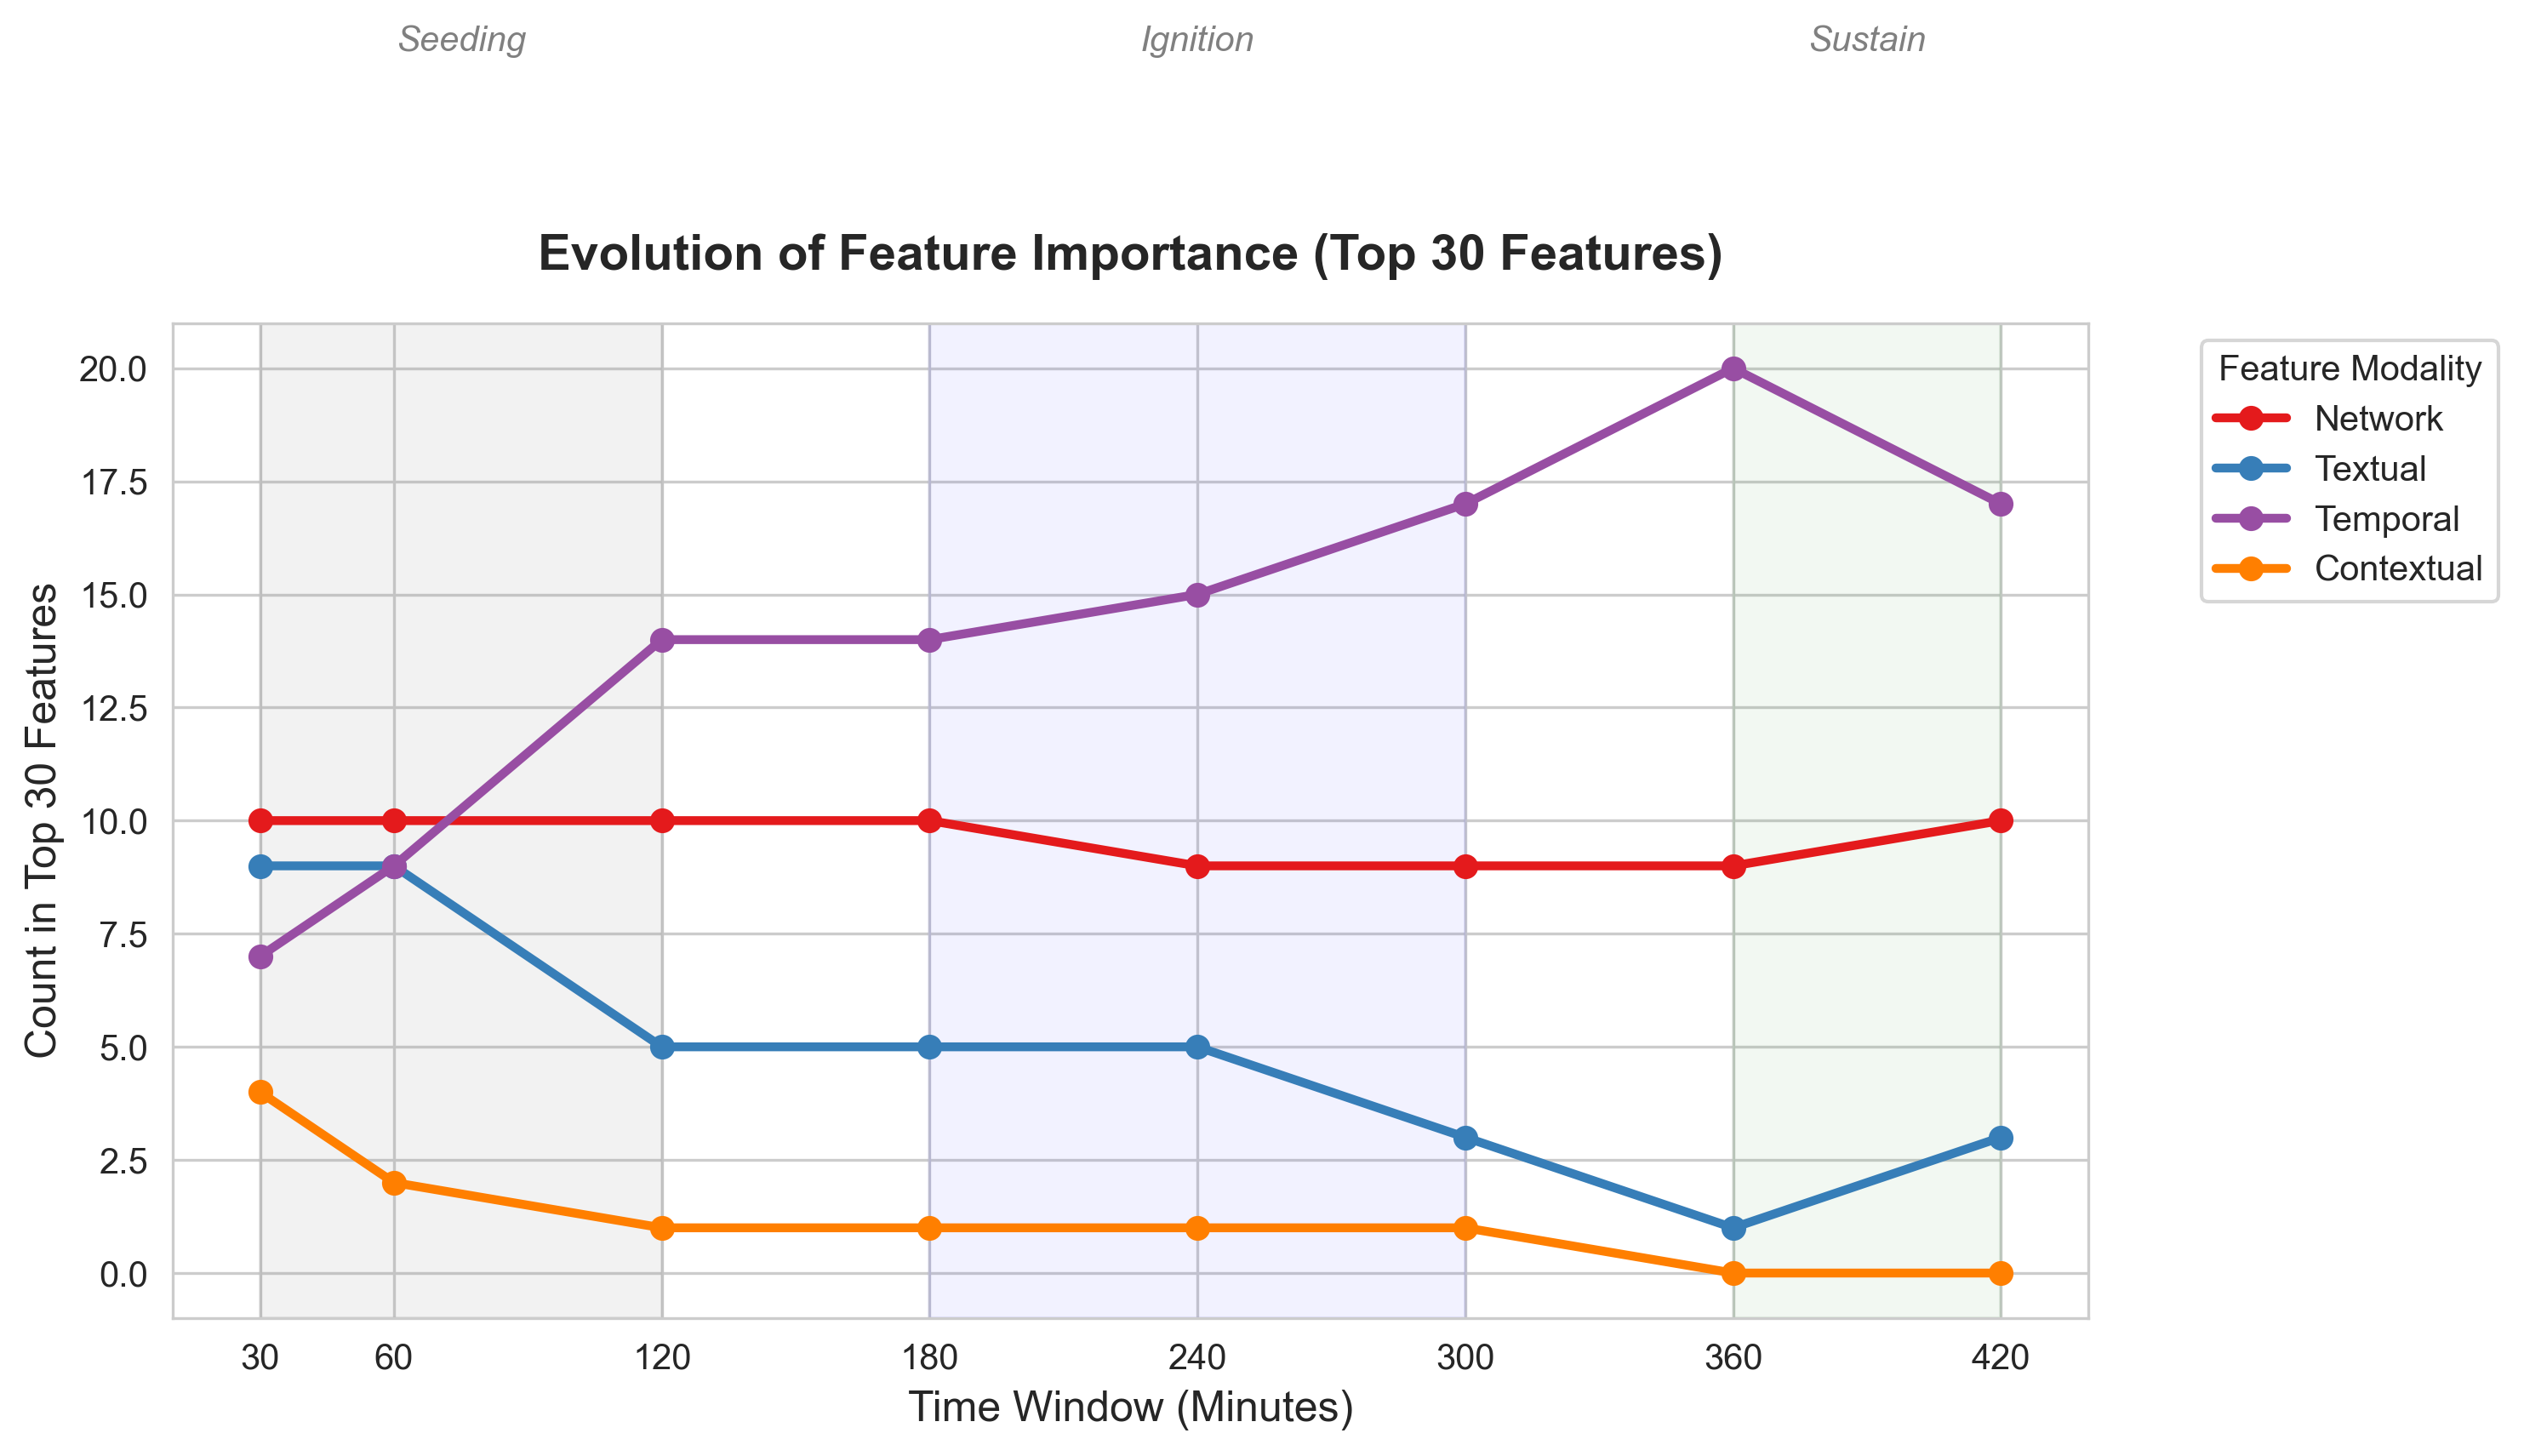

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.exceptions import NotFittedError
import xgboost as xgb
from scipy.stats import spearmanr

try:
    import shap
except ImportError:
    print("SHAP not installed. Please run 'pip install shap'.")
    exit()

# Configuration
warnings.filterwarnings('ignore')
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'

STATIC_FEATURE_DIR = DATA_DIR / 'Chapter_4'       
TEMPORAL_FEATURE_DIR = DATA_DIR / 'Chapter_5'    
TARGET_FILE_PATH = DATA_DIR / 'Chapter_3' / 'targets.csv' 

RESULTS_OUTPUT_DIR = DATA_DIR / 'Chapter_5'
RESULTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DETAILED_RESULTS_FILE = RESULTS_OUTPUT_DIR / "rq3_feature_importance_detailed.csv"
SUMMARY_RESULTS_FILE = RESULTS_OUTPUT_DIR / "rq3_modality_importance_summary.csv"
PLOT_OUTPUT_FILE = RESULTS_OUTPUT_DIR / 'modality_importance_over_time.png'

RANDOM_STATE = 42
N_SPLITS = 5
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'
TIME_WINDOWS_TO_TEST = [30, 60, 120, 180, 240, 300, 360, 420]

# Standardized colors for modalities to match academic papers
MODALITY_COLORS = {
    'Network': '#e41a1c',    # Red
    'Textual': '#377eb8',    # Blue
    'Visual': '#4daf4a',     # Green
    'Temporal': '#984ea3',   # Purple
    'Contextual': '#ff7f00'  # Orange
}

# Helper Functions: Analysis

def get_feature_names_from_preprocessor(preprocessor, numeric_cols, categorical_cols):
    try:
        cat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    except (AttributeError, KeyError, NotFittedError):
        cat_names = []
    return np.concatenate([numeric_cols, cat_names])

def get_modality_from_prefix(feature_name):
    if feature_name.startswith('visual_'): return 'Visual'
    if feature_name.startswith('textual_'): return 'Textual'
    if feature_name.startswith('contextual_'): return 'Contextual'
    if feature_name.startswith('network_'): return 'Network'
    if feature_name.startswith('temporal_'): return 'Temporal'
    if feature_name.startswith('cat__'):
        try:
            base = feature_name.split('__')[1]
            prefix = base.split('_')[0] + '_'
            if prefix == 'visual_': return 'Visual'
            if prefix == 'textual_': return 'Textual'
            if prefix == 'contextual_': return 'Contextual'
            if prefix == 'network_': return 'Network'
        except: pass
    return None

def calculate_shap_importance(X, y, numeric_features, categorical_features):
    """
    Trains XGBoost and calculates SHAP values using TimeSeriesSplit.
    """
    # Debug: Check data size
    if len(X) < N_SPLITS + 1:
        print(f"    Not enough data for TimeSeriesSplit (n={len(X)}). Needed > {N_SPLITS}")
        return pd.DataFrame()

    # XGBoost Config
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), numeric_features),
            ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
        ], remainder='passthrough')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    cv = TimeSeriesSplit(n_splits=N_SPLITS)
    
    fold_importances_list = []
    master_feature_set = set()

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        
        # Check if we have both classes
        if len(np.unique(y_train)) < 2:
            continue

        neg, pos = np.bincount(y_train)
        pipeline.set_params(classifier__scale_pos_weight=(neg / pos) if pos > 0 else 1)
        
        pipeline.fit(X_train, y_train)
        
        classifier = pipeline.named_steps['classifier']
        X_test_proc = pipeline.named_steps['preprocessor'].transform(X_test)
        
        feature_names = get_feature_names_from_preprocessor(pipeline.named_steps['preprocessor'], numeric_features, categorical_features)
        master_feature_set.update(feature_names)
        
        try:
            explainer = shap.TreeExplainer(classifier)
            shap_values = explainer.shap_values(X_test_proc)
            if isinstance(shap_values, list): shap_values = shap_values[1]
            
            fold_imps = np.abs(shap_values).mean(axis=0)
            fold_importances_list.append(dict(zip(feature_names, fold_imps)))
        except Exception as e:
            print(f"    SHAP Error: {e}")

    if not fold_importances_list: return pd.DataFrame()
    
    df_imp = pd.DataFrame(fold_importances_list).fillna(0)
    for col in master_feature_set:
        if col not in df_imp.columns: df_imp[col] = 0.0
    
    return df_imp

# Helper Functions: Plotting

def add_phase_highlights(ax, y_max):
    """Helper to add background highlights and text for phases."""
    # Phase 1: Seeding (0-120)
    ax.axvspan(30, 120, color='gray', alpha=0.1, label='_nolegend_')
    ax.text(75, y_max * 0.9, "Seeding", ha='center', fontsize=10, style='italic', color='gray')
    
    # Phase 2: Ignition (180-300)
    ax.axvspan(180, 300, color='blue', alpha=0.05, label='_nolegend_')
    ax.text(240, y_max * 0.9, "Ignition", ha='center', fontsize=10, style='italic', color='gray')
    
    # Phase 3: Sustain (360+)
    ax.axvspan(360, 420, color='green', alpha=0.05, label='_nolegend_')
    ax.text(390, y_max * 0.9, "Sustain", ha='center', fontsize=10, style='italic', color='gray')

# Main Execution Functions

def normalize_ids(series):
    """
    Normalizes ID columns by:
    1. Converting to string
    2. Stripping whitespace
    3. Removing 't3_' prefix
    4. Removing file extensions (splitting by '.')
    """
    return series.astype(str).str.strip().str.replace('t3_', '', regex=False).str.split('.').str[0]

def run_analysis():
    print("--- Starting Feature Importance & RQ3 Analysis ---")
    try:
        print("Loading target data...")
        target_df = pd.read_csv(TARGET_FILE_PATH, usecols=['id', PRIMARY_TARGET_COLUMN, 'created_utc'])
        
        # FIX: Normalize IDs robustly (remove extensions)
        target_df['id'] = normalize_ids(target_df['id'])
        print(f"Target data loaded: {len(target_df)} rows")
        
        visual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_visual_features.csv')
        textual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_textual_features.csv')
        contextual_df = pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_contextual_features.csv')
        network_df = pd.read_csv(STATIC_FEATURE_DIR / 'engineered_network_features.csv')

        df_static = target_df
        for name, df in [("Visual", visual_df), ("Textual", textual_df), ("Contextual", contextual_df), ("Network", network_df)]:
            
            # FIX: Normalize IDs in feature dataframes
            if 'id' in df.columns:
                df['id'] = normalize_ids(df['id'])
            
            df_static = pd.merge(df_static, df, on='id', how='inner')
            print(f"After merging {name}: {len(df_static)} rows")
            
            if df_static.empty:
                print(f"CRITICAL: Merging {name} resulted in 0 rows. Check ID formats in {name} file.")
                return False
            
    except Exception as e:
        print(f"Error loading static data: {e}")
        return False

    all_window_importances = []

    for window in TIME_WINDOWS_TO_TEST:
        print(f"\nAnalyzing Window: {window} minutes...")
        try:
            t_path = TEMPORAL_FEATURE_DIR / f'engineered_temporal_features_{window}min.csv'
            if not t_path.exists():
                print(f"  File not found: {t_path}")
                continue
                
            t_df = pd.read_csv(t_path)
            
            # FIX: Normalize IDs in temporal files
            t_df['id'] = normalize_ids(t_df['id'])
            
            t_df.columns = [f'temporal_{c}' if c != 'id' else c for c in t_df.columns]
            
            df_full = pd.merge(df_static, t_df, on='id', how='inner')
            
            if df_full.empty: 
                print(f"  Merge resulted in 0 rows. (Static: {len(df_static)}, Temporal: {len(t_df)})")
                continue
            
            df_use = df_full.dropna(subset=[PRIMARY_TARGET_COLUMN])
            print(f"  Data ready for SHAP: {len(df_use)} rows")
            
            if 'created_utc' in df_use.columns:
                df_use = df_use.sort_values('created_utc').reset_index(drop=True)
                
            X = df_use.drop(columns=['id', PRIMARY_TARGET_COLUMN, 'created_utc'], errors='ignore')
            y = df_use[PRIMARY_TARGET_COLUMN]
            
            num_feats = X.select_dtypes(include=np.number).columns.tolist()
            cat_feats = X.select_dtypes(exclude=np.number).columns.tolist()
            for c in cat_feats: X[c] = X[c].astype(str)
            
            imp_df = calculate_shap_importance(X, y, num_feats, cat_feats)
            if not imp_df.empty:
                imp_df['time_window'] = window
                all_window_importances.append(imp_df)
                print(f"  SHAP calculated successfully for {window} min.")
            else:
                print(f"  SHAP returned empty for {window} min.")
                
        except Exception as e:
            print(f"  Error processing {window} min: {e}")

    if not all_window_importances:
        print("No importance data generated.")
        return False

    # Aggregation & Analysis
    full_imp = pd.concat(all_window_importances, ignore_index=True)
    long_imp = full_imp.melt(id_vars=['time_window'], var_name='feature', value_name='importance')
    long_imp['modality'] = long_imp['feature'].apply(get_modality_from_prefix)
    long_imp = long_imp.dropna(subset=['modality'])

    # 1. Detailed Feature Stats
    feat_stats = long_imp.groupby(['time_window', 'modality', 'feature'])['importance'].agg(['mean', 'std']).reset_index()
    feat_stats.to_csv(DETAILED_RESULTS_FILE, index=False)
    print(f"\nSaved detailed analysis to: {DETAILED_RESULTS_FILE}")

    # 2. Modality Stats
    mod_stats = feat_stats.groupby(['time_window', 'modality'])['mean'].sum().reset_index(name='total_importance')
    mod_stats.to_csv(SUMMARY_RESULTS_FILE, index=False)

    # 3. Spearman Correlation (RQ3)
    print("\n" + "="*50)
    print("RQ3: Correlation of Modality Importance with Time")
    print("="*50)
    
    pivot_imp = mod_stats.pivot(index='time_window', columns='modality', values='total_importance').fillna(0)
    pivot_prop = pivot_imp.div(pivot_imp.sum(axis=1), axis=0)
    
    print("\nProportional Importance over Time:")
    print(pivot_prop.round(4))
    
    time_vals = pivot_prop.index.values
    for mod in pivot_prop.columns:
        vals = pivot_prop[mod].values
        res = spearmanr(time_vals, vals)
        
        sig = "Significant" if res.pvalue < 0.05 else "Not Significant"
        direction = "Positive" if res.correlation > 0 else "Negative"
        strength = "Strong" if abs(res.correlation) > 0.7 else "Weak" if abs(res.correlation) > 0.3 else "Negligible"
        
        print(f"\n{mod}: rho={res.correlation:.4f} (p={res.pvalue:.4f})")
        if res.pvalue < 0.05:
            print(f"  -> {strength} {direction} Trend")
            
    return True

def generate_plot():
    print("\n--- Generating Feature Evolution Figure (Top 30 Representation) ---")
    
    # 1. Load Data
    if not DETAILED_RESULTS_FILE.exists():
        print(f"Error: Input file not found at {DETAILED_RESULTS_FILE}")
        return

    df = pd.read_csv(DETAILED_RESULTS_FILE)
    df['modality'] = df['modality'].str.capitalize()
    
    # 2. Process Data
    print("Processing plotting data...")
    
    # Metric: Top 30 Representation (Count)
    windows = sorted(df['time_window'].unique())
    top30_data = []
    for window in windows:
        # Get top 30 features for this window
        win_top30 = df[df['time_window'] == window].sort_values('mean', ascending=False).head(30)
        counts = win_top30['modality'].value_counts().to_dict()
        row = {'time_window': window}
        row.update(counts)
        top30_data.append(row)
    
    plot_df_counts = pd.DataFrame(top30_data).set_index('time_window').fillna(0)
    
    # 3. Plotting
    print("Creating plot...")
    plt.figure(figsize=(10, 6), dpi=300)
    sns.set_style("whitegrid")
    
    # Plot Top 30 Feature Count
    for modality, color in MODALITY_COLORS.items():
        if modality in plot_df_counts.columns:
            plt.plot(plot_df_counts.index, plot_df_counts[modality], 
                     marker='o', linewidth=2.5, label=modality, color=color)
            
    plt.title('Evolution of Feature Importance (Top 30 Features)', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Time Window (Minutes)', fontsize=12)
    plt.ylabel('Count in Top 30 Features', fontsize=12)
    plt.xticks(windows)
    
    # Add phases background
    add_phase_highlights(plt.gca(), 30)

    # Legend
    plt.legend(title='Feature Modality', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    
    # 5. Save
    PLOT_OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(PLOT_OUTPUT_FILE, bbox_inches='tight')
    print(f"Figure saved successfully to: {PLOT_OUTPUT_FILE}")

def main():
    # Step 1: Run Analysis
    success = run_analysis()
    
    # Step 2: Generate Plot (only if analysis succeeded)
    if success:
        generate_plot()
    else:
        print("Analysis failed. Skipping plot generation.")

if __name__ == '__main__':
    main()

# A Dual Attention Architecture (Chapter 6)

Data Preprocessing

In [9]:
# Imports 
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import gc
import sys
import tempfile 
import os
import joblib 


# STEP 0: ENVIRONMENT CHECK AND CONFIGURATION

print("--- Step 0: Setting up Paths and Configuration ---")

# Define Paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'

# UPDATED INPUT DIRECTORIES
STATIC_FEATURE_DIR = DATA_DIR / 'Chapter_4'
TEMPORAL_FEATURE_DIR = DATA_DIR / 'Chapter_5'
TARGET_FILE_PATH = DATA_DIR / 'Chapter_3' / 'targets.csv'

# --- Define Output Directory ---
CHAPTER6_OUTPUT_DIR = DATA_DIR / 'Chapter_6'
CHAPTER6_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Experimental Settings 
RANDOM_STATE = 42
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'
# We use 'created_utc' for splitting, but drop it before training
TIMESTAMP_COL = 'created_utc' 

TIME_WINDOWS_TO_TEST = [30, 60, 120, 180, 240, 300, 360, 420]
N_TIMESTEPS = len(TIME_WINDOWS_TO_TEST)
CHUNK_SIZE = 2500

# --- Helper Functions ---
def reduce_mem_usage(df):
    """Iterate through columns, optimizing integers and categories, leaving floats as default float64."""
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category' and 'datetime' not in str(col_type):
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else: df[col] = df[col].astype(np.int64)
        # CRITICAL FIX: Added "and 'float' not in str(col_type)" to prevent floats becoming categories
        elif 'datetime' not in str(col_type) and 'float' not in str(col_type) and df[col].nunique() / len(df[col]) < 0.5:
            df[col] = df[col].astype('category')
    return df

# STEP 1: LOAD ALL RAW DATA & DISPLAY INITIAL STATS
print("\n--- Step 1: Loading All Raw Data Files ---")
try:
    print(f"Loading 'id', '{PRIMARY_TARGET_COLUMN}', and '{TIMESTAMP_COL}' from target file.")
    # Load timestamp to allow chronological splitting
    target_df = reduce_mem_usage(pd.read_csv(TARGET_FILE_PATH, usecols=['id', PRIMARY_TARGET_COLUMN, TIMESTAMP_COL]))

    #  Display target variable statistics 
    print("\n--- Step 1a: Target Variable Distribution (Overall) ---")
    target_distribution = target_df[PRIMARY_TARGET_COLUMN].value_counts()
    target_distribution_pct = target_df[PRIMARY_TARGET_COLUMN].value_counts(normalize=True) * 100
    print("Overall Target Distribution (Count):")
    print(target_distribution)
    print("\nOverall Target Distribution (%):")
    print(target_distribution_pct)

    # Load all static features from Chapter 4
    visual_df = reduce_mem_usage(pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_visual_features.csv'))
    textual_df = reduce_mem_usage(pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_textual_features.csv'))

    print("\nCorrecting data types for features misinterpreted as 'object'...")
    word_count_cols = [col for col in textual_df.columns if 'word_count' in col]
    for col in word_count_cols:
        textual_df[col] = pd.to_numeric(textual_df[col], errors='coerce')

    contextual_df = reduce_mem_usage(pd.read_csv(STATIC_FEATURE_DIR / 'preprocessed_contextual_features.csv'))
    network_df = reduce_mem_usage(pd.read_csv(STATIC_FEATURE_DIR / 'engineered_network_features.csv'))

    # Load all temporal features into a dictionary from Chapter 5
    temporal_dfs = {}
    for window in TIME_WINDOWS_TO_TEST:
        temporal_path = TEMPORAL_FEATURE_DIR / f'engineered_temporal_features_{window}min.csv'
        if not temporal_path.exists():
             raise FileNotFoundError(f"Temporal file missing: {temporal_path}")
             
        temporal_dfs[window] = reduce_mem_usage(pd.read_csv(temporal_path))
        # Ensure ID is string and remove any file extensions (e.g., .png)
        temporal_dfs[window]['id'] = temporal_dfs[window]['id'].astype(str).apply(lambda x: x.split('.')[0])

    # Merge all static features into a single base dataframe
    for df in [target_df, visual_df, textual_df, contextual_df, network_df]: 
        # Ensure ID is string and remove any file extensions (e.g., 12345.png -> 12345)
        df['id'] = df['id'].astype(str).apply(lambda x: x.split('.')[0])
        
    df_static_base = target_df
    for feature_df in [visual_df, textual_df, contextual_df, network_df]:
        df_static_base = pd.merge(df_static_base, feature_df, on='id', how='inner')

    # Get a list of all unique IDs that exist across all required files
    all_ids = df_static_base['id'].unique()

    # Sort Base DF by Time for consistency
    df_static_base.sort_values(TIMESTAMP_COL, inplace=True)

    del target_df, visual_df, textual_df, contextual_df, network_df, feature_df
    gc.collect()

except FileNotFoundError as e:
    print(f"Error: Data file not found. {e}", file=sys.stderr)
    print("Please ensure all required data CSVs are in the correct directories.", file=sys.stderr)
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}", file=sys.stderr)
    df_static_base = None
    sys.exit(1)

# STEP 2: CHRONOLOGICAL SPLIT AND PREPROCESS
if df_static_base is not None:
    print("\n--- Step 2: Splitting Data (Chronological) and Applying Preprocessing ---")

    # UPDATED: CHRONOLOGICAL SPLIT LOGIC 

    n_samples = len(df_static_base)
    train_cutoff = int(n_samples * 0.70)
    val_cutoff = int(n_samples * 0.85) # 70% + 15%
    
    train_ids = df_static_base.iloc[:train_cutoff]['id'].values
    val_ids = df_static_base.iloc[train_cutoff:val_cutoff]['id'].values
    test_ids = df_static_base.iloc[val_cutoff:]['id'].values

    print(f"Total posts: {n_samples}")
    print(f"Training posts: {len(train_ids)} (~{len(train_ids)/n_samples:.0%})")
    print(f"Validation posts: {len(val_ids)} (~{len(val_ids)/n_samples:.0%})")
    print(f"Test posts: {len(test_ids)} (~{len(test_ids)/n_samples:.0%})")

    # Display Date Ranges 
    print("\n--- Split Date Ranges ---")
    def get_date_range(series_slice):
        if len(series_slice) == 0: return "N/A"
        # Attempt to convert to datetime (assuming numeric unix timestamp or string)
        try:
            dates = pd.to_datetime(series_slice, unit='s')
        except:
            dates = pd.to_datetime(series_slice)
        return f"{dates.iloc[0]} to {dates.iloc[-1]}"

    print(f"Training:   {get_date_range(df_static_base.iloc[:train_cutoff][TIMESTAMP_COL])}")
    print(f"Validation: {get_date_range(df_static_base.iloc[train_cutoff:val_cutoff][TIMESTAMP_COL])}")
    print(f"Test:       {get_date_range(df_static_base.iloc[val_cutoff:][TIMESTAMP_COL])}")

    # Verify target distribution in each split 
    print("\n--- Verifying Target Distribution in Each Split ---")
    y_series = df_static_base.set_index('id')[PRIMARY_TARGET_COLUMN]
    
    def print_split_distribution(name, ids, y_full):
        subset = y_full.loc[ids]
        dist_pct = subset.value_counts(normalize=True) * 100
        print(f"\n{name} Set (n={len(ids)}):")
        print(f"  Positive Class: {dist_pct.get(1, 0):.2f}%")
        print(f"  Negative Class: {dist_pct.get(0, 0):.2f}%")

    print_split_distribution("Training", train_ids, y_series)
    print_split_distribution("Validation", val_ids, y_series)
    print_split_distribution("Test", test_ids, y_series)

    def assemble_and_process_split(split_name, ids, preprocessor=None):
        print(f"\n--- Assembling and processing {split_name} set ---")

        id_chunks = [ids[i:i + CHUNK_SIZE] for i in range(0, len(ids), CHUNK_SIZE)]
        processed_chunk_files = []
        temp_dir = tempfile.mkdtemp()

        for i, id_chunk in enumerate(id_chunks):
            print(f"  Processing chunk {i+1}/{len(id_chunks)} for {split_name} set...")
            static_df = df_static_base[df_static_base['id'].isin(id_chunk)]

            all_timesteps_data = []
            for window in TIME_WINDOWS_TO_TEST:
                temporal_df_filtered = temporal_dfs[window][temporal_dfs[window]['id'].isin(id_chunk)]
                
                # Merge Static + Temporal
                df_window = pd.merge(static_df, temporal_df_filtered, on='id', how='inner')
                df_window['time_window'] = window
                all_timesteps_data.append(df_window)

            if not all_timesteps_data:
                continue

            df_full = pd.concat(all_timesteps_data, ignore_index=True)
            
            # Sort by ID then Time Window to ensure sequence order (30->60->...)
            df_full.sort_values(by=['id', 'time_window'], inplace=True)

            y_chunk = df_full.drop_duplicates(subset='id').set_index('id')[PRIMARY_TARGET_COLUMN]
            
            # EXTRACT IDS 
            ids_chunk = y_chunk.index.values.astype(str)

            # Drop Target, Window, AND Timestamp from features to prevent leakage
            X_raw_chunk = df_full.drop(columns=[PRIMARY_TARGET_COLUMN, 'time_window', TIMESTAMP_COL], errors='ignore')

            if preprocessor is None:
                print("    Fitting preprocessor on first chunk of training data...")
                numeric_features = X_raw_chunk.select_dtypes(include=np.number).columns.tolist()
                categorical_features = X_raw_chunk.select_dtypes(exclude=np.number).drop(columns=['id']).columns.tolist()
                
                print(f"    -> Found {len(numeric_features)} numeric features.")
                print(f"    -> Found {len(categorical_features)} categorical features.")

                print("    Converting boolean and object columns to string for robust encoding...")
                for col in categorical_features:
                    X_raw_chunk[col] = X_raw_chunk[col].astype(str)

                preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
                        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
                    ], remainder='drop', verbose_feature_names_out=False
                )
                preprocessor.set_output(transform="pandas")
                X_processed_flat = preprocessor.fit_transform(X_raw_chunk)
                
                print(f"    -> Total features after preprocessing: {len(preprocessor.get_feature_names_out())}")
            else:
                categorical_features = X_raw_chunk.select_dtypes(exclude=np.number).drop(columns=['id']).columns.tolist()
                for col in categorical_features:
                    X_raw_chunk[col] = X_raw_chunk[col].astype(str)
                X_processed_flat = preprocessor.transform(X_raw_chunk)

            X_processed_flat['id'] = X_raw_chunk['id'].values
            unique_ids_in_chunk = X_processed_flat['id'].unique()
            y_chunk = y_chunk.loc[unique_ids_in_chunk]
            ids_chunk = ids_chunk[np.isin(ids_chunk, unique_ids_in_chunk)]

            # Reshape to (Samples, Timesteps, Features)
            processed_feature_names = preprocessor.get_feature_names_out()
            
            # Ensure extraction preserves order
            def get_sequence(df_group):
                return df_group[processed_feature_names].values
            
            X_sequential_chunk = X_processed_flat.groupby('id').apply(get_sequence)
            # Convert sequence of arrays to single 3D array
            X_sequential_chunk = np.stack(X_sequential_chunk.values).astype(np.float64)

            chunk_path = os.path.join(temp_dir, f'chunk_{split_name}_{i}.npz')
            # --- SAVE IDs ---
            np.savez_compressed(chunk_path, x=X_sequential_chunk, y=y_chunk.values, ids=ids_chunk)
            processed_chunk_files.append(chunk_path)

        all_X, all_y, all_ids = [], [], []
        for file_path in processed_chunk_files:
            with np.load(file_path) as data:
                all_X.append(data['x'])
                all_y.append(data['y'])
                all_ids.append(data['ids']) # Collect IDs
            os.remove(file_path)
        os.rmdir(temp_dir)

        if not all_X:
             print(f"Warning: No data found for {split_name} split.")
             return np.array([]), np.array([]), np.array([]), preprocessor, (0, 0)

        X_final = np.concatenate(all_X, axis=0)
        y_final = np.concatenate(all_y, axis=0)
        ids_final = np.concatenate(all_ids, axis=0) # Concatenate IDs

        return X_final, y_final, ids_final, preprocessor, (X_final.shape, y_final.shape)

    # Process each split 
    
    # 1. Train
    X_train, y_train, ids_train, preprocessor, train_shapes = assemble_and_process_split('train', train_ids)
    print(f"\nFinal shape of training features (X_train): {train_shapes[0]} (Samples, Timesteps, Features)")
    print(f"Final shape of training labels (y_train): {train_shapes[1]}")
    
    print("\nSaving preprocessor object...")
    preprocessor_path = CHAPTER6_OUTPUT_DIR / 'preprocessor.joblib'
    joblib.dump(preprocessor, preprocessor_path)
    print(f"  -> Preprocessor saved to: {preprocessor_path}")

    print("Saving preprocessed training data...")
    train_data_path = CHAPTER6_OUTPUT_DIR / 'train_data.npz'
    np.savez_compressed(train_data_path, x=X_train, y=y_train, ids=ids_train)
    print(f"  -> Training data saved to: {train_data_path}")
    
    del X_train, y_train, ids_train
    gc.collect()

    # 2. Validation
    X_val, y_val, ids_val, _, val_shapes = assemble_and_process_split('validation', val_ids, preprocessor)
    print(f"\nFinal shape of validation features (X_val): {val_shapes[0]} (Samples, Timesteps, Features)")
    print(f"Final shape of validation labels (y_val): {val_shapes[1]}")
    print("Saving preprocessed validation data...")
    val_data_path = CHAPTER6_OUTPUT_DIR / 'val_data.npz'
    np.savez_compressed(val_data_path, x=X_val, y=y_val, ids=ids_val)
    print(f"  -> Validation data saved to: {val_data_path}")
    
    del X_val, y_val, ids_val
    gc.collect()

    # 3. Test
    X_test, y_test, ids_test, _, test_shapes = assemble_and_process_split('test', test_ids, preprocessor)
    print(f"\nFinal shape of test features (X_test): {test_shapes[0]} (Samples, Timesteps, Features)")
    print(f"Final shape of test labels (y_test): {test_shapes[1]}")
    print("Saving preprocessed test data...")
    test_data_path = CHAPTER6_OUTPUT_DIR / 'test_data.npz'
    np.savez_compressed(test_data_path, x=X_test, y=y_test, ids=ids_test)
    print(f"  -> Test data saved to: {test_data_path}")
    
    del X_test, y_test, ids_test
    gc.collect()

    print("\n" + "="*80)
    print("✅ PREPROCESSING COMPLETE.")
    print(f"The following files have been generated in the '{CHAPTER6_OUTPUT_DIR}' directory:")
    print(f"  - {preprocessor_path.name}")
    print(f"  - {train_data_path.name}")
    print(f"  - {val_data_path.name}")
    print(f"  - {test_data_path.name}")
    print("You can now run the Deep Learning training script.")
    print("="*80)

--- Step 0: Setting up Paths and Configuration ---

--- Step 1: Loading All Raw Data Files ---
Loading 'id', 'is_viral_final_hybrid_score_cluster', and 'created_utc' from target file.

--- Step 1a: Target Variable Distribution (Overall) ---
Overall Target Distribution (Count):
is_viral_final_hybrid_score_cluster
0    59964
1     2979
Name: count, dtype: int64

Overall Target Distribution (%):
is_viral_final_hybrid_score_cluster
0    95.267146
1     4.732854
Name: proportion, dtype: float64

Correcting data types for features misinterpreted as 'object'...

--- Step 2: Splitting Data (Chronological) and Applying Preprocessing ---
Total posts: 46589
Training posts: 32612 (~70%)
Validation posts: 6988 (~15%)
Test posts: 6989 (~15%)

--- Split Date Ranges ---
Training:   2025-03-21 00:48:24 to 2025-05-08 13:52:10
Validation: 2025-05-08 13:58:26 to 2025-05-19 15:43:16
Test:       2025-05-19 15:44:52 to 2025-05-31 17:13:54

--- Verifying Target Distribution in Each Split ---

Training Set (n=

Dual Attention Architecture

--- Step 0: Verifying PyTorch and GPU Setup ---
✅ GPU is available and will be used: NVIDIA GeForce RTX 4070 Ti SUPER
   GPU Memory: 16.0 GB

--- Step 1: Data Preparation ---

--- Step 2: Defining Models ---

--- Step 3: Training ---

### Step 4: Comprehensive Evaluation on Test Set ###

### Step 5: Attention Analysis and Visualization ###
Loading pre-processed data from Reddit_Virality_Data\Chapter_6...
✅ Data loaded successfully:
   Training:   (32612, 8, 2709) samples
   Validation: (6988, 8, 2709) samples
   Test:       (6978, 8, 2709) samples

Feature distribution by modality:
  - contextual: 565 features
  - network: 12 features
  - temporal: 276 features
  - textual: 92 features
  - visual: 1764 features

🚀 Starting Experiment: Time Sensitive Context Aware Attention Model (Random seed and DataLoaders reset)

📊 Time Sensitive Context Aware Attention Model Statistics:
   Total parameters: 4,444,545
Starting training for 30 epochs...
Epoch 1/30 | Train Loss: 0.2177 | Val Loss: 0.12

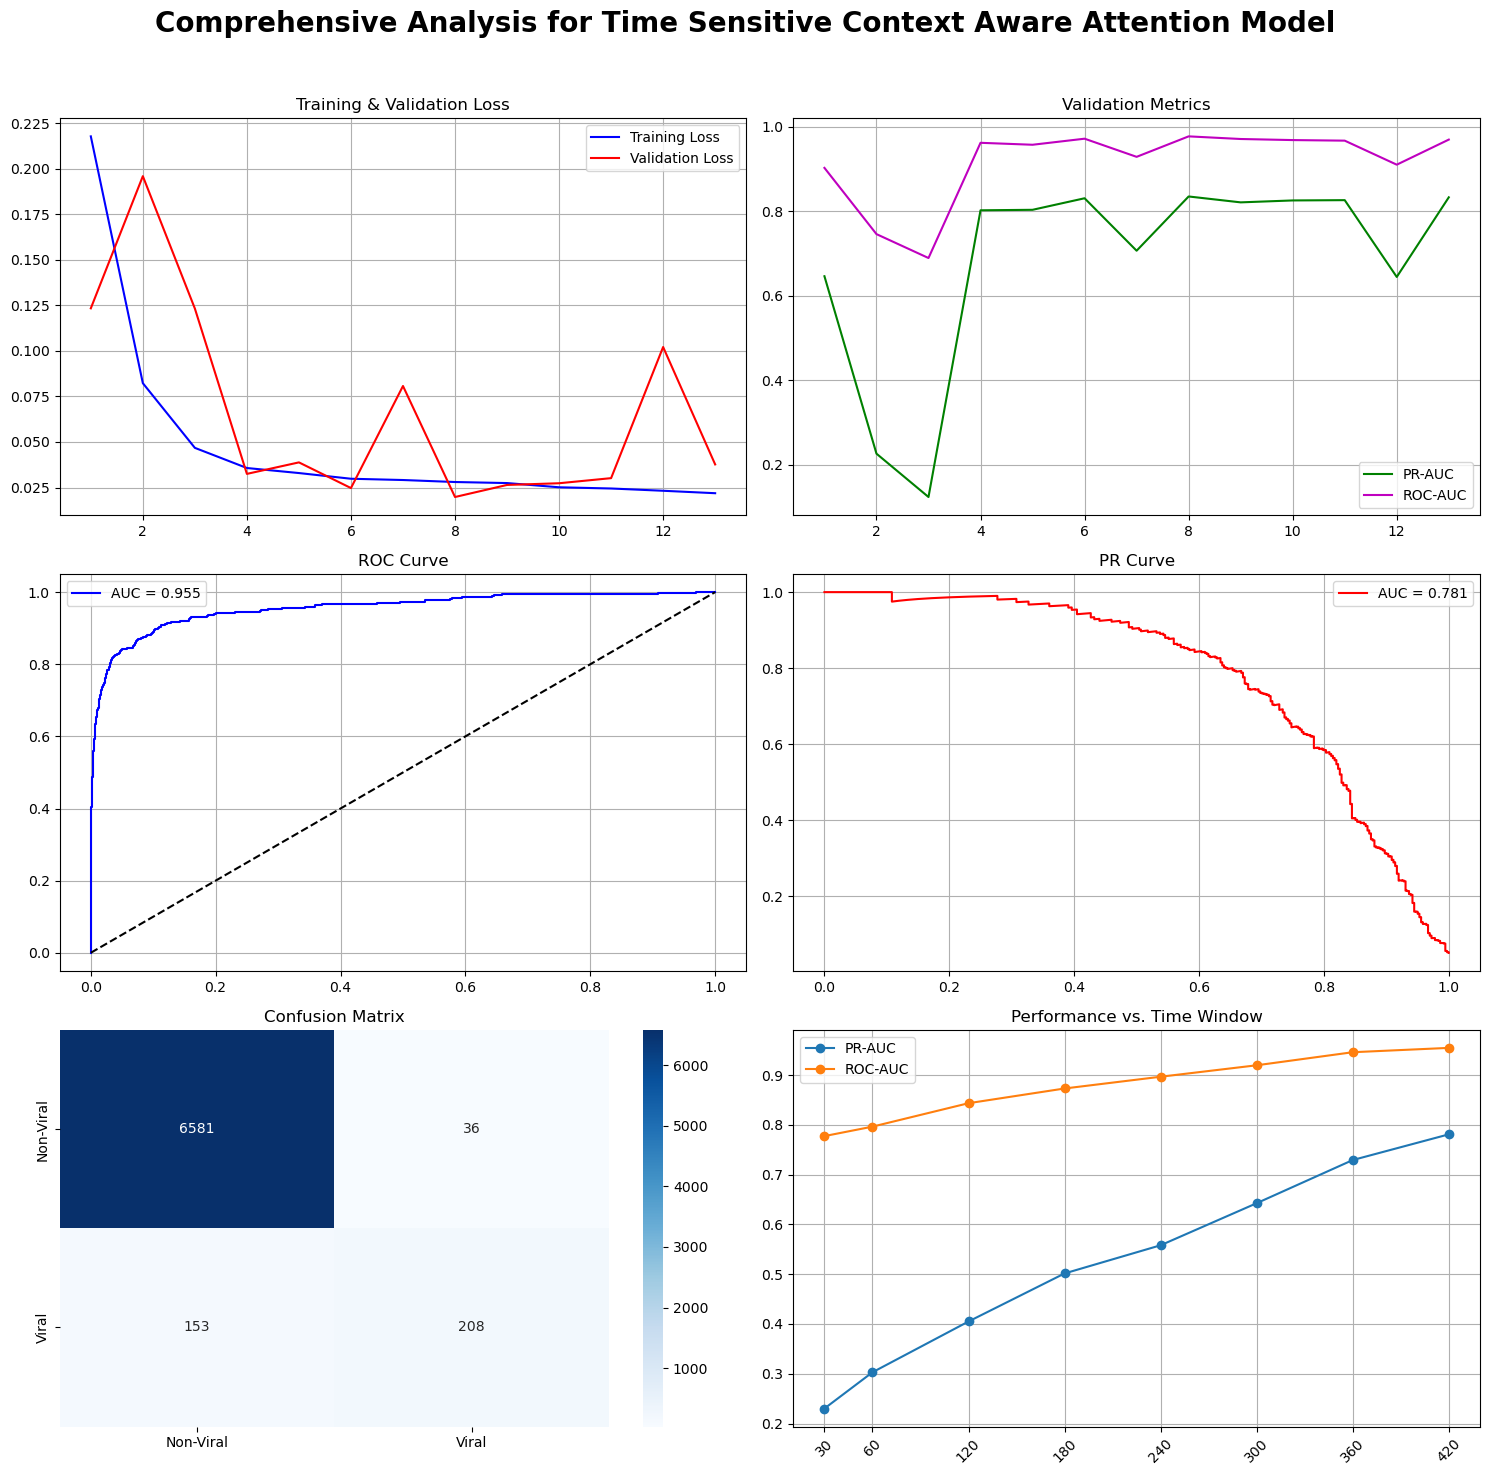


🎉 Time Sensitive Context Aware Attention Model - FINAL SUMMARY
📊 FINAL PERFORMANCE (Full Sequence):
   PR-AUC: 0.7810
   ROC-AUC: 0.9547
   F1-Score: 0.6876

💾 All results saved to: Reddit_Virality_Data\Chapter_6\results_original_attention_lstm_model

🚀 Starting Experiment: Baseline no Attention (Random seed and DataLoaders reset)

📊 Baseline no Attention Statistics:
   Total parameters: 1,302,017
Starting training for 30 epochs...
Epoch 1/30 | Train Loss: 0.0839 | Val Loss: 0.0347 | Val PR-AUC: 0.5988 | Val ROC-AUC: 0.9177
Epoch 2/30 | Train Loss: 0.0389 | Val Loss: 0.0259 | Val PR-AUC: 0.7914 | Val ROC-AUC: 0.9661
Epoch 3/30 | Train Loss: 0.0330 | Val Loss: 0.0227 | Val PR-AUC: 0.8187 | Val ROC-AUC: 0.9706
Epoch 4/30 | Train Loss: 0.0306 | Val Loss: 0.0210 | Val PR-AUC: 0.8135 | Val ROC-AUC: 0.9629
Epoch 5/30 | Train Loss: 0.0288 | Val Loss: 0.0207 | Val PR-AUC: 0.8159 | Val ROC-AUC: 0.9654
Epoch 6/30 | Train Loss: 0.0273 | Val Loss: 0.0204 | Val PR-AUC: 0.8238 | Val ROC-AUC: 0.9714

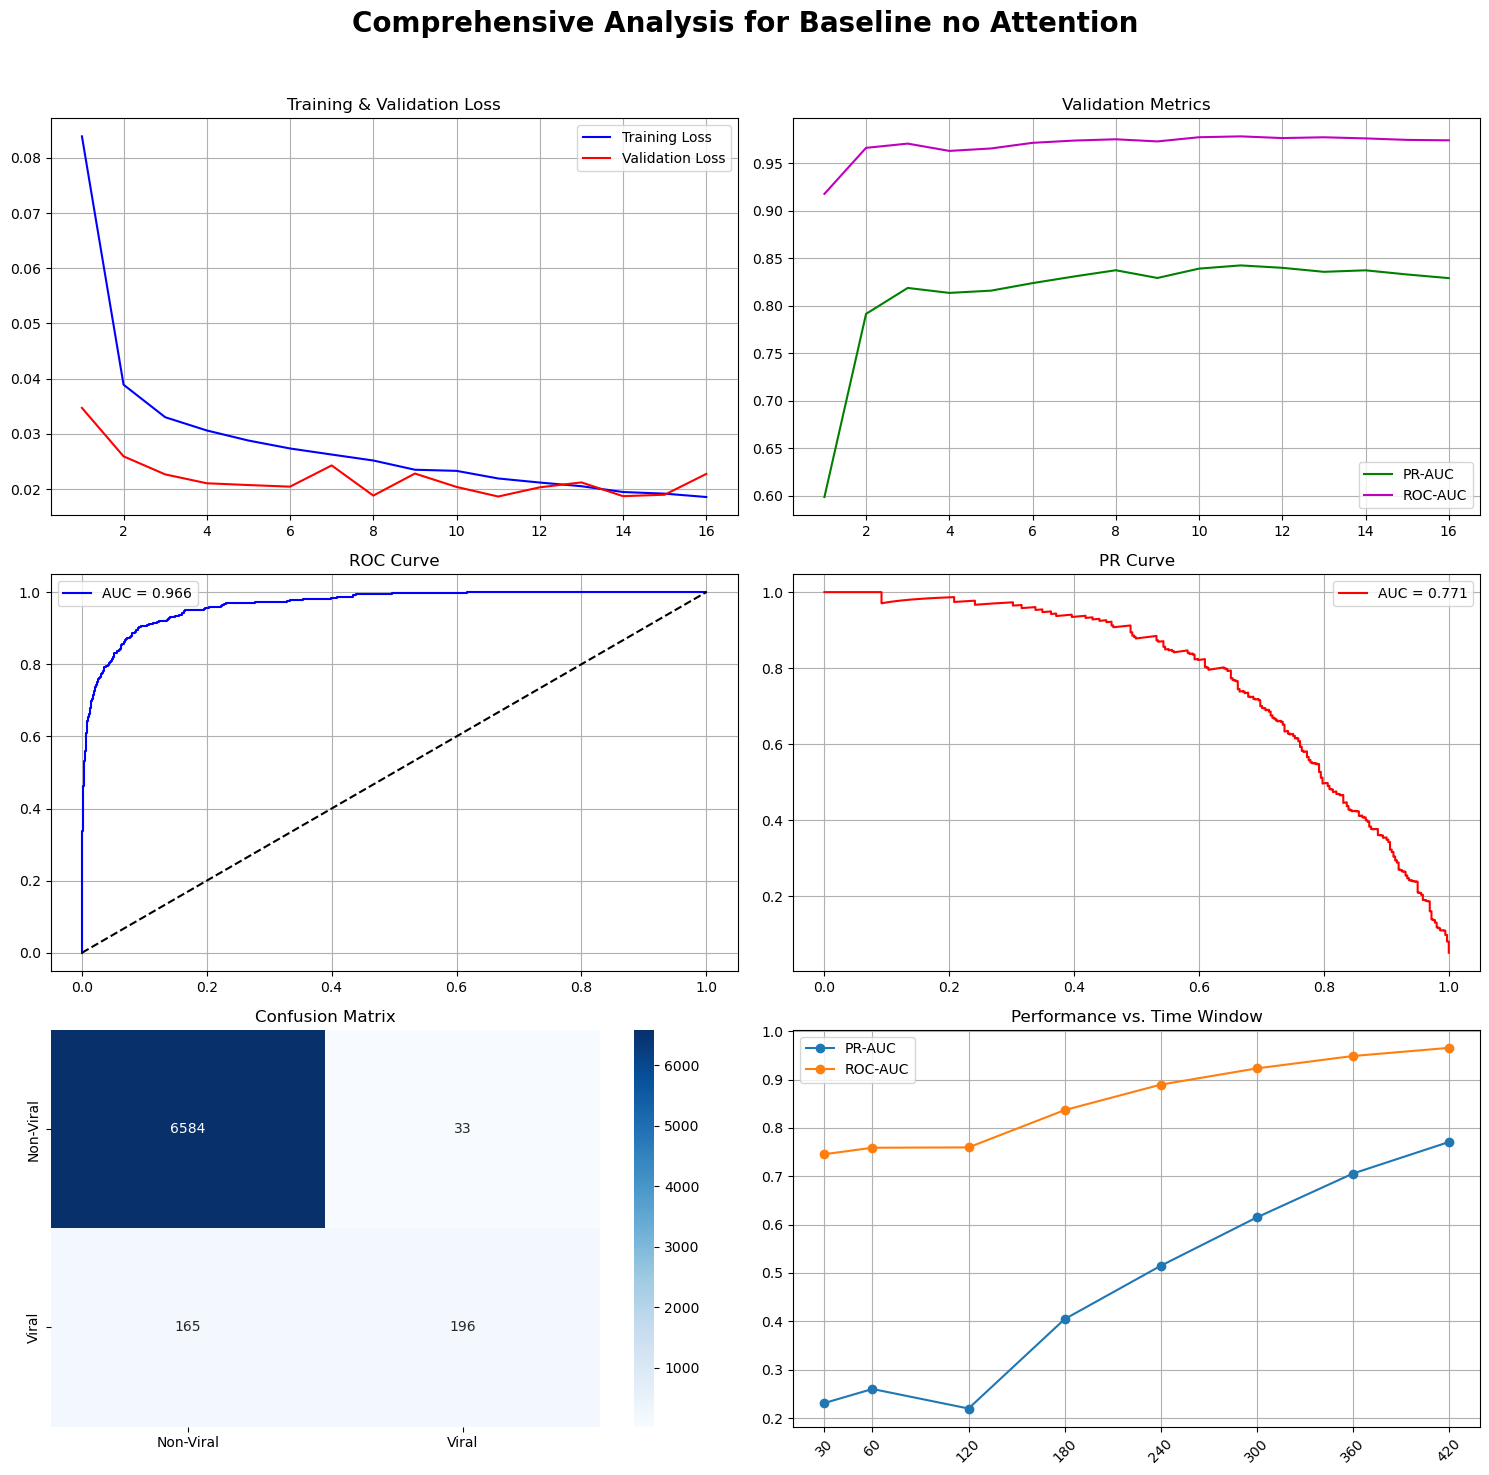


🎉 Baseline no Attention - FINAL SUMMARY
📊 FINAL PERFORMANCE (Full Sequence):
   PR-AUC: 0.7708
   ROC-AUC: 0.9656
   F1-Score: 0.6644

💾 All results saved to: Reddit_Virality_Data\Chapter_6\results_baseline_lstm_model

Creating final model comparison plot...
✅ Model comparison plot saved to: Reddit_Virality_Data\Chapter_6\model_comparison_pr_auc.png


✅ All experiments completed!


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import sys
import tempfile
import os
import math
from collections import defaultdict
import joblib
import random
import warnings
warnings.filterwarnings('ignore')

# STEP 0: GPU AND ENVIRONMENT CHECK
print("--- Step 0: Verifying PyTorch and GPU Setup ---")
is_cuda_available = torch.cuda.is_available()

if is_cuda_available:
    device = torch.device("cuda")
    print(f"✅ GPU is available and will be used: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    device = torch.device("cpu")
    print("❌ GPU not found. PyTorch will use the CPU.")

# Define Paths 
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'Reddit_Virality_Data'
# UPDATED: Path to load preprocessed data
FEATURE_DIR = DATA_DIR / 'Chapter_6' 
CHAPTER6_OUTPUT_DIR = DATA_DIR / 'Chapter_6'
# Note: Final output directory is set in the main execution block

# Experimental Settings
RANDOM_STATE = 42
PRIMARY_TARGET_COLUMN = 'is_viral_final_hybrid_score_cluster'
TIME_WINDOWS_TO_TEST = [30, 60, 120, 180, 240, 300, 360, 420]
N_TIMESTEPS = len(TIME_WINDOWS_TO_TEST)

# Hyperparameters 
BATCH_SIZE = 128
N_EPOCHS = 30
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.01
COMMON_EMBEDDING_DIM = 128
DROPOUT_RATE = 0.42
EARLY_STOPPING_PATIENCE = 5
GRADIENT_CLIP_VALUE = 1.0

# Model-Specific Hyperparameters 
# Original LSTM-Attention Model
ORIGINAL_LSTM_HIDDEN_UNITS = 256
ORIGINAL_LSTM_LAYERS = 2
# Baseline LSTM
BASELINE_LSTM_HIDDEN_UNITS = 256
BASELINE_LSTM_LAYERS = 2


# Random Seed Setting 
def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


# DATA PREPARATION
print("\n--- Step 1: Data Preparation ---")

def load_preprocessed_data():
    """
    Data loading. 
    Loads 'x' (features), 'y' (labels), AND 'ids' (for tracking).
    """
    try:
        print(f"Loading pre-processed data from {FEATURE_DIR}...")
        FEATURE_DIR.mkdir(parents=True, exist_ok=True)
        
        # Load Real Data 
        train_data = np.load(FEATURE_DIR / 'train_data.npz')
        val_data = np.load(FEATURE_DIR / 'val_data.npz')
        test_data = np.load(FEATURE_DIR / 'test_data.npz')
        preprocessor = joblib.load(FEATURE_DIR / 'preprocessor.joblib')

        # EXTRACT FEATURES, LABELS, AND IDS 
        X_train, y_train = train_data['x'], train_data['y']
        X_val, y_val = val_data['x'], val_data['y']
        
        X_test, y_test, ids_test = test_data['x'], test_data['y'], test_data['ids'] 

        print(f"✅ Data loaded successfully:")
        print(f"   Training:   {X_train.shape} samples")
        print(f"   Validation: {X_val.shape} samples")
        print(f"   Test:       {X_test.shape} samples")
        
        return X_train, X_val, X_test, y_train, y_val, y_test, ids_test, preprocessor

    except Exception as e:
        print(f"\n❌ Error loading data: {e}")
        return None

def modality_mapping(processed_feature_names):
    """Maps features to one of five core modalities based on their prefix."""
    def get_modality_from_prefix(feature_name):
        if '__' in feature_name:
            clean_name = feature_name.split('__')[-1]
        else:
            clean_name = feature_name
        if clean_name.startswith('visual_'): return 'visual'
        if clean_name.startswith('textual_'): return 'textual'
        if clean_name.startswith('contextual_'): return 'contextual'
        if clean_name.startswith('network_'): return 'network'
        if clean_name.startswith('temporal_'): return 'temporal'
        if any(keyword in clean_name for keyword in ['score', 'count', 'ratio', 'time', 'hour', 'day', 'min']): return 'temporal'
        warnings.warn(f"Feature '{clean_name}' could not be definitively mapped and was assigned to 'contextual'.", UserWarning)
        return 'contextual'
    feature_modality_map = {name: get_modality_from_prefix(name) for name in processed_feature_names}
    modality_counts = defaultdict(int)
    for modality in feature_modality_map.values(): modality_counts[modality] += 1
    print("\nFeature distribution by modality:")
    core_modalities = ['visual', 'textual', 'contextual', 'network', 'temporal']
    for modality in sorted(core_modalities):
        print(f"  - {modality}: {modality_counts[modality]} features")
    return feature_modality_map

# DATASET CLASS
class ModalityDataset(Dataset):
    """ Dataset class with better memory efficiency and data validation."""
    def __init__(self, features_dict, labels, device=None):
        self.validate_inputs(features_dict, labels)
        self.device = device or torch.device('cpu')
        self.features = {}
        for modality, data in features_dict.items():
            if data.shape[2] > 0:
                self.features[modality] = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.modalities = sorted(list(self.features.keys()))
    def validate_inputs(self, features_dict, labels):
        if not features_dict: raise ValueError("Features dictionary is empty")
        n_samples = next(iter(features_dict.values())).shape[0]
        for data in features_dict.values():
            if data.shape[0] != n_samples: raise ValueError("Inconsistent sample counts across modalities")
        if len(labels) != n_samples: raise ValueError("Labels length doesn't match feature samples")
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        sample_features = {modality: self.features[modality][idx] for modality in self.modalities}
        return sample_features, self.labels[idx].unsqueeze(-1)

# SHARED MODEL COMPONENTS
class DynamicModalityAttention(nn.Module):
    """A modality attention mechanism that uses a time-step specific query."""
    def __init__(self, common_dim):
        super(DynamicModalityAttention, self).__init__()
        self.scale = common_dim ** -0.5
    def forward(self, modality_embeddings, timestep_query):
        query = timestep_query.unsqueeze(1)
        keys = modality_embeddings.transpose(1, 2)
        scores = torch.bmm(query, keys) * self.scale
        attn_weights = F.softmax(scores, dim=-1)
        fused_representation = torch.bmm(attn_weights, modality_embeddings).squeeze(1)
        return fused_representation, attn_weights

class TemporalAttention(nn.Module):
    """ Temporal attention with multiple attention heads."""
    def __init__(self, hidden_dim, num_heads=4):
        super(TemporalAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        if hidden_dim % num_heads != 0: raise ValueError(f"hidden_dim must be divisible by num_heads")
        self.query, self.key, self.value = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
        self.attention_dropout = nn.Dropout(0.1)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, lstm_output, mask=None):
        batch_size, seq_len, hidden_dim = lstm_output.shape
        Q = self.query(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            mask_unsqueezed = mask.unsqueeze(1).unsqueeze(1)
            scores = scores.masked_fill(mask_unsqueezed == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)
        context = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_dim)
        context = self.output_projection(context)
        if mask is not None:
            mask_expanded = mask.unsqueeze(-1).expand_as(context)
            context = context * mask_expanded
            context_vector = context.sum(dim=1) / mask_expanded.sum(dim=1).clamp(min=1)
        else:
            context_vector = context.mean(dim=1)
        return context_vector, attention_weights.mean(dim=1).mean(dim=1)
        
# MODEL DEFINITIONS
print(f"\n--- Step 2: Defining Models ---")

class DualAttentionLSTM(nn.Module):
    """The original high-performing dual-attention LSTM with improved architecture."""
    def __init__(self, modality_dims, common_dim, final_lstm_hidden, n_layers, dropout):
        super(DualAttentionLSTM, self).__init__()
        self.modalities = sorted([mod for mod, dim in modality_dims.items() if dim > 0])
        self.common_dim = common_dim
        self.projection_layers = nn.ModuleDict({mod: nn.Sequential(nn.Linear(modality_dims[mod], common_dim * 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(common_dim * 2, common_dim)) for mod in self.modalities})
        self.projection_bn = nn.ModuleDict({mod: nn.BatchNorm1d(common_dim) for mod in self.modalities})
        self.timestep_query_generator = nn.Embedding(N_TIMESTEPS, common_dim)
        self.modality_fusion = DynamicModalityAttention(common_dim)
        self.final_lstm = nn.LSTM(common_dim, final_lstm_hidden, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True)
        self.temporal_attention = TemporalAttention(final_lstm_hidden * 2, num_heads=4)
        classifier_input_dim = final_lstm_hidden * 2
        self.classifier = nn.Sequential(nn.Linear(classifier_input_dim, classifier_input_dim // 2), nn.GELU(), nn.BatchNorm1d(classifier_input_dim // 2), nn.Dropout(dropout), nn.Linear(classifier_input_dim // 2, classifier_input_dim // 4), nn.GELU(), nn.Dropout(dropout), nn.Linear(classifier_input_dim // 4, 1))
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, (nn.LSTM, nn.Embedding)):
            for name, param in module.named_parameters():
                if 'weight' in name: torch.nn.init.xavier_uniform_(param.data)
                elif 'bias' in name: torch.nn.init.zeros_(param.data)

    def forward(self, x_dict, mask=None):
        batch_size, seq_len = next(iter(x_dict.values())).shape[:2]
        sequence_representations, modality_attention_weights = [], []
        for t in range(seq_len):
            timestep_modalities = [self.projection_bn[mod](self.projection_layers[mod](x_dict[mod][:, t, :])) for mod in self.modalities]
            stacked_modalities = torch.stack(timestep_modalities, dim=1)
            current_timestep_idx = torch.tensor([t], device=x_dict[self.modalities[0]].device).expand(batch_size)
            timestep_query = self.timestep_query_generator(current_timestep_idx)
            fused_representation, attention_weights = self.modality_fusion(stacked_modalities, timestep_query)
            sequence_representations.append(fused_representation)
            modality_attention_weights.append(attention_weights)
        sequence = torch.stack(sequence_representations, dim=1)
        lstm_out, _ = self.final_lstm(sequence)
        final_context, temporal_weights = self.temporal_attention(lstm_out, mask)
        output = self.classifier(final_context)
        modality_weights = torch.stack(modality_attention_weights, dim=1)
        return output, (modality_weights, temporal_weights)

class BaselineLSTM(nn.Module):
    """A simpler baseline model using an LSTM without any attention mechanisms."""
    def __init__(self, modality_dims, common_dim, hidden_dim, n_layers, dropout):
        super(BaselineLSTM, self).__init__()
        self.modalities = sorted([mod for mod, dim in modality_dims.items() if dim > 0])
        self.common_dim = common_dim
        self.projection_layers = nn.ModuleDict({mod: nn.Sequential(nn.Linear(modality_dims[mod], common_dim), nn.GELU(), nn.Dropout(dropout)) for mod in self.modalities})
        self.lstm = nn.LSTM(common_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.classifier = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(hidden_dim // 2, 1))
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name: torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name: torch.nn.init.zeros_(param)

    def forward(self, x_dict, mask=None):
        batch_size, seq_len = next(iter(x_dict.values())).shape[:2]
        sequence_representations = []
        for t in range(seq_len):
            timestep_modalities = [self.projection_layers[mod](x_dict[mod][:, t, :]) for mod in self.modalities]
            stacked_modalities = torch.stack(timestep_modalities, dim=1)
            # Fuse by simple averaging instead of attention
            fused_representation = torch.mean(stacked_modalities, dim=1)
            sequence_representations.append(fused_representation)
        sequence = torch.stack(sequence_representations, dim=1)
        lstm_out, _ = self.lstm(sequence)
        
        if mask is not None:
            last_valid_idx = (mask.sum(dim=1) - 1).long()
            final_context = lstm_out[torch.arange(batch_size), last_valid_idx]
        else:
            final_context = lstm_out[:, -1, :]
        
        output = self.classifier(final_context)
        return output, (None, None) # No attention weights to return

# TRAINING 
print("\n--- Step 3: Training ---")
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2): super(FocalLoss, self).__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets): bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none'); pt = torch.exp(-bce_loss); return (self.alpha * (1 - pt) ** self.gamma * bce_loss).mean()

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True): self.patience, self.min_delta, self.restore_best_weights, self.best_loss, self.counter, self.best_weights = patience, min_delta, restore_best_weights, None, 0, None
    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta: self.best_loss, self.counter = val_loss, 0; self.save_checkpoint(model)
        else: self.counter += 1
        return self.counter >= self.patience
    def save_checkpoint(self, model):
        if self.restore_best_weights: self.best_weights = model.state_dict().copy()

def train_model(model, train_loader, val_loader, device):
    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=N_EPOCHS, steps_per_epoch=len(train_loader), pct_start=0.1, anneal_strategy='cos')
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
    history = {'train_loss': [], 'val_loss': [], 'val_pr_auc': [], 'val_roc_auc': [], 'learning_rate': []}
    print(f"Starting training for {N_EPOCHS} epochs...")
    for epoch in range(N_EPOCHS):
        model.train()
        train_loss = 0.0
        for data_dict, labels in train_loader:
            inputs, labels = {mod: tensor.to(device) for mod, tensor in data_dict.items()}, labels.to(device)
            mask = torch.ones(labels.shape[0], N_TIMESTEPS).to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        model.eval()
        val_loss, all_val_labels, all_val_preds = 0.0, [], []
        with torch.no_grad():
            for data_dict, labels in val_loader:
                inputs, labels = {mod: tensor.to(device) for mod, tensor in data_dict.items()}, labels.to(device)
                mask = torch.ones(labels.shape[0], N_TIMESTEPS).to(device)
                outputs, _ = model(inputs, mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
        avg_train_loss, avg_val_loss = train_loss / len(train_loader), val_loss / len(val_loader)
        val_pr_auc, val_roc_auc = average_precision_score(all_val_labels, all_val_preds), roc_auc_score(all_val_labels, all_val_preds)
        history['train_loss'].append(avg_train_loss); history['val_loss'].append(avg_val_loss); history['val_pr_auc'].append(val_pr_auc); history['val_roc_auc'].append(val_roc_auc); history['learning_rate'].append(scheduler.get_last_lr()[0])
        print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val PR-AUC: {val_pr_auc:.4f} | Val ROC-AUC: {val_roc_auc:.4f}")
        if early_stopping(avg_val_loss, model): print(f"Early stopping at epoch {epoch+1}"); break
    if early_stopping.best_weights: model.load_state_dict(early_stopping.best_weights); print("✅ Best model weights restored")
    return history

# COMPREHENSIVE EVALUATION (UPDATED TO SNAPSHOT 120 MINS)
print("\n" + "="*80)
print("### Step 4: Comprehensive Evaluation on Test Set ###")

def comprehensive_evaluation(model, test_loader, device):
    """Evaluates model performance across time windows and snapshots the 120-min predictions."""
    print("Running comprehensive evaluation across different time windows...")
    model.eval()
    results_over_time = []
    all_temporal_weights = []
    
    # Store 120-min predictions here
    predictions_at_120min = None

    for t_idx, time_window in enumerate(TIME_WINDOWS_TO_TEST):
        num_timesteps_to_use = t_idx + 1
        print(f"\n--- Evaluating with data up to {time_window} min ({num_timesteps_to_use}/{N_TIMESTEPS} timesteps) ---")
        
        all_test_labels, all_test_probs = [], []
        modality_attention_this_window, temporal_attention_this_window = [], []
        
        with torch.no_grad():
            for data_dict, labels in test_loader:
                inputs = {mod: tensor.clone().to(device) for mod, tensor in data_dict.items()}
                labels = labels.to(device)
                
                # Mask out future data (beyond current window)
                eval_mask = torch.zeros(labels.shape[0], N_TIMESTEPS, device=device)
                eval_mask[:, :num_timesteps_to_use] = 1.0
                feature_mask = eval_mask.unsqueeze(-1)
                
                for mod in inputs: inputs[mod] = inputs[mod] * feature_mask
                
                outputs, (modality_weights, temporal_weights) = model(inputs, eval_mask)
                probs = torch.sigmoid(outputs)
                
                all_test_labels.extend(labels.cpu().numpy().flatten())
                all_test_probs.extend(probs.cpu().numpy().flatten())
                
                if modality_weights is not None: modality_attention_this_window.append(modality_weights.cpu().numpy())
                if temporal_weights is not None: temporal_attention_this_window.append(temporal_weights.cpu().numpy())

        test_labels, test_probs = np.array(all_test_labels), np.array(all_test_probs)
        test_preds = (test_probs > 0.5).astype(int)
        
        # Calculate Metrics
        pr_auc = average_precision_score(test_labels, test_probs)
        roc_auc = roc_auc_score(test_labels, test_probs)
        f1 = f1_score(test_labels, test_preds, zero_division=0)
        print(f"  PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}")
        
        result_entry = {'time_window': time_window, 'pr_auc': pr_auc, 'roc_auc': roc_auc, 'f1': f1}
        
        if modality_attention_this_window:
            full_modality_attention = np.concatenate(modality_attention_this_window, axis=0)
            avg_mod_attn_for_window = np.mean(full_modality_attention[:, :num_timesteps_to_use, :], axis=(0,1))
            result_entry['modality_attention'] = {name: float(imp) for name, imp in zip(sorted(model.modalities), avg_mod_attn_for_window.flatten())}
        
        if temporal_attention_this_window:
            full_temporal_attention = np.concatenate(temporal_attention_this_window, axis=0)
            all_temporal_weights.append(full_temporal_attention)

        results_over_time.append(result_entry)
        
        # CAPTURE 120-MINUTE PREDICTIONS
        if time_window == 120:
            print("  📸 SNAPSHOT: Captured 120-minute predictions for later analysis.")
            predictions_at_120min = {
                'probs': test_probs,
                'preds': test_preds,
                'labels': test_labels
            }

    class_report = classification_report(test_labels, test_preds, target_names=['Non-Viral', 'Viral'], output_dict=True, zero_division=0)
    final_temporal_weights = all_temporal_weights[-1] if all_temporal_weights else None

    return {
        'results_over_time': results_over_time, 
        'final_full_sequence_results': results_over_time[-1], 
        'test_labels': test_labels, # This is the final (420m) labels
        'test_probs': test_probs,   # This is the final (420m) probs
        'test_preds': test_preds,   # This is the final (420m) preds
        'predictions_at_120min': predictions_at_120min, # <--- NEW RETURN
        'final_temporal_weights': final_temporal_weights
    }
# ATTENTION ANALYSIS AND VISUALIZATION
print("\n" + "="*80)
print("### Step 5: Attention Analysis and Visualization ###")

def analyze_attention_patterns(evaluation_summary, model_name):
    """Analyzes and prints attention patterns from the full-sequence evaluation."""
    print("Analyzing attention patterns...")
    analysis = {}
    
    # Analyze Modality Attention
    if evaluation_summary['results_over_time'] and 'modality_attention' in evaluation_summary['results_over_time'][0]:
        modality_attention_df = pd.DataFrame([{'time_window': r['time_window'], **r['modality_attention']} for r in evaluation_summary['results_over_time']]).set_index('time_window')
        print("\n" + "-"*60 + f"\nModality Attention Weights Over Time ({model_name})\n" + "-"*60)
        print(modality_attention_df.round(4))
        analysis['modality_attention_over_time'] = modality_attention_df
    else:
        print("No modality attention data found. Skipping analysis.")
        analysis['modality_attention_over_time'] = pd.DataFrame()

    # Analyze Temporal Attention
    if evaluation_summary.get('final_temporal_weights') is not None:
        avg_temporal_weights = np.mean(evaluation_summary['final_temporal_weights'], axis=0)
        analysis['average_temporal_attention'] = avg_temporal_weights
        print("\n" + "-"*60 + f"\nAverage Temporal Attention Weights ({model_name})\n" + "-"*60)
        for i, weight in enumerate(avg_temporal_weights):
            print(f"  Time Step {i+1} ({TIME_WINDOWS_TO_TEST[i]} min): {weight:.4f}")
    else:
        analysis['average_temporal_attention'] = None
        
    return analysis

def save_plot(fig, path, dpi=300):
    """Helper function to save a plot."""
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    plt.close(fig)

def create_and_save_visualizations(training_history, evaluation_summary, attention_analysis, model_name, results_output_dir):
    """Creates and saves each plot as a separate PNG file."""
    print(f"Creating and saving individual visualizations for {model_name}...")
    from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

    # Plot 1: Training & Validation Loss 
    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = range(1, len(training_history['train_loss']) + 1)
    ax.plot(epochs, training_history['train_loss'], 'b-', label='Training Loss')
    ax.plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss')
    ax.set_title(f'Training & Validation Loss\n({model_name})')
    ax.legend(); ax.grid(True)
    save_plot(fig, results_output_dir / '1_training_loss.png')

    # Plot 2: Validation Metrics 
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs, training_history['val_pr_auc'], 'g-', label='PR-AUC')
    ax.plot(epochs, training_history['val_roc_auc'], 'm-', label='ROC-AUC')
    ax.set_title(f'Validation Metrics\n({model_name})')
    ax.legend(); ax.grid(True)
    save_plot(fig, results_output_dir / '2_validation_metrics.png')

    # Plot 3: Learning Rate Schedule 
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs, training_history['learning_rate'], 'orange')
    ax.set_title(f'Learning Rate Schedule\n({model_name})')
    ax.set_yscale('log'); ax.grid(True)
    save_plot(fig, results_output_dir / '3_learning_rate.png')

    test_labels, test_probs, test_preds = evaluation_summary['test_labels'], evaluation_summary['test_probs'], evaluation_summary['test_preds']
    final_roc_auc, final_pr_auc = evaluation_summary['final_full_sequence_results']['roc_auc'], evaluation_summary['final_full_sequence_results']['pr_auc']

    # Plot 4: ROC Curve 
    fig, ax = plt.subplots(figsize=(8, 5))
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    ax.plot(fpr, tpr, 'b-', label=f'AUC = {final_roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(f'ROC Curve\n({model_name})')
    ax.legend(); ax.grid(True)
    save_plot(fig, results_output_dir / '4_roc_curve.png')

    # Plot 5: PR Curve 
    fig, ax = plt.subplots(figsize=(8, 5))
    precision, recall, _ = precision_recall_curve(test_labels, test_probs)
    ax.plot(recall, precision, 'r-', label=f'AUC = {final_pr_auc:.3f}')
    ax.set_title(f'PR Curve\n({model_name})')
    ax.legend(); ax.grid(True)
    save_plot(fig, results_output_dir / '5_pr_curve.png')

    # Plot 6: Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 5))
    cm = confusion_matrix(test_labels, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'], ax=ax)
    ax.set_title(f'Confusion Matrix\n({model_name})')
    save_plot(fig, results_output_dir / '6_confusion_matrix.png')
    
    # Plot 7 & 8: Attention Plots
    if not attention_analysis['modality_attention_over_time'].empty:
        fig, ax = plt.subplots(figsize=(8, 5))
        mod_attn_df = attention_analysis['modality_attention_over_time']
        avg_mod_importance = mod_attn_df.mean(axis=0)
        sns.barplot(x=avg_mod_importance.index, y=avg_mod_importance.values, palette="husl", ax=ax)
        ax.set_title(f'Average Modality Importance\n({model_name})')
        ax.tick_params(axis='x', rotation=45)
        save_plot(fig, results_output_dir / '7_avg_modality_importance.png')
        
        fig, ax = plt.subplots(figsize=(8, 5))
        mod_attn_df_melted = mod_attn_df.reset_index().melt(id_vars='time_window', var_name='modality', value_name='attention')
        sns.lineplot(data=mod_attn_df_melted, x='time_window', y='attention', hue='modality', marker='o', ax=ax)
        ax.set_title(f'Modality Attention Over Time\n({model_name})')
        ax.set_xticks(TIME_WINDOWS_TO_TEST)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Modality')
        save_plot(fig, results_output_dir / '8_modality_attention_over_time.png')
        
    if attention_analysis.get('average_temporal_attention') is not None:
        fig, ax = plt.subplots(figsize=(8, 5))
        temporal_weights = attention_analysis['average_temporal_attention']
        sns.barplot(x=TIME_WINDOWS_TO_TEST, y=temporal_weights, palette="viridis", ax=ax)
        ax.set_title(f'Average Temporal Attention\n({model_name})')
        ax.set_xlabel('Time Since Post (minutes)')
        ax.set_ylabel('Average Attention Weight')
        save_plot(fig, results_output_dir / '9_avg_temporal_attention.png')

    # Final Plot: Performance Over Time
    fig, ax = plt.subplots(figsize=(8, 5))
    results_df = pd.DataFrame(evaluation_summary['results_over_time'])
    ax.plot(results_df['time_window'], results_df['pr_auc'], 'o-', label='PR-AUC')
    ax.plot(results_df['time_window'], results_df['roc_auc'], 'o-', label='ROC-AUC')
    ax.set_title(f'Performance vs. Time Window\n({model_name})')
    ax.set_xticks(TIME_WINDOWS_TO_TEST)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(); ax.grid(True)
    save_plot(fig, results_output_dir / '10_performance_over_time.png')
    print(f"✅ All visualizations for {model_name} saved to {results_output_dir}")

def display_combined_visualizations(training_history, evaluation_summary, attention_analysis, model_name):
    """Creates and displays a single figure with all plots for console output."""
    print(f"Displaying combined visualization for {model_name}...")
    from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 15)) # Changed to 3x2 grid
    fig.suptitle(f'Comprehensive Analysis for {model_name}', fontsize=20, fontweight='bold')
    
    epochs = range(1, len(training_history['train_loss']) + 1)
    
    # Row 1
    axes[0, 0].plot(epochs, training_history['train_loss'], 'b-', label='Training Loss'); axes[0, 0].plot(epochs, training_history['val_loss'], 'r-', label='Validation Loss'); axes[0, 0].set_title('Training & Validation Loss'); axes[0, 0].legend(); axes[0, 0].grid(True)
    axes[0, 1].plot(epochs, training_history['val_pr_auc'], 'g-', label='PR-AUC'); axes[0, 1].plot(epochs, training_history['val_roc_auc'], 'm-', label='ROC-AUC'); axes[0, 1].set_title('Validation Metrics'); axes[0, 1].legend(); axes[0, 1].grid(True)
    
    # Row 2
    test_labels, test_probs, test_preds = evaluation_summary['test_labels'], evaluation_summary['test_probs'], evaluation_summary['test_preds']
    final_roc_auc, final_pr_auc = evaluation_summary['final_full_sequence_results']['roc_auc'], evaluation_summary['final_full_sequence_results']['pr_auc']
    fpr, tpr, _ = roc_curve(test_labels, test_probs); axes[1, 0].plot(fpr, tpr, 'b-', label=f'AUC = {final_roc_auc:.3f}'); axes[1, 0].plot([0, 1], [0, 1], 'k--'); axes[1, 0].set_title('ROC Curve'); axes[1, 0].legend(); axes[1, 0].grid(True)
    precision, recall, _ = precision_recall_curve(test_labels, test_probs); axes[1, 1].plot(recall, precision, 'r-', label=f'AUC = {final_pr_auc:.3f}'); axes[1, 1].set_title('PR Curve'); axes[1, 1].legend(); axes[1, 1].grid(True)
    
    # Row 3
    cm = confusion_matrix(test_labels, test_preds); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Viral', 'Viral'], yticklabels=['Non-Viral', 'Viral'], ax=axes[2, 0]); axes[2, 0].set_title('Confusion Matrix')
    results_df = pd.DataFrame(evaluation_summary['results_over_time']); axes[2, 1].plot(results_df['time_window'], results_df['pr_auc'], 'o-', label='PR-AUC'); axes[2, 1].plot(results_df['time_window'], results_df['roc_auc'], 'o-', label='ROC-AUC'); axes[2, 1].set_title('Performance vs. Time Window'); axes[2, 1].legend(); axes[2, 1].grid(True); axes[2, 1].set_xticks(TIME_WINDOWS_TO_TEST); axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def create_comparison_plot(all_results, base_dir):
    """Creates and saves a plot comparing the PR-AUC of all models over time."""
    print("\nCreating final model comparison plot...")
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model_name, results in all_results.items():
        results_df = pd.DataFrame(results['results_over_time'])
        ax.plot(results_df['time_window'], results_df['pr_auc'], 'o-', label=f'{model_name}')

    ax.set_title('Model PR-AUC Comparison Over Time')
    ax.set_xlabel('Time Since Post (minutes)')
    ax.set_ylabel('PR-AUC Score')
    ax.set_xticks(TIME_WINDOWS_TO_TEST)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True)
    
    comparison_path = base_dir / 'model_comparison_pr_auc.png'
    save_plot(fig, comparison_path)
    print(f"✅ Model comparison plot saved to: {comparison_path}")


# MAIN EXECUTION BLOCK
if __name__ == '__main__':
    data_result = load_preprocessed_data()
    if data_result is None:
        sys.exit(1)
    
    # UNPACK VARIABLES
    X_train, X_val, X_test, y_train, y_val, y_test, ids_test, preprocessor = data_result
    
    # Handle feature names
    try:
        processed_feature_names = preprocessor.get_feature_names_out()
    except Exception:
        processed_feature_names = [f"feature_{i}" for i in range(X_train.shape[2])]
        
    # Map features to modalities
    feature_modality_map = modality_mapping(processed_feature_names)
    modality_indices = defaultdict(list)
    for i, name in enumerate(processed_feature_names):
        modality_indices[feature_modality_map[name]].append(i)
        
    # Split tensors by modality
    X_train_dict = {mod: X_train[:, :, indices] for mod, indices in modality_indices.items()}
    X_val_dict = {mod: X_val[:, :, indices] for mod, indices in modality_indices.items()}
    X_test_dict = {mod: X_test[:, :, indices] for mod, indices in modality_indices.items()}
    
    modality_dims = {mod: data.shape[2] for mod, data in X_train_dict.items()}

    # Define Model Configurations
    model_configs = [
        {
            'name': 'Original_Attention_LSTM',
            'plot_name': 'Time Sensitive Context Aware Attention Model',
            'class': DualAttentionLSTM,
            'args': {
                'modality_dims': modality_dims,
                'common_dim': COMMON_EMBEDDING_DIM,
                'final_lstm_hidden': ORIGINAL_LSTM_HIDDEN_UNITS,
                'n_layers': ORIGINAL_LSTM_LAYERS,
                'dropout': DROPOUT_RATE
            }
        },
        {
            'name': 'Baseline_LSTM',
            'plot_name': 'Baseline no Attention',
            'class': BaselineLSTM,
            'args': {
                'modality_dims': modality_dims,
                'common_dim': COMMON_EMBEDDING_DIM,
                'hidden_dim': BASELINE_LSTM_HIDDEN_UNITS,
                'n_layers': BASELINE_LSTM_LAYERS,
                'dropout': DROPOUT_RATE
            }
        }
    ]
    
    all_experiment_results = {}
    MAIN_RESULTS_DIR = CHAPTER6_OUTPUT_DIR
    MAIN_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    for config in model_configs:
        model_name_for_files = config['name']
        model_name_for_plots = config['plot_name']
        
        # Reset seed and re-create DataLoaders for isolation
        set_seed(RANDOM_STATE)
        print(f"\n{'='*80}\n🚀 Starting Experiment: {model_name_for_plots} (Random seed and DataLoaders reset)\n{'='*80}")
        
        train_dataset = ModalityDataset(X_train_dict, y_train)
        val_dataset = ModalityDataset(X_val_dict, y_val)
        test_dataset = ModalityDataset(X_test_dict, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=is_cuda_available)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=is_cuda_available)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=is_cuda_available)
        
        RESULTS_OUTPUT_DIR = MAIN_RESULTS_DIR / f'results_{model_name_for_files.lower()}_model'
        RESULTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

        model = config['class'](**config['args']).to(device)
        print(f"\n📊 {model_name_for_plots} Statistics:\n   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        training_history = train_model(model, train_loader, val_loader, device)
        
        model_path = RESULTS_OUTPUT_DIR / f'{model_name_for_files.lower()}_model.pth'
        torch.save(model.state_dict(), model_path)
        print(f"✅ {model_name_for_plots} model saved to: {model_path}")
        
        # COMPREHENSIVE EVALUATION
        evaluation_summary = comprehensive_evaluation(model, test_loader, device)
        attention_analysis = analyze_attention_patterns(evaluation_summary, model_name_for_plots)
        
        # ✅ SAVE PREDICTIONS: 420 MIN (FINAL) & 120 MIN (SNAPSHOT)
        print(f"Generating prediction CSVs for {model_name_for_plots}...")
        
        # 1. Save Final (420m) Predictions
        final_probs = evaluation_summary['test_probs']
        final_preds = evaluation_summary['test_preds']
        final_labels = evaluation_summary['test_labels']
        
        min_len = min(len(ids_test), len(final_probs))
        
        df_420 = pd.DataFrame({
            'id': ids_test[:min_len],
            'true_label': final_labels[:min_len],
            'pred_prob': final_probs[:min_len],
            'pred_label': final_preds[:min_len]
        })
        path_420 = RESULTS_OUTPUT_DIR / f'{model_name_for_files.lower()}_predictions_420min.csv'
        df_420.to_csv(path_420, index=False)
        print(f"✅ Saved Final (420m) Predictions: {path_420.name}")

        # 2. Save Snapshot (120m) Predictions
        snapshot_120 = evaluation_summary.get('predictions_at_120min')
        if snapshot_120 is not None:
            probs_120 = snapshot_120['probs'][:min_len]
            preds_120 = snapshot_120['preds'][:min_len]
            
            df_120 = pd.DataFrame({
                'id': ids_test[:min_len],
                'true_label': final_labels[:min_len], # Label is same
                'pred_prob': probs_120,
                'pred_label': preds_120
            })
            path_120 = RESULTS_OUTPUT_DIR / f'{model_name_for_files.lower()}_predictions_120min.csv'
            df_120.to_csv(path_120, index=False)
            print(f"✅ Saved Snapshot (120m) Predictions: {path_120.name}")
        else:
            print("⚠️ Warning: No 120-minute snapshot found (Check TIME_WINDOWS_TO_TEST list).")
            
        # Visualizations
        create_and_save_visualizations(training_history, evaluation_summary, attention_analysis, model_name_for_plots, RESULTS_OUTPUT_DIR)
        display_combined_visualizations(training_history, evaluation_summary, attention_analysis, model_name_for_plots)
        
        all_experiment_results[model_name_for_plots] = evaluation_summary
        
        final_performance = evaluation_summary['final_full_sequence_results']
        print(f"\n{'='*80}\n🎉 {model_name_for_plots} - FINAL SUMMARY\n{'='*80}")
        print(f"📊 FINAL PERFORMANCE (Full Sequence):\n   PR-AUC: {final_performance['pr_auc']:.4f}\n   ROC-AUC: {final_performance['roc_auc']:.4f}\n   F1-Score: {final_performance['f1']:.4f}")
        print(f"\n💾 All results saved to: {RESULTS_OUTPUT_DIR}")

    # Comparison Plot
    create_comparison_plot(all_experiment_results, MAIN_RESULTS_DIR)

    print(f"\n\n{'='*80}\n✅ All experiments completed!\n{'='*80}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

Error Analysis

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import sys
import numpy as np

# 1. CONFIGURATION
DATA_PARENT_DIR = Path.home() 
DATA_DIR = DATA_PARENT_DIR / 'Reddit_Virality_Data'

# Input Folders
RESULTS_DIR = DATA_DIR / 'Chapter_6'
MEDIA_DIR = DATA_DIR / 'media_files'
FEATURE_PATH = DATA_DIR / 'Chapter_4' / 'merged_dataset_for_modeling.csv'

# Output Folder
OUTPUT_DIR = DATA_DIR / 'Chapter_6' / 'error_analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration for Sampling
N_SAMPLES = 4

# 2. LOAD AND PREPARE DATA
print("--- Step 1: Loading & Merging Data ---")

pred_files = list(RESULTS_DIR.rglob('*predictions.csv'))
if not pred_files:
    sys.exit(f"❌ No predictions found in {RESULTS_DIR}")

df_pred = pd.read_csv(pred_files[0])
df_pred['id'] = df_pred['id'].astype(str)

if not FEATURE_PATH.exists():
    sys.exit(f"❌ Feature file not found at {FEATURE_PATH}")

cols_to_use = [
    'id', 
    'contextual_features_primary_topic', 
    'textual_content_sentiment_overall',
    'textual_content_tone', 
    'visual_media_type', 
    'network_author_comment_karma',
    'network_subreddit_size', 
    'temporal_normalized_score_120min',
    'temporal_peak_velocity_120min',
    'textual_content_language',
    'contextual_template_name',
    'contextual_content_offensiveness_is_offensive',
    'temporal_post_hour',
    'temporal_post_day_of_week',
    'temporal_post_is_weekend',
    'temporal_part_of_day',
    'network_author_premium',
    'contextual_features_cultural_reference_type',
    'textual_content_text_brevity_category',
    'visual_panels_group'
]

df_feat = pd.read_csv(FEATURE_PATH, usecols=lambda c: c in cols_to_use)
df_feat['id'] = df_feat['id'].astype(str)

df = pd.merge(df_pred, df_feat, on='id', how='left')
print(f"Data Loaded: {len(df)} total records.")

# 3. HELPER FUNCTIONS
def find_image(post_id):
    if not MEDIA_DIR.exists(): return None
    for ext in ['jpg', 'png', 'jpeg', 'webp', 'gif']:
        matches = list(MEDIA_DIR.glob(f"{post_id}.{ext}"))
        if matches: return str(matches[0])
    return None

def format_number(val):
    try: return f"{float(val):,.0f}"
    except (ValueError, TypeError): return str(val)

def generate_thesis_figure(row, error_type, rank):
    post_id = row['id']
    display_title = error_type.replace('_', ' ') 
    
    if "Positive" in error_type:
        header_color = '#b30000' # Red
        box_bg = '#fff5f5'       
        box_edge = '#ffcccc'
    else:
        header_color = '#004d4d' # Teal
        box_bg = '#f0fafa'       
        box_edge = '#ccEfEf'

    # Figure Setup
    fig, (ax_img, ax_data) = plt.subplots(1, 2, figsize=(12, 9), 
                                          gridspec_kw={'width_ratios': [1, 1.3], 'wspace': 0, 'hspace': 0})

    # LEFT PANEL: IMAGE 
    img_path = find_image(post_id)
    has_img = False
    if img_path:
        try:
            img = mpimg.imread(img_path)
            ax_img.imshow(img)
            has_img = True
        except: pass
    
    if not has_img:
        dummy = np.zeros((100, 100, 3), dtype=np.uint8) + 240
        ax_img.imshow(dummy)
        ax_img.text(0.5, 0.5, "Image Not Found", ha='center', color='gray')

    ax_img.set_xticks([])
    ax_img.set_yticks([])
    for spine in ax_img.spines.values():
        spine.set_visible(False)

    #  RIGHT PANEL: DATA BOX 
    ax_data.set_facecolor(box_bg)
    for spine in ax_data.spines.values():
        spine.set_edgecolor(box_edge)
        spine.set_linewidth(2)
    ax_data.set_xticks([])
    ax_data.set_yticks([])
    
    # Process Features
    template = str(row.get('contextual_template_name', 'N/A'))
    if len(template) > 18: template = template[:16] + "..."
    
    cult_ref = str(row.get('contextual_features_cultural_reference_type', 'N/A'))
    if len(cult_ref) > 18: cult_ref = cult_ref[:16] + "..."
        
    is_offensive = row.get('contextual_content_offensiveness_is_offensive', 0)
    offensive_str = "Yes" if is_offensive == 1 else "No"
    
    is_premium = row.get('network_author_premium', 0)
    premium_str = "Yes" if str(is_premium).lower() in ['1', 'true', 'yes'] else "No"
    
    is_weekend = row.get('temporal_post_is_weekend', 0)
    weekend_str = "Yes" if is_weekend == 1 else "No"

    sub_size_str = str(row.get('network_subreddit_size', 'N/A')).capitalize() 
    karma_str = format_number(row.get('network_author_comment_karma', 0))

    pred_class = "Viral (1)" if row['pred_label'] == 1 else "Non-Viral (0)"
    true_class = "Viral (1)" if row['true_label'] == 1 else "Non-Viral (0)"

    text_block = f"""
Is Viral? {pred_class}
(Actual: {true_class}) | Conf: {row['pred_prob']:.1%}

EARLY SIGNALS
 Norm Score:   {row.get('temporal_normalized_score_120min', 0):.2f}
 Peak Velocity:{row.get('temporal_peak_velocity_120min', 0):.2f}

POST TIMING
 Day:     {row.get('temporal_post_day_of_week', 'N/A')} (Weekend: {weekend_str})
 Time:    {row.get('temporal_post_hour', 0)}:00 ({row.get('temporal_part_of_day', 'N/A')})

NETWORK CONTEXT
 Karma:    {karma_str}
 Sub Size: {sub_size_str}
 Premium:  {premium_str}

CONTENT FEATURES
 Topic:    {str(row.get('contextual_features_primary_topic', 'N/A'))[:18]}
 Template: {template}
 Culture:  {cult_ref}
 Brevity:  {row.get('textual_content_text_brevity_category', 'N/A')}
 Lang:     {row.get('textual_content_language', 'N/A')}
 Offensive:{offensive_str}
 Tone:     {row.get('textual_content_tone', 'N/A')}
 Media:    {row.get('visual_media_type', 'N/A')}
 Panels:   {row.get('visual_panels_group', 'N/A')}
"""

    ax_data.text(0.05, 0.96, display_title, 
                 transform=ax_data.transAxes, fontsize=16, fontweight='bold', color=header_color, va='top')

    ax_data.text(
        0.05, 0.88, text_block, 
        transform=ax_data.transAxes, 
        fontsize=11, 
        fontfamily='monospace', 
        va='top',
        linespacing=1.4
    )

    filename = f"{error_type}_{rank}_{post_id}.png"
    plt.savefig(OUTPUT_DIR / filename, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    print(f"   ✅ Saved: {filename}")

# 4. RANDOM SAMPLING & GENERATION
print(f"\n--- Step 2: Selecting & Generating {N_SAMPLES} Random Samples Each ---")
print(f"Output Directory: {OUTPUT_DIR}")

all_fps = df[(df['pred_label'] == 1) & (df['true_label'] == 0)]
all_fns = df[(df['pred_label'] == 0) & (df['true_label'] == 1)]

if not all_fps.empty:
    n = min(N_SAMPLES, len(all_fps))
    print(f"\nProcessing {n} False Positives:")
    fp_sample = all_fps.sample(n=n, random_state=None) 
    for i, (idx, row) in enumerate(fp_sample.iterrows()):
        generate_thesis_figure(row, "False_Positive", i+1)
else:
    print("No False Positives found.")

if not all_fns.empty:
    n = min(N_SAMPLES, len(all_fns))
    print(f"\nProcessing {n} False Negatives:")
    fn_sample = all_fns.sample(n=n, random_state=None)
    for i, (idx, row) in enumerate(fn_sample.iterrows()):
        generate_thesis_figure(row, "False_Negative", i+1)
else:
    print("No False Negatives found.")

print(f"\n✅ All figures generated in: {OUTPUT_DIR}")

--- Step 1: Loading & Merging Data ---
Data Loaded: 6978 total records.

--- Step 2: Selecting & Generating 4 Random Samples Each ---
Output Directory: C:\Users\sdogan\Reddit_Virality_Data\Chapter_6\error_analysis

Processing 4 False Positives:
   ✅ Saved: False_Positive_1_1kz2vnh.png
   ✅ Saved: False_Positive_2_1kyvhd9.png
   ✅ Saved: False_Positive_3_1kzs174.png
   ✅ Saved: False_Positive_4_1kx5yoe.png

Processing 4 False Negatives:
   ✅ Saved: False_Negative_1_1kvtbta.png
   ✅ Saved: False_Negative_2_1krshhz.png
   ✅ Saved: False_Negative_3_1kxgjoi.png
   ✅ Saved: False_Negative_4_1kuii09.png

✅ All figures generated in: C:\Users\sdogan\Reddit_Virality_Data\Chapter_6\error_analysis
